In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval

Preview data

In [2]:
# Check all embeddings
preview = pd.read_parquet('../b__data-collection-with-web-scraping/datasets/train_test/NL_embeddings.parquet')

In [3]:
# Test DF for pre-processing functions
test = preview[:10].copy()

Set data structure

In [4]:
# Countries of interest for this project
countries = ['NL', 'UK']

# Set data structure to store data and facilitate analysis           
country_data = {
    'NL': {
        'embeddings': None,
        'unknown_embeddings': None,
        'Y': None,
        'splits': {
            'train': None,
            'dev': None,
            'test': None,
            'final_train': None
        },
        'embedders': {}  
    },
    'UK': {
        'embeddings': None,
        'unknown_embeddings': None,
        'Y': None,
        'splits': {
            'train': None,
            'dev': None,
            'test': None,
            'final_train': None
        },
        'embedders': {}
    }
}

# Embedders to test
embedding_models = [
    'VGG-Face',
    'Facenet',
    'Facenet512',
    'OpenFace',
    #'DeepFace',
    'ArcFace',
    'Dlib',
    'SFace',
    'face_recognition'
]

# DF columns
embeddings_cols = ['embedding_' + embedder for embedder in embedding_models]

# UNKNOWN_LABEL
unknown_label = 99

#### Pre-processing functions

In [5]:
def check_duplicate_embeddings(df, country, cols):
    """
    Duplicates appearing in both training and test set is undesirable;
    it may corrupt the process. Therefore, they are removed from the data. 
    """
    df_cleaned = df.copy()
    duplicates_removed = {}
    for col in cols:
            duplicate_mask = df_cleaned[col].duplicated(keep='first')
            duplicate_rows = df_cleaned[duplicate_mask]
            
            if not duplicate_rows.empty:
                num_duplicates = len(duplicate_rows)
                df_cleaned = df_cleaned[~df_cleaned.index.isin(duplicate_rows.index)]
                duplicates_removed[col] = num_duplicates
            else:
                continue

    print(f"\n=== Duplicate report for {country} ===")
    for col, count in duplicates_removed.items():
        print(f"Removed {count} duplicates")

    print(f"Original shape: {df.shape}")
    print(f"Cleaned shape: {df_cleaned.shape}")
    print('_ ' * 16)
    return df_cleaned

In [6]:
def print_split_sizes(country_data):
    """
    Function that facilitates inspection of the dataset sizes
    """
    for country in ['NL', 'UK']:
        print(f"\n=== {country} Split Sizes ===")
        splits = country_data[country]['splits']
        
        # Calculate sizes of the splits
        train_size = len(splits['train'])
        dev_size = len(splits['dev'])
        test_size = len(splits['test'])
        
        # Count of unknowns in dev set
        dev_politicians = sum(splits['dev']['politician'] != 'Unknown')
        dev_unknowns = sum(splits['dev']['politician'] == 'Unknown')
        test_politicians = sum(splits['test']['politician'] != 'Unknown')
        test_unknowns = sum(splits['test']['politician'] == 'Unknown')
        
        # Print report
        print(f"Training Politicians: {train_size}")
        print(f"Development Set: {dev_size} ({dev_politicians} politicians, {dev_unknowns} unknowns)")
        print(f"Test Set: {test_size} ({test_politicians} politicians, {test_unknowns} unknowns)")
        print(f"Total Samples: {train_size + dev_size + test_size}")

Test functions

In [7]:
test.head()

country          politician  \
0      NL  Stephan_van_Baarle   
1      NL  Stephan_van_Baarle   
2      NL  Stephan_van_Baarle   
3      NL  Stephan_van_Baarle   
4      NL  Stephan_van_Baarle   

                                          image_path  \
0  datasets/train_test/NL/Stephan_van_Baarle/7518...   
1  datasets/train_test/NL/Stephan_van_Baarle/b5c4...   
2  datasets/train_test/NL/Stephan_van_Baarle/6711...   
3  datasets/train_test/NL/Stephan_van_Baarle/034f...   
4  datasets/train_test/NL/Stephan_van_Baarle/307a...   

                                  embedding_VGG-Face  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0343820583382...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0109293536791...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0565274535416...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07389121...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                   embedding_Facenet  \
0  [0.2907654643058777, 0.5678703784942627, -0.59...   
1  [0.01734083890914917, 1.0677095651626587, 0.36...   
2  [1.2932127714157104, -0.6363705396652222, 1.16...   
3  [-0.5141052007675171, -0.14589416980743408, -0...   
4  [0.310562402009964, 0.8564702272415161, -0.965...   

                                embedding_Facenet512  \
0  [-0.8811557292938232, 1.1285032033920288, -0.4...   
1  [-1.9518992900848389, 1.1397768259048462, 0.94...   
2  [-0.5140327215194702, 0.7249234914779663, 0.14...   
3  [-0.4285900294780731, 0.46602827310562134, -0....   
4  [-0.9611704349517822, 0.8630242943763733, 0.04...   

                                  embedding_OpenFace  \
0  [0.015059384517371655, 0.006262484472244978, -...   
1  [-0.02600262314081192, 0.004551914054900408, -...   
2  [0.02915845438838005, 0.06930511444807053, 0.0...   
3  [0.10006731003522873, -0.0619647316634655, 0.0...   
4  [-0.0113795455545187, 0.0975126326084137, -0.0...   

                                   embedding_ArcFace  \
0  [-0.14670303463935852, 0.11384416371583939, -0...   
1  [-0.18038032948970795, 0.279319167137146, -0.2...   
2  [-0.0846487358212471, 0.38507404923439026, -0....   
3  [-0.1664310246706009, 0.3704061508178711, 0.01...   
4  [-0.10379300266504288, 0.14741967618465424, 0....   

                                      embedding_Dlib  \
0  [-0.053955599665641785, 0.09319762885570526, 0...   
1  [-0.05004735663533211, 0.0352143831551075, 0.0...   
2  [-0.0722360759973526, -0.0019726187456399202, ...   
3  [0.0012769631575793028, 0.06571324914693832, 0...   
4  [-0.03182348236441612, 0.06024117395281792, 0....   

                                     embedding_SFace  \
0  [-0.7423117756843567, 0.5515708327293396, 1.04...   
1  [-0.9400857090950012, -0.5621656775474548, 0.3...   
2  [-0.8447213768959045, -0.5323300957679749, 1.1...   
3  [1.1664515733718872, 0.22525428235530853, -0.1...   
4  [-0.1440213918685913, -0.03564627841114998, 1....   

                          embedding_face_recognition  
0  [-0.08167310059070587, 0.02302662841975689, 0....  
1  [-0.07158689945936203, 0.050367504358291626, 0...  
2  [-0.06998300552368164, 0.07013103365898132, 0....  
3  [-0.07564379274845123, 0.11386445164680481, 0....  
4  [-0.036771029233932495, 0.04112560674548149, 0...

In [8]:
"""
Expected result:
VGG-Face: 4096 dimensions | Sample values: [0. 0. 0.]
Facenet: 128 dimensions | Sample values: [ 0.29076546  0.56787038 -0.59804821]
Facenet512: 512 dimensions | Sample values: [-0.88115573  1.1285032  -0.42154071]
OpenFace: 128 dimensions | Sample values: [ 0.01505938  0.00626248 -0.08118218]
ArcFace: 512 dimensions | Sample values: [-0.14670303  0.11384416 -0.16587548]
Dlib: 128 dimensions | Sample values: [-0.0539556   0.09319763  0.01774417]
SFace: 128 dimensions | Sample values: [-0.74231178  0.55157083  1.04793072]
face_recognition: 128 dimensions | Sample values: [-0.0816731   0.02302663  0.07031105]
"""
preview = test.filter(like='embedding_').copy()
for col in preview.columns:
    sample_embedding = preview[col].dropna().iloc[0]
    
    print(f"{col.replace('embedding_','')}: {len(sample_embedding)} dimensions | Sample values: {sample_embedding[:3]}")

VGG-Face: 4096 dimensions | Sample values: [0. 0. 0.]
Facenet: 128 dimensions | Sample values: [ 0.29076546  0.56787038 -0.59804821]
Facenet512: 512 dimensions | Sample values: [-0.88115573  1.1285032  -0.42154071]
OpenFace: 128 dimensions | Sample values: [ 0.01505938  0.00626248 -0.08118218]
ArcFace: 512 dimensions | Sample values: [-0.14670303  0.11384416 -0.16587548]
Dlib: 128 dimensions | Sample values: [-0.0539556   0.09319763  0.01774417]
SFace: 128 dimensions | Sample values: [-0.74231178  0.55157083  1.04793072]
face_recognition: 128 dimensions | Sample values: [-0.0816731   0.02302663  0.07031105]


In [9]:
preview[embeddings_cols] = preview[embeddings_cols].map(lambda x: np.array(x) if isinstance(x, (list, np.ndarray)) else np.nan)

In [10]:
preview['embedding_VGG-Face'][:-1].ndim

1

#### Create data structure

Creating the data structure takes approximately 3m35s

In [ ]:
# Load and process data for each country
for country in countries:
    # Load data
    embeddings_dup = pd.read_parquet(f'../b__data-collection-with-web-scraping/datasets/train_test/{country}_embeddings.parquet')
    unknown_embeddings_dup = pd.read_parquet(f'../b__data-collection-with-web-scraping/datasets/train_test/{country}_unknown_embeddings.parquet')
    
    # Check duplicates
    embeddings = check_duplicate_embeddings(embeddings_dup, country, embeddings_cols)
    unknown_embeddings = check_duplicate_embeddings(unknown_embeddings_dup, f'{country} Unknown', embeddings_cols)

    # Convert to numpy arrays
    for col in embeddings_cols:
        # Filter out rows where the embedding is not a list or has an invalid dimension
        embeddings = embeddings[embeddings[col].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) > 1)]
        unknown_embeddings = unknown_embeddings[unknown_embeddings[col].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) > 1)]

        # Numpy mapping
        embeddings[col] = embeddings[col].map(lambda x: np.array(x))
        unknown_embeddings[col] = unknown_embeddings[col].map(lambda x: np.array(x))

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(embeddings['politician'])
    embeddings['politician_encoded'] = y
    embeddings['politician'] = embeddings['politician']
    unknown_embeddings['politician_encoded'] = 99
    unknown_embeddings['politician'] = 'Unknown'
    
    # Store in dictionary
    country_data[country]['embeddings'] = embeddings
    country_data[country]['Y'] = y
    country_data[country]['label_encoder'] = label_encoder
    country_data[country]['politician'] = label_encoder.classes_
    country_data[country]['unknown_embeddings'] = unknown_embeddings
    country_data[country]['Y_unknown'] = np.full(len(unknown_embeddings), 99)
    
    # Create splits
    train_data, dev_data = train_test_split(embeddings, test_size=0.4, random_state=2)
    dev_data = pd.concat([dev_data, unknown_embeddings])
    dev_data, test_data = train_test_split(dev_data, test_size=0.5, random_state=2)
    
    # Store splits
    country_data[country]['splits'] = {
        'train': train_data,
        'dev': dev_data,
        'test': test_data
    }
    
    # Extract and store each embedding type with names
    for model in embedding_models:
        col_name = f'embedding_{model}'
        country_data[country]['embedders'][model] = {
            'train': {
                'X': train_data[col_name],
                'y': train_data['politician_encoded'].tolist(),
                'politician': train_data['politician'].tolist()
            },
            'dev': {
                'X': dev_data[col_name],
                'y': dev_data['politician_encoded'].tolist(),
                'politician': dev_data['politician'].tolist()
            },
            'test': {
                'X': test_data[col_name],
                'y': test_data['politician_encoded'].tolist(),
                'politician': test_data['politician'].tolist()
            }
        }

In [30]:
print_split_sizes(country_data)


=== NL Split Sizes ===
Training Politicians: 3307
Development Set: 3886 (1061 politicians, 2825 unknowns)
Test Set: 3887 (1144 politicians, 2743 unknowns)
Total Samples: 11080

=== UK Split Sizes ===
Training Politicians: 3381
Development Set: 3365 (1078 politicians, 2287 unknowns)
Test Set: 3366 (1177 politicians, 2189 unknowns)
Total Samples: 10112


In [176]:
# Check
country_data['UK']['splits']['dev']['embedding_VGG-Face'].iloc[27][:5]

array([0., 0., 0., 0., 0.])

In [32]:
country_data_copy = country_data.copy()

Write to file

In [33]:
def clean_and_save_final_data_all_embedders(country_data, countries, embedding_models, output_path):
    """
    Write data from embedders to file for enhanced data analysis
    """
    final_data = {}

    for country in countries:
        final_data[country] = {
            'label_encoder': country_data[country]['label_encoder'],
            'embedders': {}
        }

        for embedder in embedding_models:
            embedder_key = embedder
            final_data[country]['embedders'][embedder_key] = {}

            for split in ['train', 'dev', 'test']:
                split_data = country_data[country]['splits'][split]
                embed_col = f"embedding_{embedder}"

                final_data[country]['embedders'][embedder_key][split] = {
                    'X': np.vstack(split_data[embed_col].tolist()),
                    'y': np.array(split_data['politician_encoded'].tolist()),
                    'politician': split_data['politician'].tolist()
                }

    with open(output_path, 'wb') as f:
        pickle.dump(final_data, f, protocol=pickle.HIGHEST_PROTOCOL)

    return final_data

In [34]:
final_data = clean_and_save_final_data_all_embedders(country_data, countries, embedding_models, 'datasets/UK-NL__final_embeddings_all_models.pkl')

Inspect training class imbalance

In [4]:
country_data_inspection = pd.read_pickle('datasets/UK-NL__final_embeddings_all_models.pkl')
print(country_data_inspection['NL']['label_encoder'].classes_)
print('------')
print(country_data_inspection['UK']['label_encoder'].classes_)

['Caroline_van_der_Plas' 'Chris_Stoffer' 'Dilan_Yesilgoz' 'Edson_Olf'
 'Esther_Ouwehand' 'Frans_Timmermans' 'Geert_Wilders' 'Henri_Bontenbal'
 'Joost_Eerdmans' 'Laurens_Dassen' 'Lilian_Marijnissen' 'Mirjam_Bikker'
 'Pieter_Omtzigt' 'Rob_Jetten' 'Stephan_van_Baarle' 'Thierry_Baudet'
 'Wybren_van_Haga']
------
['Adrian_Ramsay' 'Carla_Denyer' 'Colum_Eastwood' 'Doug_Beattie' 'Ed_Davey'
 'Gavin_Robinson' 'George_Galloway' 'Jim_Allister' 'John_Swinney'
 'Keir_Starmer' 'Lorna_Slater' 'Mary_Lou_McDonald' 'Naomi_Long'
 'Nigel_Farage' 'Patrick_Harvie' 'Rhun_ap_Iorwerth' 'Rishi_Sunak']


In [35]:
country_data['NL']['label_encoder'].classes_

array(['Caroline_van_der_Plas', 'Chris_Stoffer', 'Dilan_Yesilgoz',
       'Edson_Olf', 'Esther_Ouwehand', 'Frans_Timmermans',
       'Geert_Wilders', 'Henri_Bontenbal', 'Joost_Eerdmans',
       'Laurens_Dassen', 'Lilian_Marijnissen', 'Mirjam_Bikker',
       'Pieter_Omtzigt', 'Rob_Jetten', 'Stephan_van_Baarle',
       'Thierry_Baudet', 'Wybren_van_Haga'], dtype=object)

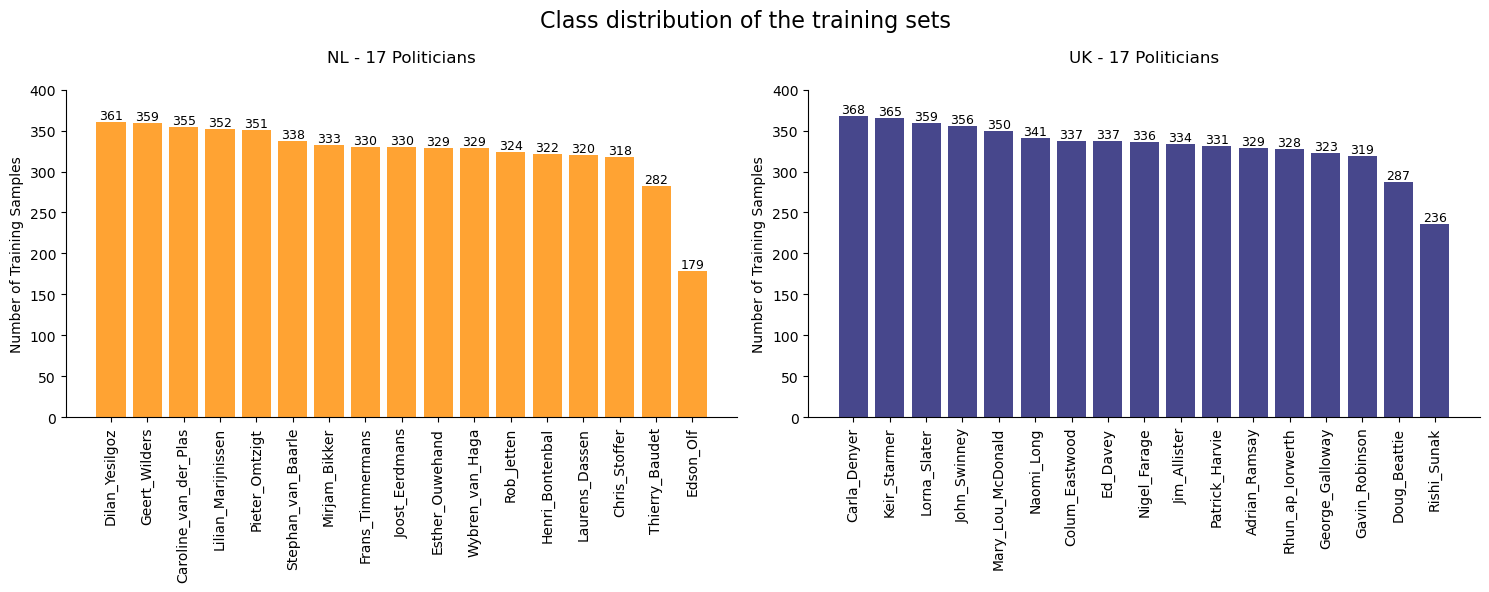

In [44]:
# Set up the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Class distribution of the training sets', fontsize=16)

colors = {
    'NL': "darkorange",
    'UK': "midnightblue"
}

for ax, country in zip([ax1, ax2], ['NL', 'UK']):
    class_counts = country_data[country]['embeddings']['politician'].value_counts().sort_values(ascending=False)
    bars = ax.bar(class_counts.index, class_counts.values, 
                 color=colors[country],
                 alpha=0.8)
    ax.grid(False)
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)
    
    # Customize the plot
    ax.set_title(f'{country} - {len(class_counts)} Politicians', pad=20)
    ax.set_ylabel('Number of Training Samples')
    ax.set_ylim(0, 400)
    ax.tick_params(axis='x', rotation=90)
    
    # Remove top and right spines
    sns.despine(ax=ax, right=True, top=True)

plt.tight_layout()
plt.show()

#### Inspect training clusters in 2D with t-SNE
This script takes approximately 2.25 minutes due to dimensionality reduction


Computing 2D clusters for NL
VGG-Face - 3307 samples
Facenet - 3307 samples
Facenet512 - 3307 samples
OpenFace - 3307 samples
ArcFace - 3307 samples
Dlib - 3307 samples
SFace - 3307 samples
face_recognition - 3307 samples

Computing 2D clusters for UK
VGG-Face - 3381 samples
Facenet - 3381 samples
Facenet512 - 3381 samples
OpenFace - 3381 samples
ArcFace - 3381 samples
Dlib - 3381 samples
SFace - 3381 samples
face_recognition - 3381 samples


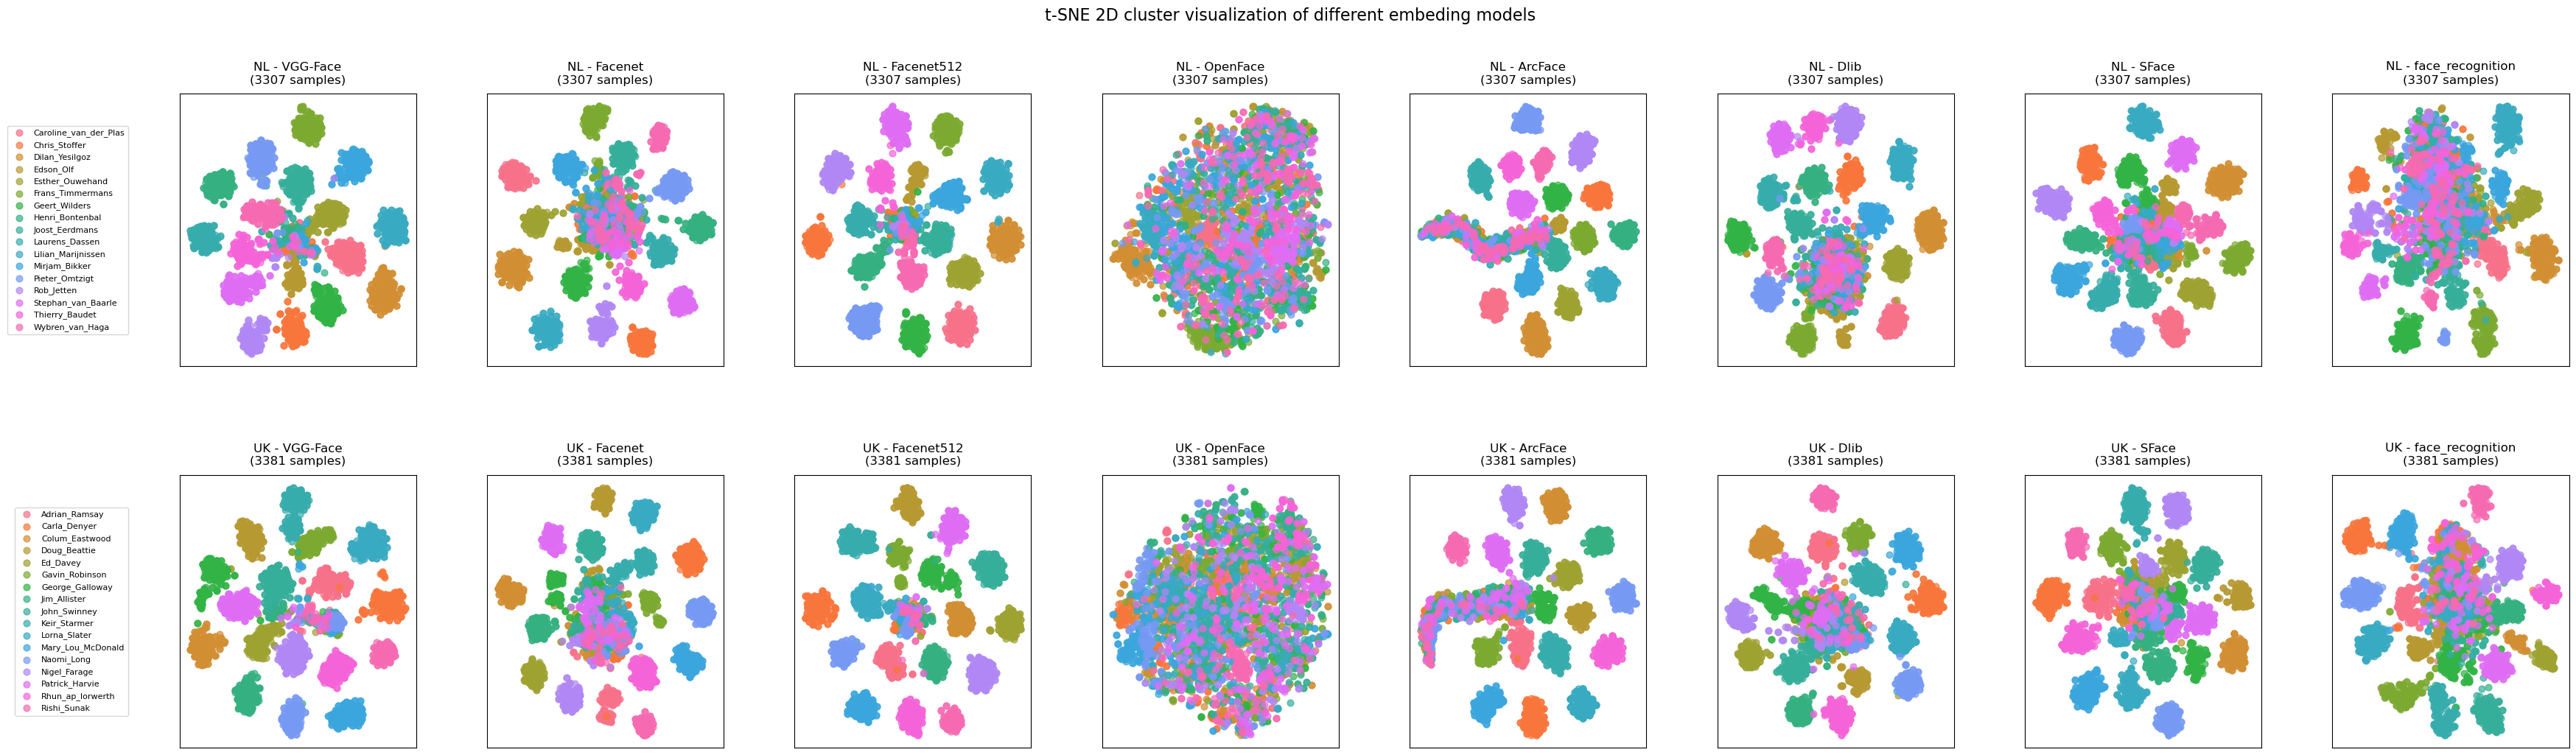

In [46]:
fig, axes = plt.subplots(2, 8, figsize=(35, 10))
fig.suptitle('t-SNE 2D cluster visualization of different embeding models', fontsize=16, y=1.02)

# Set the colors for the politicians
n_politicians = len(country_data['NL']['label_encoder'].classes_)
politician_palette = sns.color_palette("husl", n_politicians)

# Initialize t-SNE dimensionality reduction
tsne_params = {
    'n_components': 2,
    'perplexity': 30,
    'random_state': 2,
    'learning_rate': 50
}

# Compute clusters for the countries 
for country_idx, country in enumerate(countries):
    print(f'\nComputing 2D clusters for {country}')
    le = country_data[country]['label_encoder']
    
    for model_idx, model in enumerate(embedding_models):
        ax = axes[country_idx, model_idx]
        
        try:
            # Access the data
            embedder_data = country_data[country]['embedders'][model]
            X_train = np.vstack(embedder_data['train']['X'])
            y_train = embedder_data['train']['y']
            names = embedder_data['train']['politician']
            
            print(f"{model} - {len(X_train)} samples")
            
            # t-SNE
            tsne = TSNE(**tsne_params)
            X_2d = tsne.fit_transform(X_train)
            
            # Legend handles
            legend_handles = []
            unique_labels = np.unique(y_train)
            
            # Class plotting
            for label in unique_labels:
                mask = np.array(y_train) == label
                color = politician_palette[label]
                label_name = le.inverse_transform([label])[0]
                
                scatter = ax.scatter(X_2d[mask, 0], X_2d[mask, 1],
                                    color=color,
                                    label=label_name,
                                    alpha=0.7,
                                    s=40)
                if label != 99:  # Don't add unknown to legend if present
                    legend_handles.append(scatter)
            
            ax.set_title(f'{country} - {model}\n({len(X_train)} samples)', pad=10)
            
            # Add legend only to first column
            if model_idx == 0 and legend_handles:
                ax.legend(handles=legend_handles,
                         bbox_to_anchor=(-0.2, 0.5),
                         loc='center right',
                         fontsize=8)
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error:\n{str(e)}", 
                   ha='center', va='center', color='red')
            ax.set_title(f'{country} - {model} (Failed)', pad=10)
            print(f"Error with {model}: {str(e)}")
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()


Computing 2D clusters for NL
VGG-Face - 4096 dimensions
Facenet - 128 dimensions
Facenet512 - 512 dimensions
OpenFace - 128 dimensions
ArcFace - 512 dimensions
Dlib - 128 dimensions
SFace - 128 dimensions
face_recognition - 128 dimensions


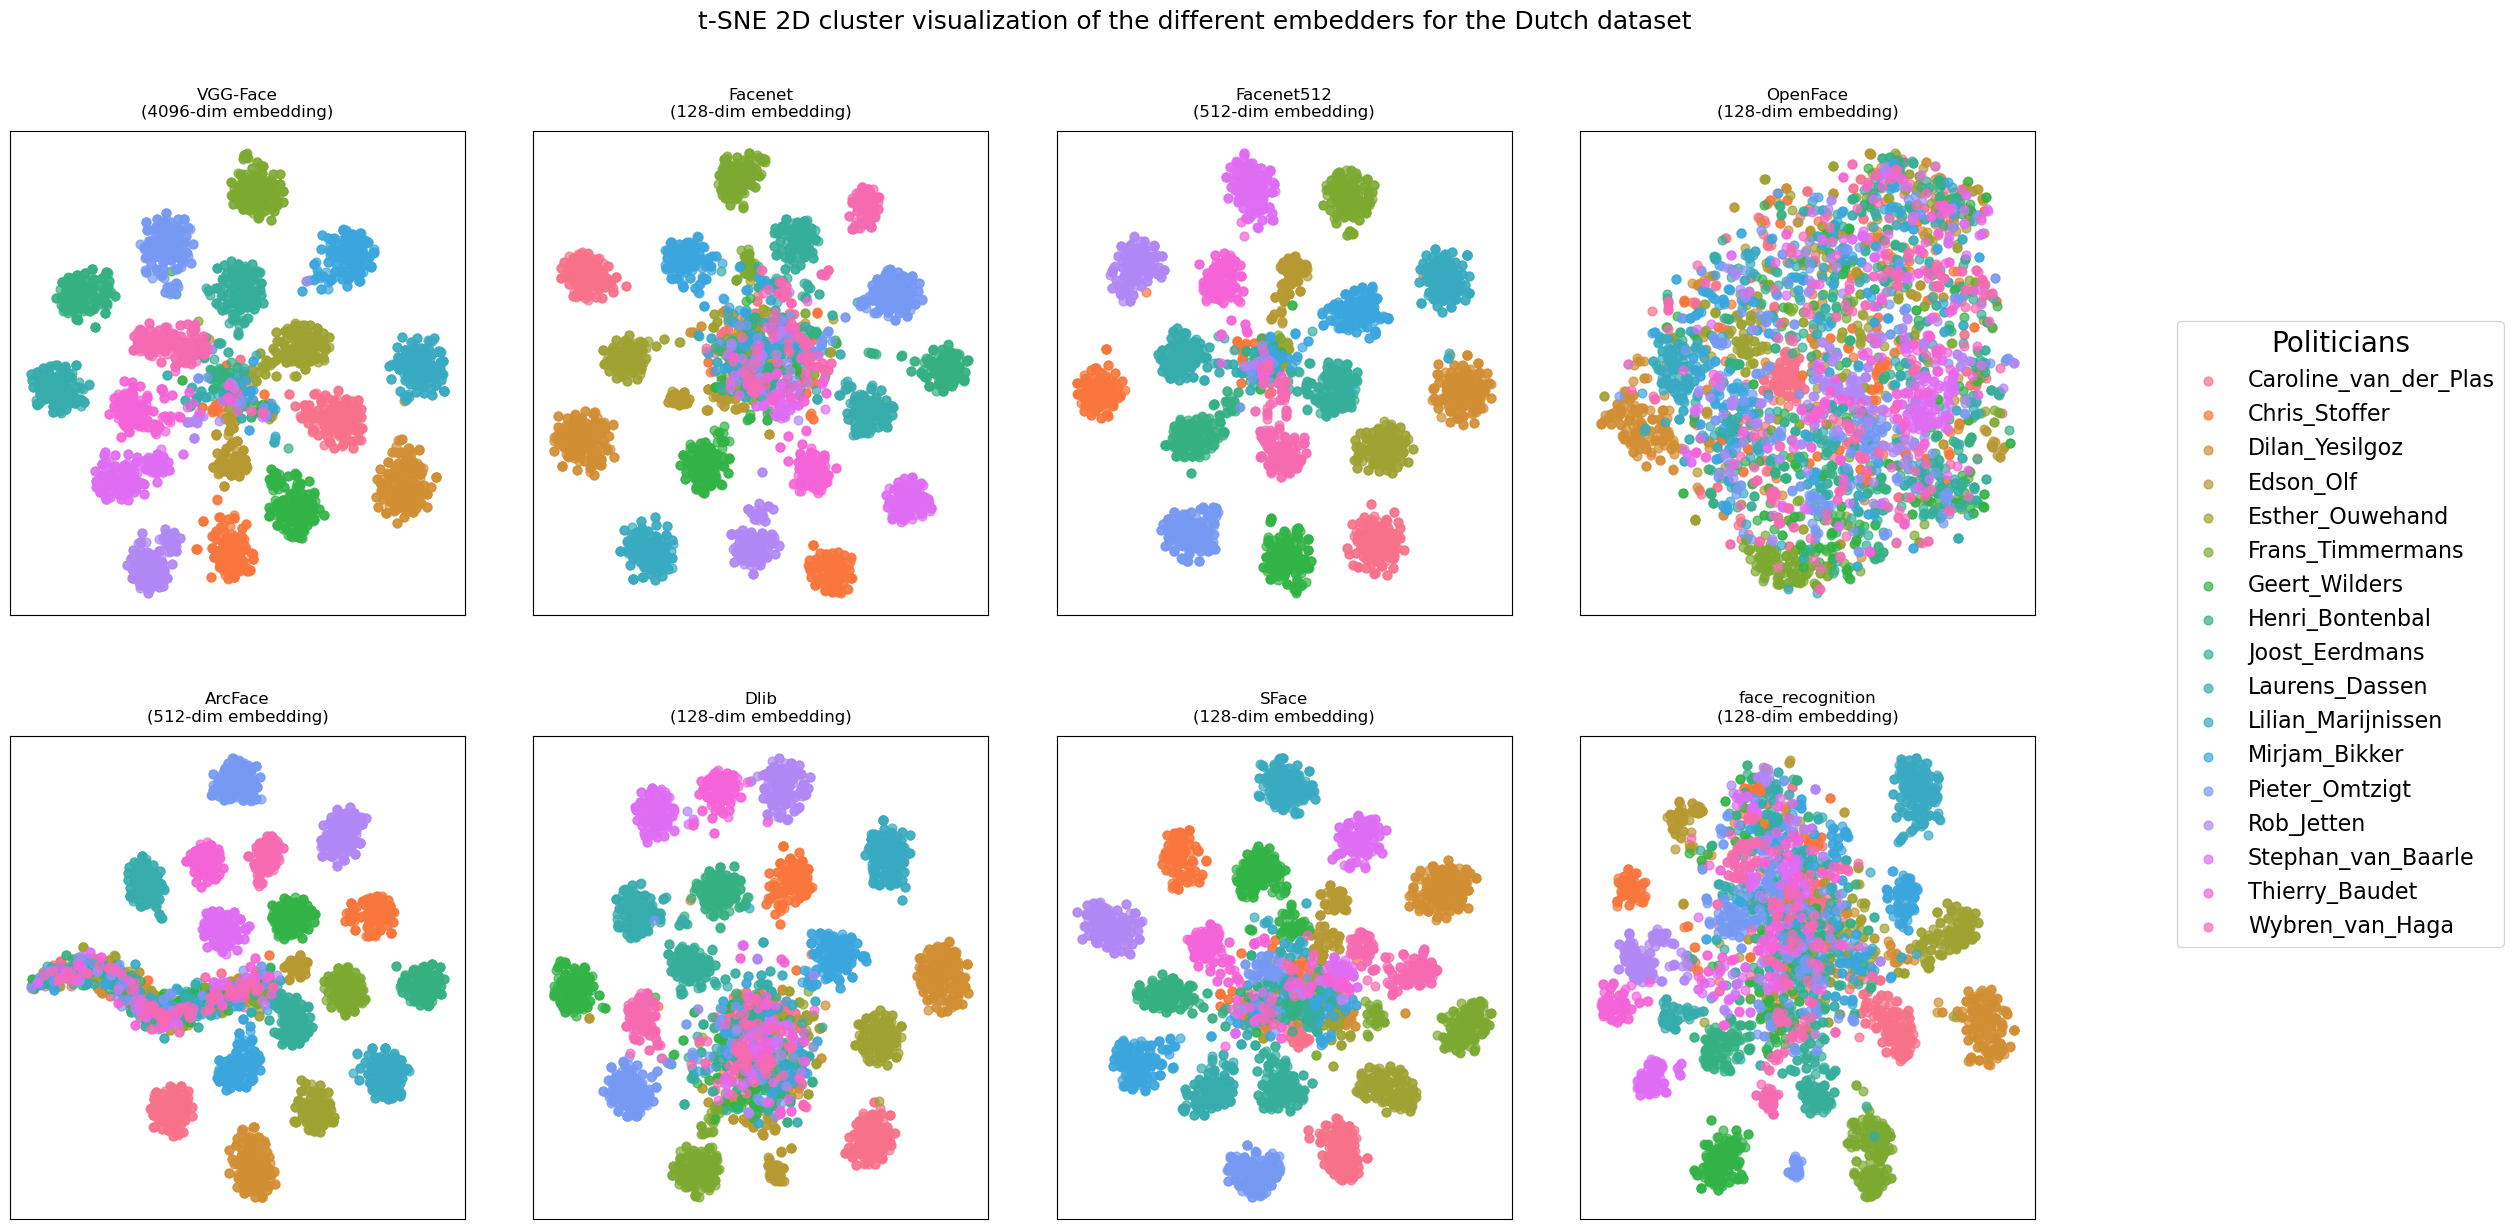

In [54]:
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
fig.suptitle('t-SNE 2D cluster visualization of the different embedders for the Dutch dataset', fontsize=18, y=1.02)

axes = axes.flatten()

n_politicians = len(country_data['NL']['label_encoder'].classes_)
politician_palette = sns.color_palette("husl", n_politicians)

tsne_params = {
    'n_components': 2,
    'perplexity': 30,
    'random_state': 2,
    'learning_rate': 50
}

print("\nComputing 2D clusters for NL")
le = country_data['NL']['label_encoder']

global_legend_handles = []
legend_labels = []

for model_idx, model in enumerate(embedding_models):
    if model_idx >= len(axes):  
        break

    ax = axes[model_idx]

    try:
        # Access the data
        embedder_data = country_data['NL']['embedders'][model]
        X_train = np.vstack(embedder_data['train']['X'])
        y_train = embedder_data['train']['y']

        dim = X_train.shape[1]  # embedding dimensionality
        print(f"{model} - {dim} dimensions")

        # t-SNE reduction
        tsne = TSNE(**tsne_params)
        X_2d = tsne.fit_transform(X_train)

        unique_labels = np.unique(y_train)

        # Plot per politician
        for label in unique_labels:
            mask = np.array(y_train) == label
            color = politician_palette[label]
            label_name = le.inverse_transform([label])[0]

            scatter = ax.scatter(
                X_2d[mask, 0], X_2d[mask, 1],
                color=color, label=label_name,
                alpha=0.7, s=40
            )

            # Collect legend info only once
            if label != 99 and label_name not in legend_labels:
                global_legend_handles.append(scatter)
                legend_labels.append(label_name)

        ax.set_title(f"{model}\n({dim}-dim embedding)", pad=10)

    except Exception as e:
        ax.text(0.5, 0.5, f"Error:\n{str(e)}",
                ha='center', va='center', color='red')
        ax.set_title(f"{model} (Failed)", pad=10)
        print(f"Error with {model}: {str(e)}")

    ax.set_xticks([])
    ax.set_yticks([])

# Remove unused subplots if fewer than 8 models
for j in range(model_idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Add one global legend spanning both rows
if global_legend_handles:
    fig.legend(
        handles=global_legend_handles,
        labels=legend_labels,
        loc='center right',
        bbox_to_anchor=(1.05, 0.5),
        fontsize=16,  # bigger font
        title="Politicians",
        title_fontsize=20
    )

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.25, right=0.85)
plt.show()


## Training & development
### Hyperparameter tuning

In [ ]:
EMBEDDING_MODELS = [
    'VGG-Face',
    'Facenet',
    'Facenet512',
    'OpenFace',
    #'DeepFace',
    'ArcFace',
    'Dlib',
    'SFace',
    'face_recognition'
]

# DF columns
embeddings_cols = ['embedding_' + embedder for embedder in embedding_models]

PARAM_GRID = {                            # Exploration of variables for gridsearch
    'C': [0.1, 1, 10, 100],               # Regularization: small C yields a soft margin and a simple model, large C yields a hard margin and a complex model
    'gamma': ['scale', 'auto'],           # Gamma: 
    'class_weight': [None, 'balanced'],   # Unbalanced training data benefits from 'balanced' weights as it adjusts weights inversely proportional to class frequencies
    'kernel': ['rbf']                     # Type of transformation applied to the input data; Gaussian; for non-linear problems
}

THRESHOLDS = np.arange(0.50, 0.96, 0.01)  # range [0.5 (model is 50% sure) to 0.95 (model is 95% sure)]

#### Calibrated probabilities, without margin threshold

In [ ]:
# --- step 1  ---
def find_best_svm_params(X_train, y_train, X_dev, y_dev, param_grid):
    best_score = -1
    best_params = None
    
    param_combinations = list(ParameterGrid(param_grid))

    for params in param_combinations:
        model = SVC(**params, probability=True, random_state=42)
        model.fit(X_train, y_train)
        
        y_dev_pred = model.predict(X_dev)
        score = f1_score(y_dev, y_dev_pred, average='weighted', zero_division=0)
        
        if score > best_score:
            best_score = score
            best_params = params
            
    return best_params

# --- step 2 ---
def evaluate_thresholds(model, X_dev, y_dev, thresholds, unknown_label):
    threshold_results = []
    
    # Get probabilities once for the best model
    probas = model.predict_proba(X_dev)
    max_probas = probas.max(axis=1)
    predicted_classes = model.classes_[probas.argmax(axis=1)]

    # Evaluate the pre-set list of thresholds
    for threshold in thresholds:
        y_dev_pred = predicted_classes.copy()
        y_dev_pred[max_probas <= threshold] = unknown_label
        
        # Define masks
        is_actually_politician = (y_dev != unknown_label)
        is_predicted_politician = (y_dev_pred != unknown_label)
        is_actually_unknown = (y_dev == unknown_label)
        is_predicted_unknown = (y_dev_pred == unknown_label)
        
        metrics = {
            'threshold': threshold,
            # Politician detection metrics
            'politician_f1': f1_score(is_actually_politician, is_predicted_politician, zero_division=0),
            'politician_precision': precision_score(is_actually_politician, is_predicted_politician, zero_division=0),
            'politician_recall': recall_score(is_actually_politician, is_predicted_politician, zero_division=0),
            # Unknown detection metrics
            'unknown_f1': f1_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
            'unknown_precision': precision_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
            'unknown_recall': recall_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
            # Multiclass metrics (on the full prediction set)
            'multiclass_f1': f1_score(y_dev, y_dev_pred, average='weighted', zero_division=0),
            'multiclass_precision': precision_score(y_dev, y_dev_pred, average='weighted', zero_division=0),
            'multiclass_recall': recall_score(y_dev, y_dev_pred, average='weighted', zero_division=0),
            # Summary statistics
            'n_politician_true': sum(is_actually_politician),
            'n_politician_pred': sum(is_predicted_politician),
            'n_unknown_true': sum(is_actually_unknown),
            'n_unknown_pred': sum(is_predicted_unknown),
            'frac_unknown_pred': sum(is_predicted_unknown) / len(y_dev) if len(y_dev) > 0 else 0,
            'frac_unknown_true': sum(is_actually_unknown) / len(y_dev) if len(y_dev) > 0 else 0,
            'mean_max_prob': np.mean(max_probas),
            'median_max_prob': np.median(max_probas)
        }
        threshold_results.append(metrics)
        
    return threshold_results

# --- step 3 ---
def evaluate_models_two_stage(country_data, countries, param_grid, embedders, thresholds, unknown_label):
    all_results = []
    
    for country in countries:
        for embedder_name in embedders:
            if embedder_name not in country_data[country]['embedders']:
                continue
            
            print(f" Processing {country} - {embedder_name}")
            
            # Fetch data
            X_train_full = np.vstack(country_data[country]['embedders'][embedder_name]['train']['X'])
            y_train_full = np.array(country_data[country]['embedders'][embedder_name]['train']['y'])
            X_dev_full = np.vstack(country_data[country]['embedders'][embedder_name]['dev']['X'])
            y_dev_full = np.array(country_data[country]['embedders'][embedder_name]['dev']['y'])
            
            if len(X_train_full) == 0 or len(X_dev_full) == 0:
                print(f"Skipping {country} - {embedder_name}: no data available")
                continue
                
            try:
                # --- step 1 - find best parameter configuration for the known classes ---
                train_politician_mask = (y_train_full != unknown_label)
                X_train_politicians = X_train_full[train_politician_mask]
                y_train_politicians = y_train_full[train_politician_mask]
                
                dev_politician_mask = (y_dev_full != unknown_label)
                X_dev_politicians = X_dev_full[dev_politician_mask]
                y_dev_politicians = y_dev_full[dev_politician_mask]
                
                print("Stage 1: Finding best SVM parameters...")
                best_params = find_best_svm_params(
                    X_train_politicians, y_train_politicians,
                    X_dev_politicians, y_dev_politicians,
                    param_grid
                )
                print(f"Best params found: {best_params}")

                # --- Calibrate the model ---
                model = SVC(**best_params, probability=True, random_state=42)
                model.fit(X_train_politicians, y_train_politicians)
                
                # Calibrate probabilities on the politician dev set
                if len(X_dev_politicians) > 0:
                    calibrated_model = CalibratedClassifierCV(model, method='sigmoid')
                    calibrated_model.fit(X_dev_politicians, y_dev_politicians)
                    final_model = calibrated_model
                else:
                    final_model = model

                # --- step 2: threshold evaluation ---
                print("Stage 2: Evaluating thresholds for politician/unknown detection...")
                
                threshold_results = evaluate_thresholds(
                    final_model, X_dev_full, y_dev_full, thresholds, unknown_label
                )
                
                # Add context (country, embedder, params) to each result
                for result in threshold_results:
                    result['country'] = country
                    result['embedder'] = embedder_name
                    result['params'] = str(best_params)
                    for param_name, param_value in best_params.items():
                        result[param_name] = param_value
                    all_results.append(result)

            except Exception as e:
                print(f"Error processing {country} - {embedder_name}: {str(e)}")
                continue

    # Convert all_results to DataFrame format
    if not all_results:
        return pd.DataFrame()

    results_df = pd.DataFrame(all_results)
    
    # Reorder columns for better readability
    param_cols = list(param_grid.keys())
    fixed_cols = ['country', 'embedder', 'threshold', 'params']
    metric_cols = [c for c in results_df.columns if c not in param_cols + fixed_cols]
    all_cols = fixed_cols + param_cols + metric_cols
    existing_cols = [col for col in all_cols if col in results_df.columns]
    
    return results_df[existing_cols]

In [63]:
# Evaluation of both countries takes approximately 47 minutes
'''
evaluation_df = evaluate_models_two_stage(
    country_data = country_data, 
    countries = countries, 
    param_grid = PARAM_GRID, 
    embedders = EMBEDDING_MODELS, 
    thresholds = THRESHOLDS, 
    unknown_label = 99)'''

 Processing NL - VGG-Face
Stage 1: Finding best SVM parameters...
Best params found: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing NL - Facenet
Stage 1: Finding best SVM parameters...
Best params found: {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing NL - Facenet512
Stage 1: Finding best SVM parameters...
Best params found: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing NL - OpenFace
Stage 1: Finding best SVM parameters...
Best params found: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing NL - ArcFace
Stage 1: Finding best SVM parameters...
Best params found: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing NL - Dlib
Stage 1: Finding best SVM parameters...
Best params found: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing NL - SFace
Stage 1: Finding best SVM parameters...
Best params found: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing NL - face_recognition
Stage 1: Finding best SVM parameters...
Best params found: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing UK - VGG-Face
Stage 1: Finding best SVM parameters...
Best params found: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing UK - Facenet
Stage 1: Finding best SVM parameters...
Best params found: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing UK - Facenet512
Stage 1: Finding best SVM parameters...
Best params found: {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing UK - OpenFace
Stage 1: Finding best SVM parameters...
Best params found: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing UK - ArcFace
Stage 1: Finding best SVM parameters...
Best params found: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing UK - Dlib
Stage 1: Finding best SVM parameters...
Best params found: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing UK - SFace
Stage 1: Finding best SVM parameters...
Best params found: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...
 Processing UK - face_recognition
Stage 1: Finding best SVM parameters...
Best params found: {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Stage 2: Evaluating thresholds for politician/unknown detection...


In [ ]:
evaluation_df.to_parquet('datasets/grid_evaluation_results_only_probabilities.parquet')

In [ ]:
evaluation_df = pd.read_parquet('datasets/grid_evaluation_results_only_probabilities.parquet')

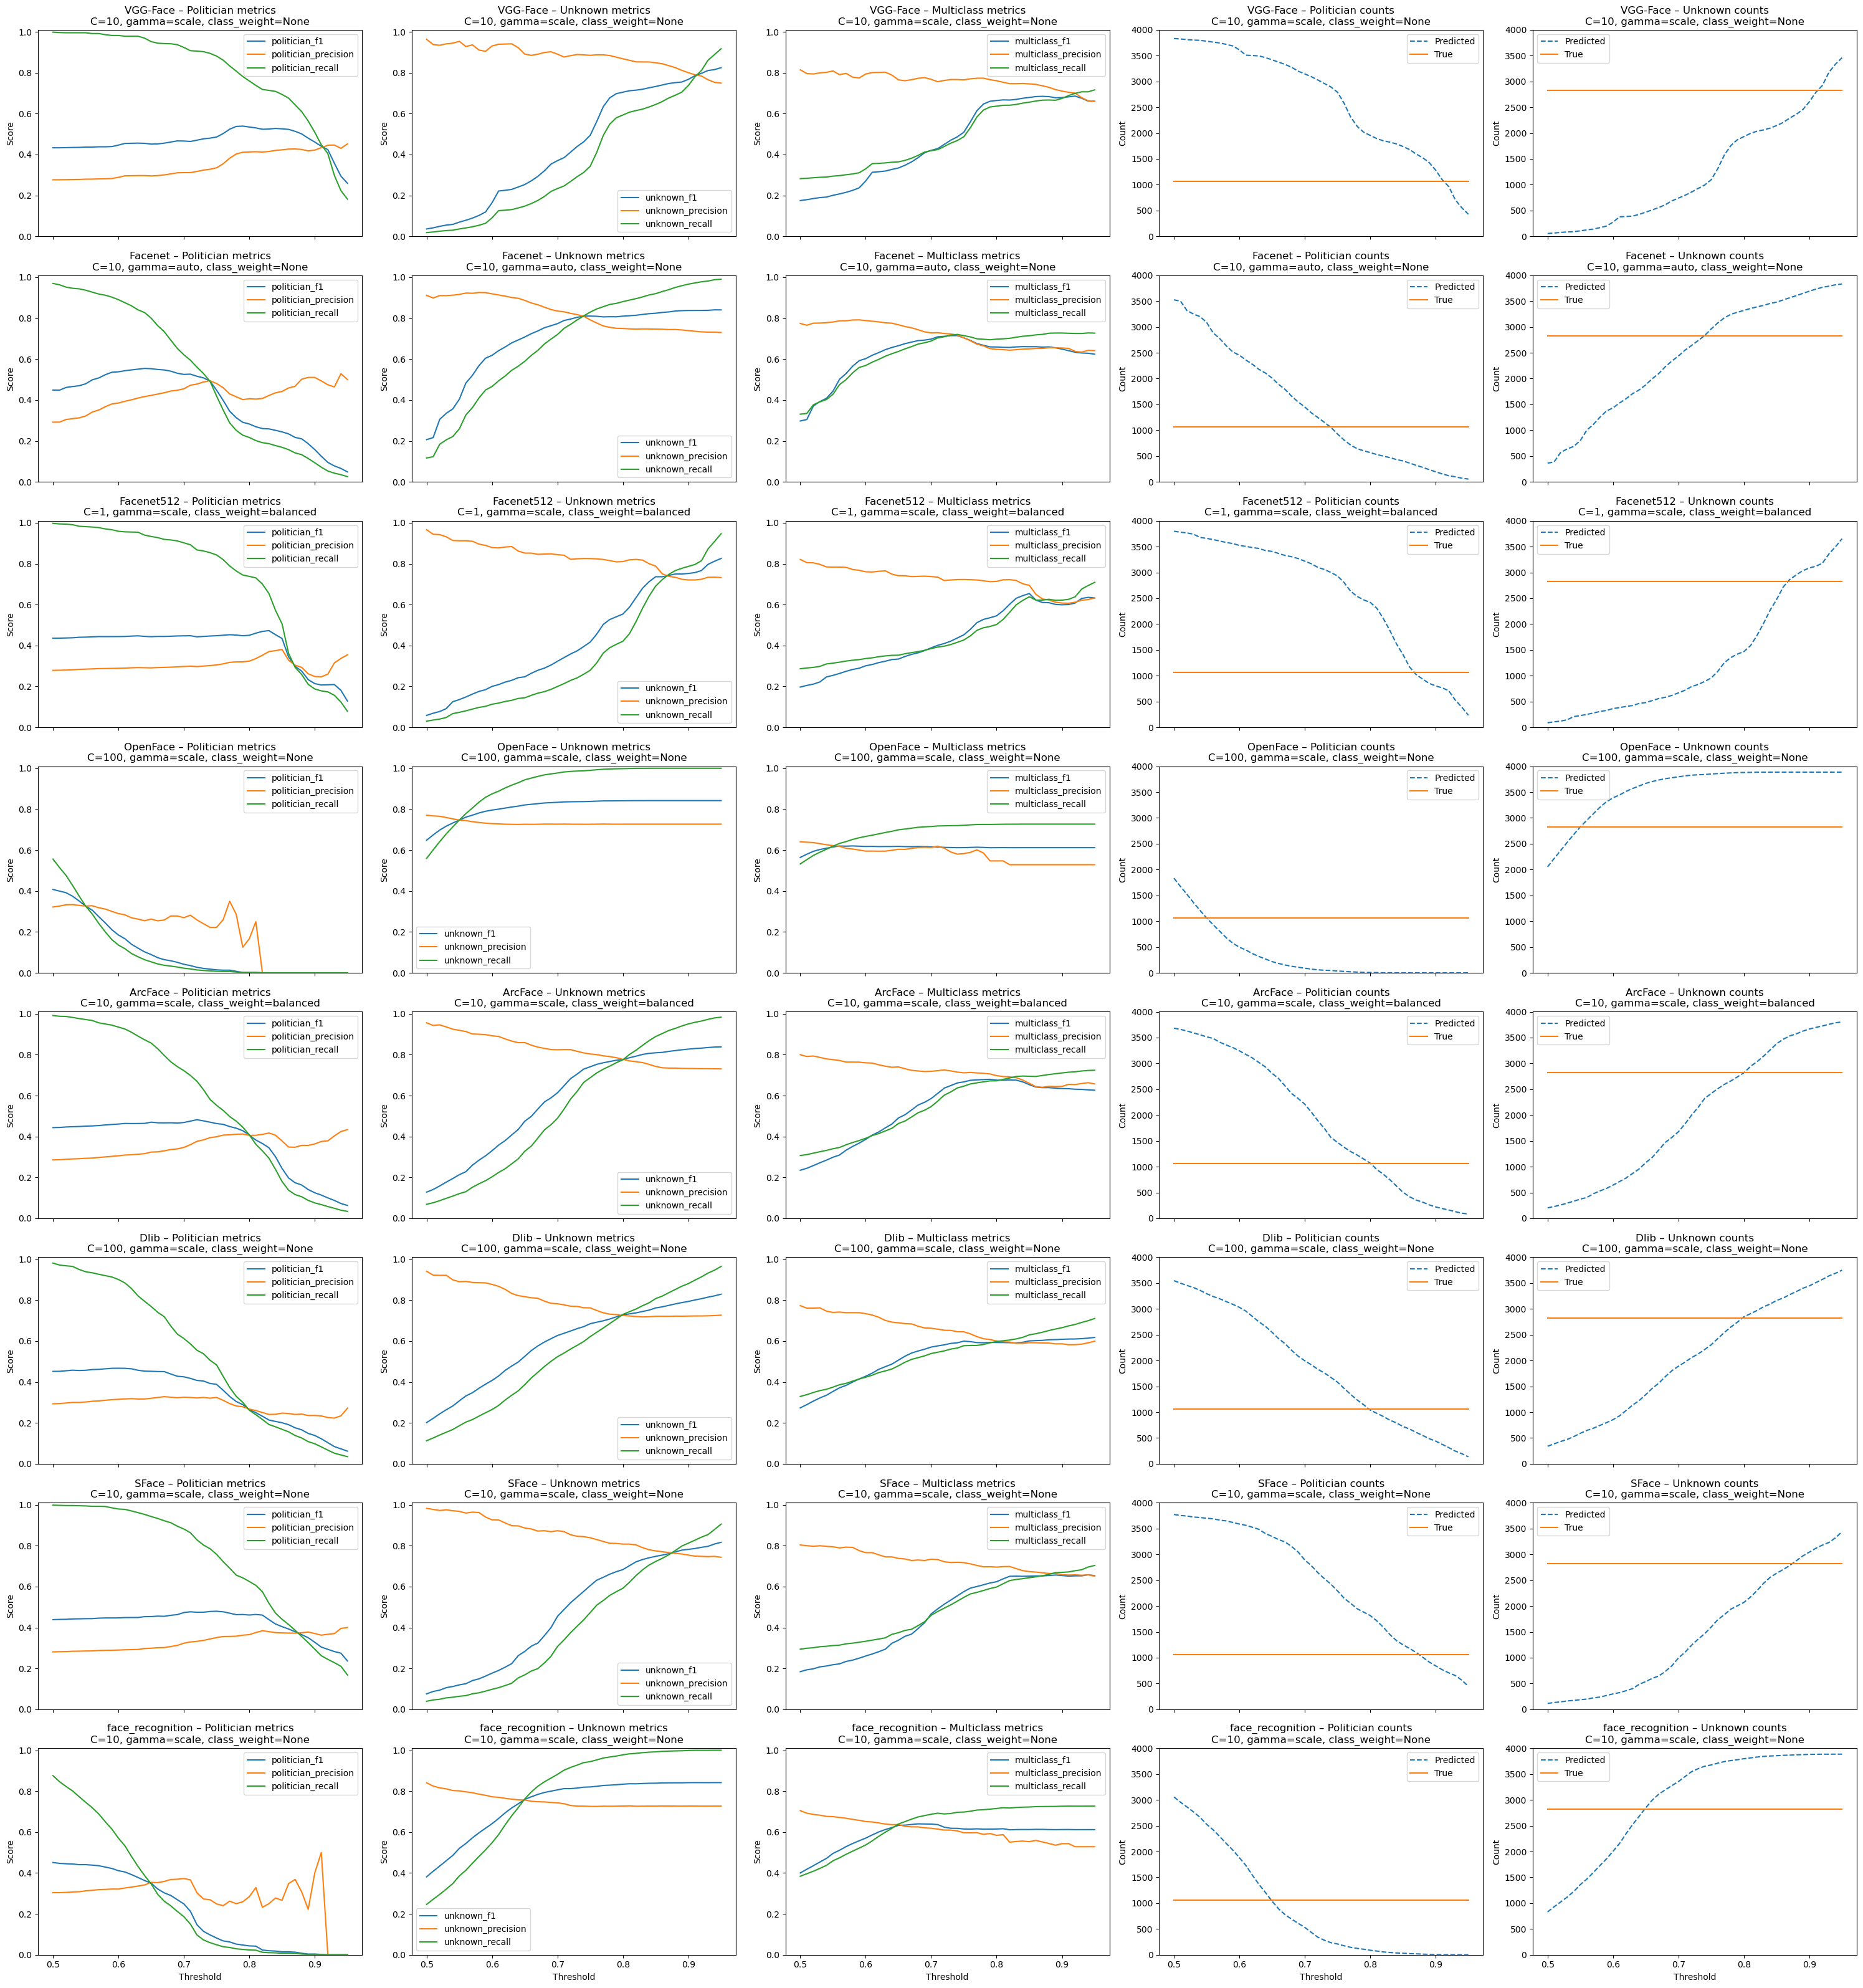

In [ ]:
df_nl = evaluation_df[evaluation_df["country"] == "NL"].copy()

# Define metric groups
politician_metrics = ["politician_f1", "politician_precision", "politician_recall"]
unknown_metrics = ["unknown_f1", "unknown_precision", "unknown_recall"]
multiclass_metrics = ["multiclass_f1", "multiclass_precision", "multiclass_recall"]

models = df_nl["embedder"].unique()

fig, axes = plt.subplots(len(models), 5, figsize=(30, 4 * len(models)), sharex=True)

if len(models) == 1:
    axes = [axes]

for row_idx, model in enumerate(models):
    df_model = df_nl[df_nl["embedder"] == model]

    cfg = df_model.iloc[0]
    config_text = f"C={cfg['C']}, gamma={cfg['gamma']}, class_weight={cfg['class_weight']}"

    # Politician metrics
    ax = axes[row_idx][0]
    for m in politician_metrics:
        sns.lineplot(data=df_model, x="threshold", y=m, ax=ax, label=m)
    ax.set_title(f"{model} – Politician metrics\n{config_text}")
    ax.set_ylabel("Score")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)

    # Unknown metrics
    ax = axes[row_idx][1]
    for m in unknown_metrics:
        sns.lineplot(data=df_model, x="threshold", y=m, ax=ax, label=m)
    ax.set_title(f"{model} – Unknown metrics\n{config_text}")
    ax.set_ylabel("Score")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)


    # Multiclass metrics
    ax = axes[row_idx][2]
    for m in multiclass_metrics:
        sns.lineplot(data=df_model, x="threshold", y=m, ax=ax, label=m)
    ax.set_title(f"{model} – Multiclass metrics\n{config_text}")
    ax.set_ylabel("Score")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)


    # Politician counts (predicted vs true)
    ax = axes[row_idx][3]
    sns.lineplot(data=df_model, x="threshold", y="n_politician_pred", ax=ax, label="Predicted", linestyle="--")
    sns.lineplot(data=df_model, x="threshold", y="n_politician_true", ax=ax, label="True", linestyle="-")
    ax.set_title(f"{model} – Politician counts\n{config_text}")
    ax.set_ylabel("Count")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 4001)

    # Unknown counts (predicted vs true)
    ax = axes[row_idx][4]
    sns.lineplot(data=df_model, x="threshold", y="n_unknown_pred", ax=ax, label="Predicted", linestyle="--")
    sns.lineplot(data=df_model, x="threshold", y="n_unknown_true", ax=ax, label="True", linestyle="-")
    ax.set_title(f"{model} – Unknown counts\n{config_text}")
    ax.set_ylabel("Count")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 4001)

plt.tight_layout()
plt.show()


In [ ]:
def debug_plot(df, embedder_name):
    df_embed = df[df['embedder'] == embedder_name].sort_values('threshold')
    
    # Create a row of 4 subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)
    
    # Politician metrics
    ax = axes[0]
    ax.plot(df_embed['threshold'], df_embed['politician_precision'], 'o-', label='Precision', color='cornflowerblue')
    ax.plot(df_embed['threshold'], df_embed['politician_recall'], 's-', label='Recall', color='darkmagenta')
    ax.plot(df_embed['threshold'], df_embed['politician_f1'], '^-', label='F1', color='sandybrown')
    ax.set_title(f'{embedder_name} – Politician Metrics')
    ax.set_ylabel("Score")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Multiclass metrics
    ax = axes[1]
    ax.plot(df_embed['threshold'], df_embed['multiclass_precision'], 'o-', label='Precision', color='cornflowerblue')
    ax.plot(df_embed['threshold'], df_embed['multiclass_recall'], 's-', label='Recall', color='darkmagenta')
    ax.plot(df_embed['threshold'], df_embed['multiclass_f1'], '^-', label='F1', color='sandybrown')
    ax.set_title(f'{embedder_name} – Multiclass Metrics')
    ax.set_ylabel("Score")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Unknown statistics
    ax = axes[2]
    ax.plot(df_embed['threshold'], df_embed['frac_unknown_pred'], 'o-', label='Fraction Unknown Predicted', color='red')
    ax.plot(df_embed['threshold'], df_embed['frac_unknown_true'], 's-', label='Fraction Unknown True', color='blue')
    ax.set_title('Unknown Statistics')
    ax.set_ylabel("Fraction")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Mean/Median Max Probabilities
    ax = axes[3]
    ax.plot(df_embed['threshold'], df_embed['mean_max_prob'], 'o-', label='Mean Max Prob', color='green')
    ax.plot(df_embed['threshold'], df_embed['median_max_prob'], 's-', label='Median Max Prob', color='purple')
    ax.set_title("Max Probability Statistics")
    ax.set_ylabel("Probability")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.4, 1.01)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.show()

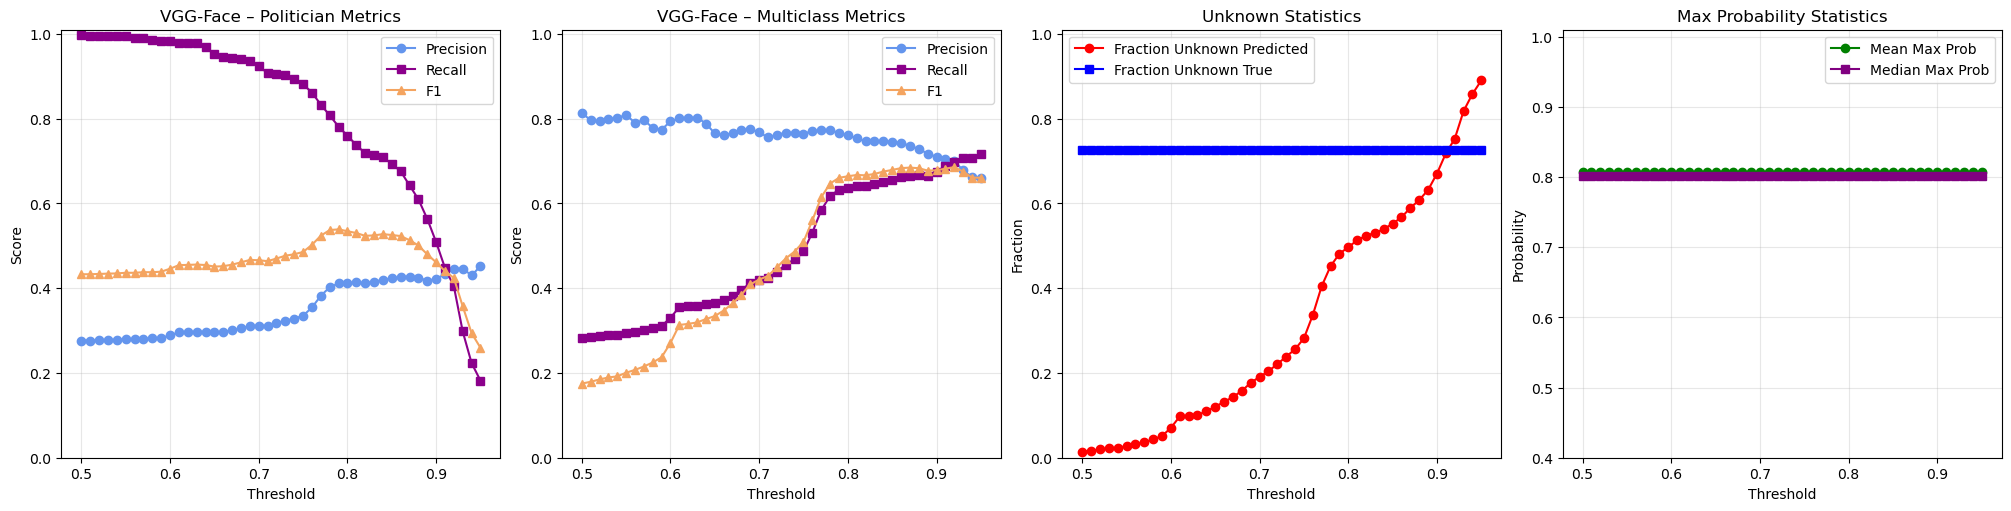

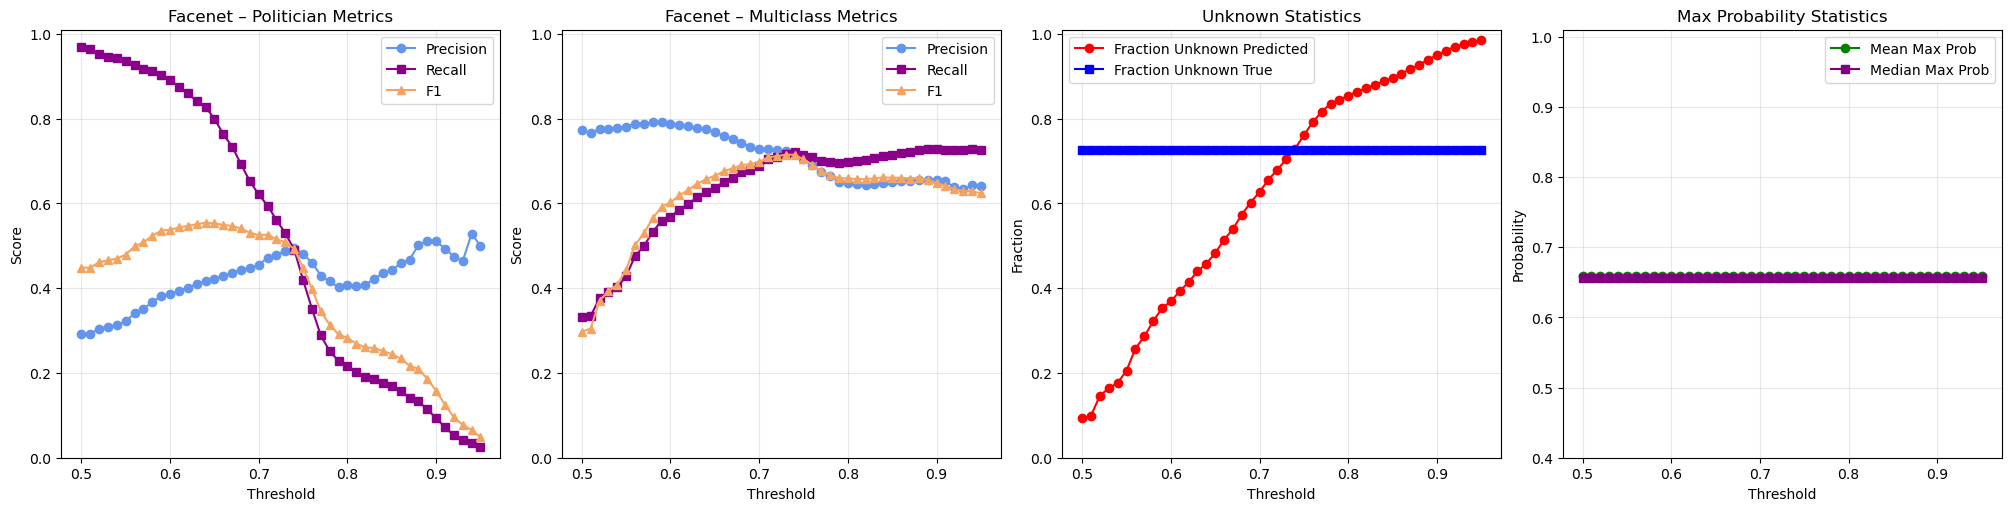

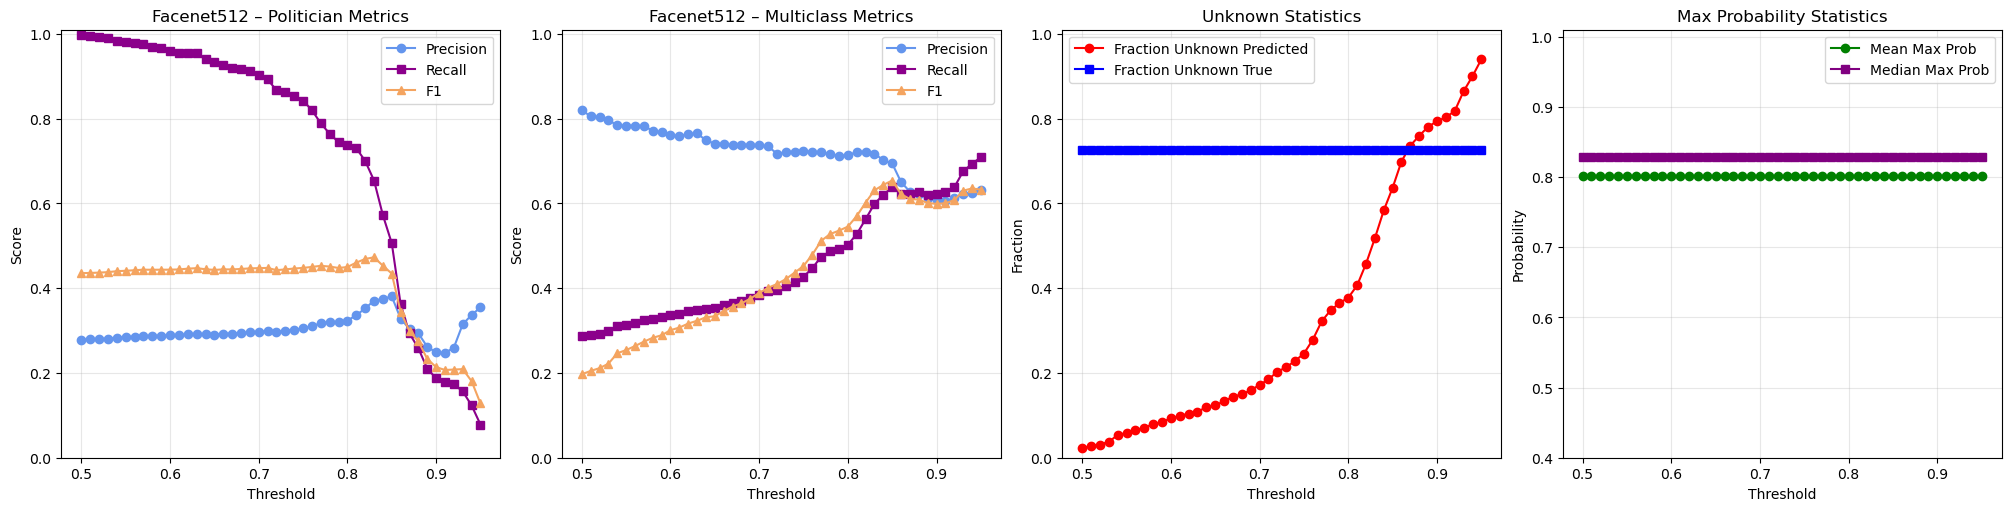

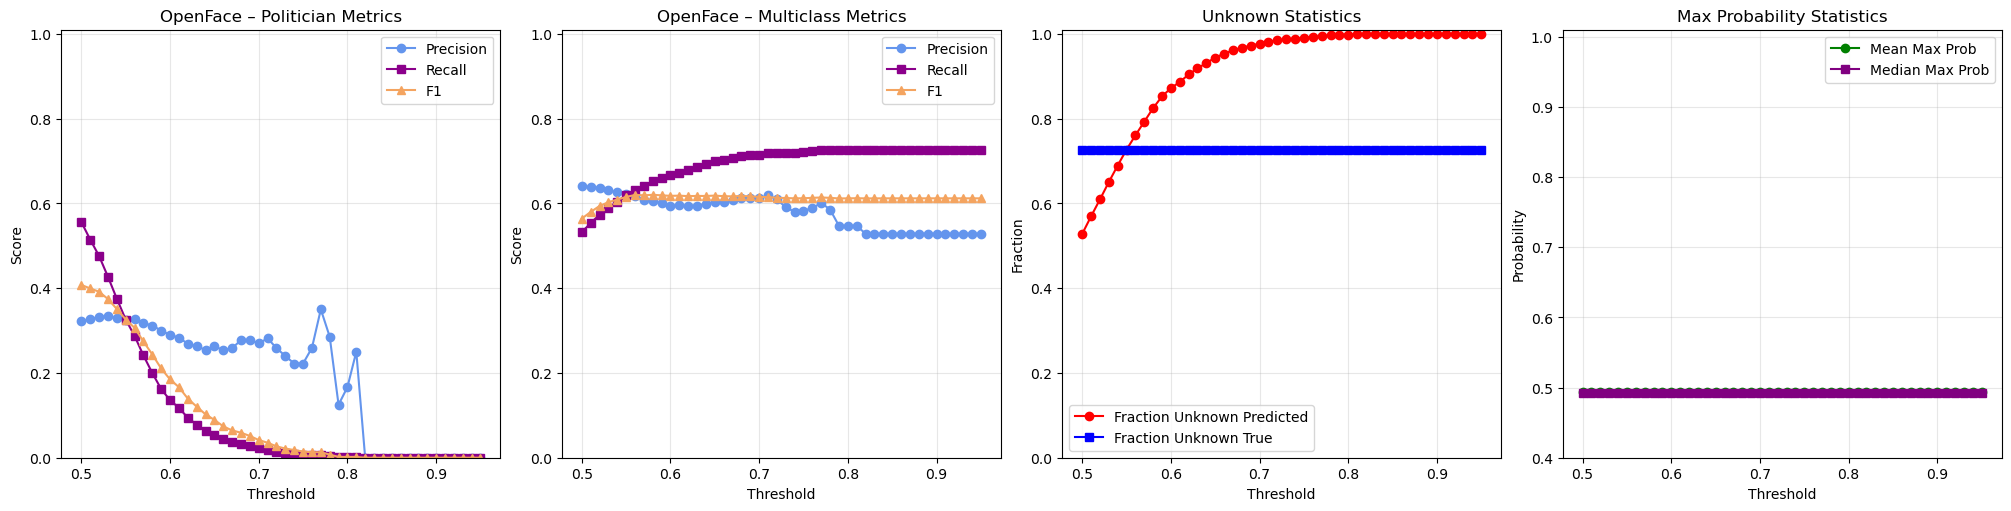

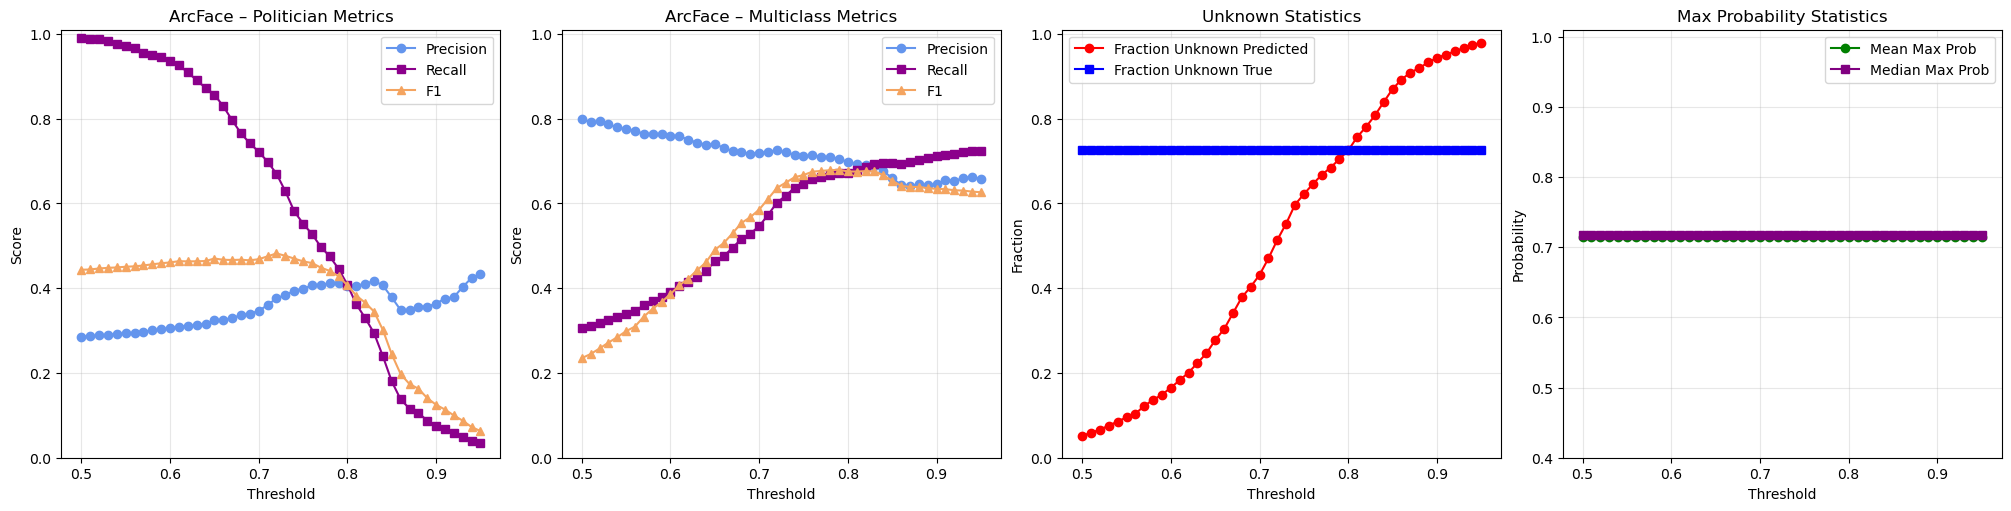

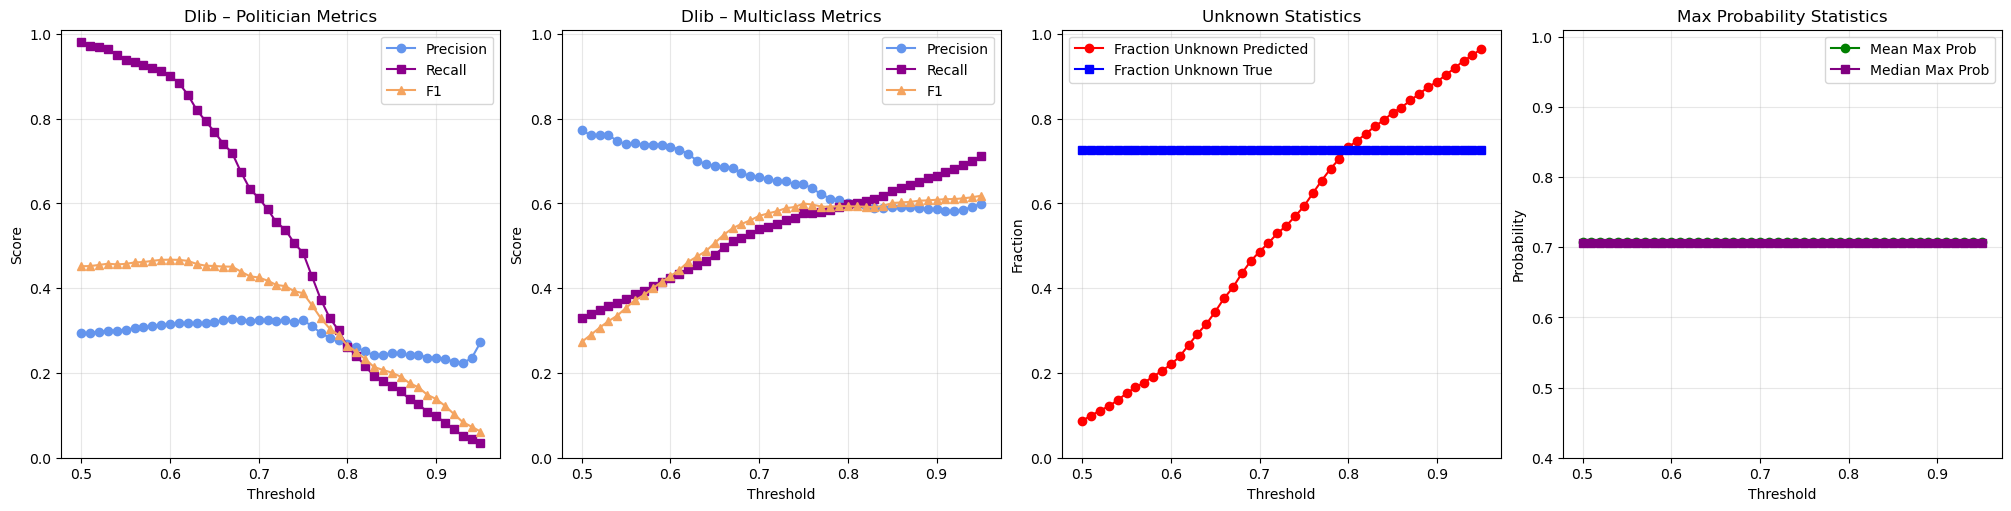

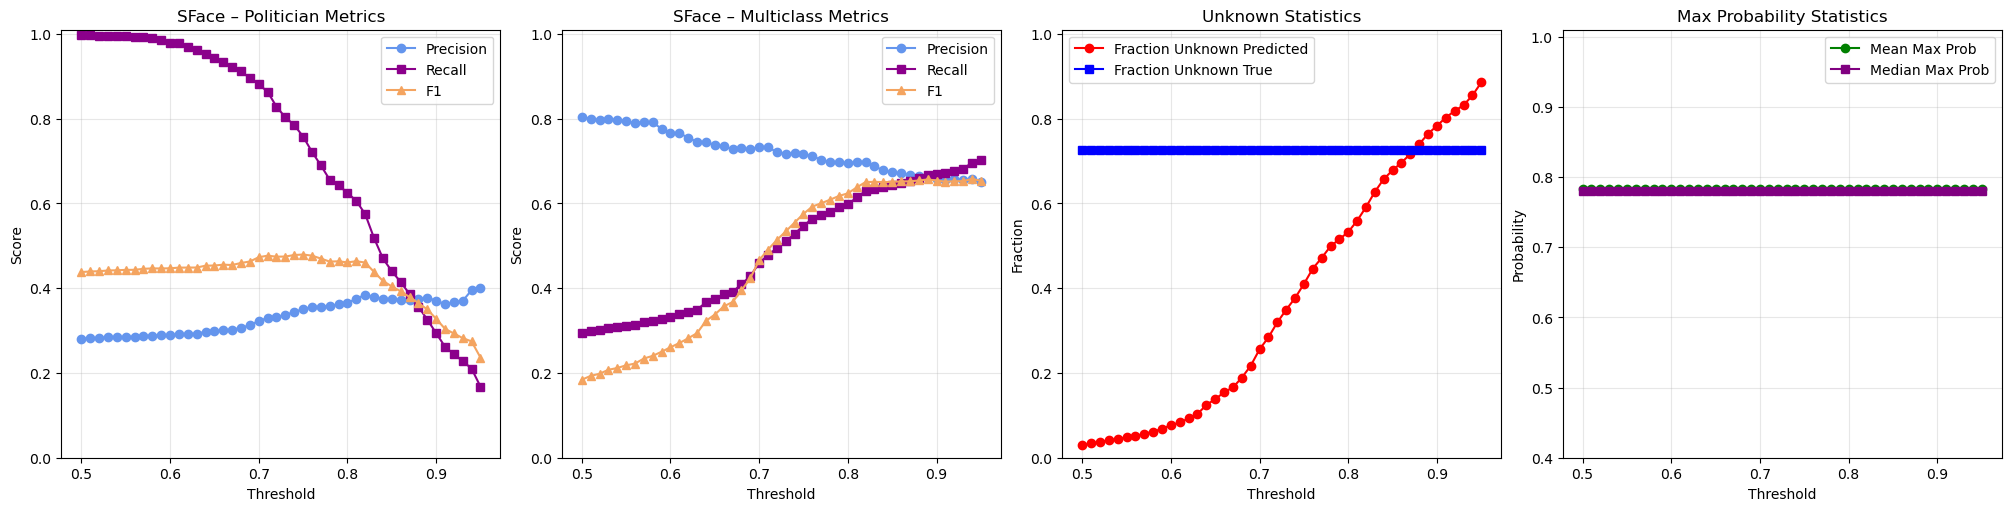

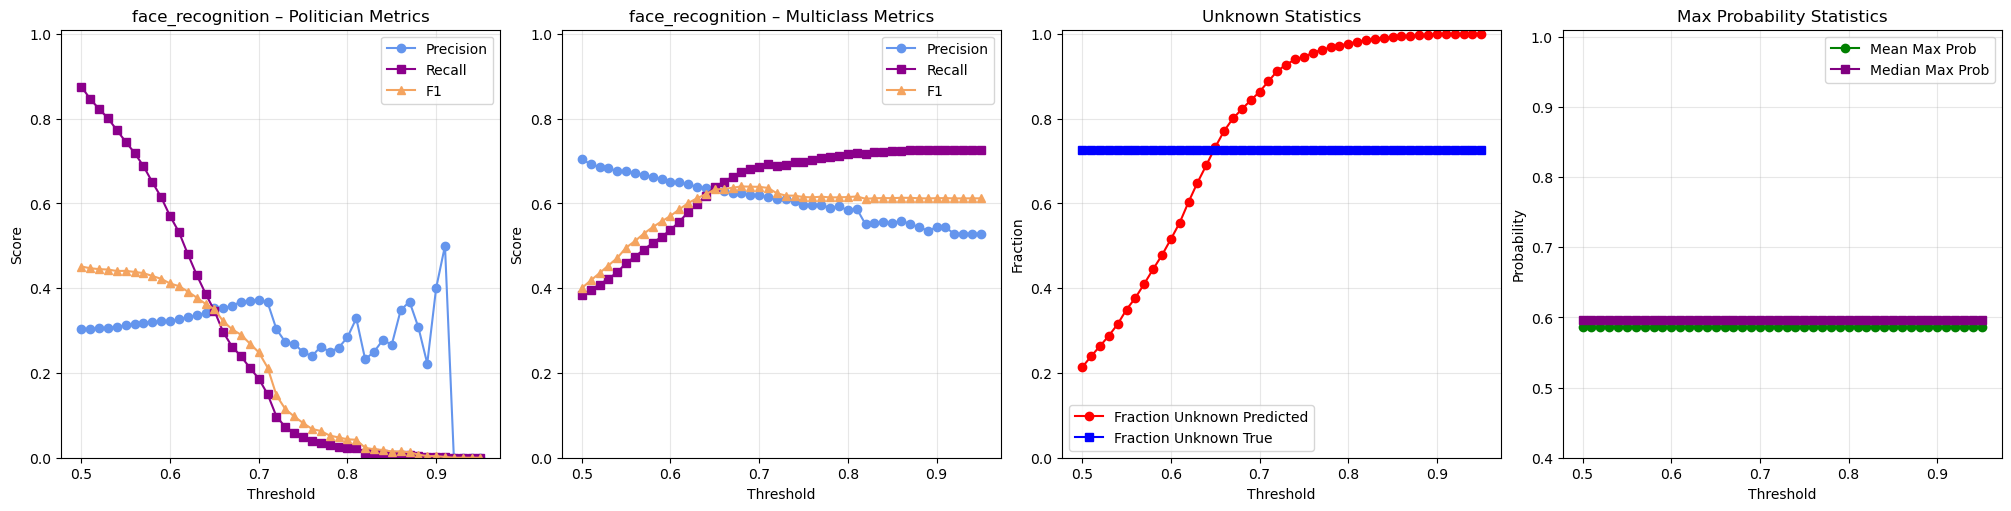

In [106]:
for embedder in df_nl['embedder'].unique():
    debug_plot(df_nl, embedder)

#### Calibrated probabilities, margin threshold

In [ ]:
# --- step 1 ---
def find_best_svm_params(X_train, y_train, X_dev, y_dev, param_grid):
    best_score = -1
    best_params = None
    for params in ParameterGrid(param_grid):
        model = SVC(**params, probability=True, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_dev)
        score = f1_score(y_dev, y_pred, average='weighted', zero_division=0)
        if score > best_score:
            best_score = score
            best_params = params
    return best_params

# --- step 2 ---
def compute_margin_thresholds(base_model, X_dev_politicians, percentiles=[5, 10, 25, 50]):
    decision_scores = base_model.decision_function(X_dev_politicians)
    if decision_scores.ndim == 1:  # binary case
        decision_scores = np.vstack([-decision_scores, decision_scores]).T
    max_margins = decision_scores.max(axis=1)
    thresholds = np.percentile(max_margins, percentiles).tolist()
    return thresholds

# --- step 3 ---
def evaluate_thresholds(base_model, calibrated_model, X_test, y_test, proba_thresholds, margin_thresholds, unknown_label):
    results = []
    probas = calibrated_model.predict_proba(X_test)
    max_probas = probas.max(axis=1)
    predicted_classes = calibrated_model.classes_[probas.argmax(axis=1)]
    
    decision_scores = base_model.decision_function(X_test)
    if decision_scores.ndim == 1:  # binary case
        decision_scores = np.vstack([-decision_scores, decision_scores]).T
    max_margins = decision_scores.max(axis=1)
    
    for prob_t in proba_thresholds:
        for margin_t in margin_thresholds:
            y_pred = predicted_classes.copy()
            is_unknown = (max_probas < prob_t) | (max_margins < margin_t)
            y_pred[is_unknown] = unknown_label

            # Counts
            n_politician_true = np.sum(y_test != unknown_label)
            n_politician_pred = np.sum(y_pred != unknown_label)
            n_unknown_true = np.sum(y_test == unknown_label)
            n_unknown_pred = np.sum(y_pred == unknown_label)
            frac_unknown_pred = n_unknown_pred / len(y_pred)
            frac_unknown_true = n_unknown_true / len(y_test)

            metrics = {
                'prob_threshold': np.round(prob_t, 2),
                'margin_threshold': np.round(margin_t, 2),
                'politician_f1': f1_score(y_test != unknown_label, y_pred != unknown_label, zero_division=0),
                'politician_precision': precision_score(y_test != unknown_label, y_pred != unknown_label, zero_division=0),
                'politician_recall': recall_score(y_test != unknown_label, y_pred != unknown_label, zero_division=0),
                'unknown_f1': f1_score(y_test == unknown_label, y_pred == unknown_label, zero_division=0),
                'unknown_precision': precision_score(y_test == unknown_label, y_pred == unknown_label, zero_division=0),
                'unknown_recall': recall_score(y_test == unknown_label, y_pred == unknown_label, zero_division=0),
                'multiclass_f1': f1_score(y_test, y_pred, average='weighted', zero_division=0),
                'multiclass_precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
                'multiclass_recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
                'n_politician_true': n_politician_true,
                'n_politician_pred': n_politician_pred,
                'n_unknown_true': n_unknown_true,
                'n_unknown_pred': n_unknown_pred,
                'frac_unknown_pred': frac_unknown_pred,
                'frac_unknown_true': frac_unknown_true,
                'mean_max_prob': np.mean(max_probas),
                'median_max_prob': np.median(max_probas)
            }
            results.append(metrics)
    return results

# --- step 4 ---
def evaluate_models_two_stage(country_data, countries, param_grid, embedders, proba_thresholds, unknown_label):
    all_results = []

    for country in countries:
        for embedder_name in embedders:
            print(f'Country {country} - embedder {embedder_name} - compute best parameter configurations')
            if embedder_name not in country_data[country]['embedders']:
                continue
            
            try:
                X_train = np.vstack(country_data[country]['embedders'][embedder_name]['train']['X'])
                y_train = np.array(country_data[country]['embedders'][embedder_name]['train']['y'])
                X_dev = np.vstack(country_data[country]['embedders'][embedder_name]['dev']['X'])
                y_dev = np.array(country_data[country]['embedders'][embedder_name]['dev']['y'])
                X_test = np.vstack(country_data[country]['embedders'][embedder_name]['test']['X'])
                y_test = np.array(country_data[country]['embedders'][embedder_name]['test']['y'])

                dev_politician_mask = (y_dev != unknown_label)
                X_dev_politicians = X_dev[dev_politician_mask]
                y_dev_politicians = y_dev[dev_politician_mask]

                if X_train.shape[0] == 0 or X_dev_politicians.shape[0] == 0:
                    print(f"Skipping {country}-{embedder_name}: not enough politician data")
                    continue

                # Stage 1: Hyperparameter tuning
                best_params = find_best_svm_params(X_train, y_train, X_dev_politicians, y_dev_politicians, param_grid)

                base_model = SVC(**best_params, probability=True, random_state=42)
                base_model.fit(X_train, y_train)

                calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid', cv=3)
                calibrated_model.fit(X_train, y_train)

                # Stage 2: Data-driven margin thresholds
                margin_thresholds = compute_margin_thresholds(base_model, X_dev_politicians)

                # Stage 3: Evaluate thresholds on test set
                threshold_results = evaluate_thresholds(
                    base_model, calibrated_model,
                    X_test, y_test,
                    proba_thresholds, margin_thresholds,
                    unknown_label
                )

                # Store results
                for r in threshold_results:
                    r.update({
                        'country': country,
                        'embedder': embedder_name,
                        'params': str(best_params),
                        'C': best_params.get('C', None),
                        'gamma': best_params.get('gamma', None),
                        'class_weight': best_params.get('class_weight', None),
                        'kernel': best_params.get('kernel', None)
                    })
                    all_results.append(r)

            except Exception as e:
                print(f"ERROR {country}-{embedder_name}: {e}")
                continue

    if not all_results:
        return pd.DataFrame()

    df = pd.DataFrame(all_results)

    cols_order = ['country','embedder','prob_threshold', 'margin_threshold', 'params','C','gamma','class_weight','kernel',
                  'politician_f1','politician_precision','politician_recall',
                  'unknown_f1','unknown_precision','unknown_recall',
                  'multiclass_f1','multiclass_precision','multiclass_recall',
                  'n_politician_true','n_politician_pred','n_unknown_true','n_unknown_pred',
                  'frac_unknown_pred','frac_unknown_true','mean_max_prob','median_max_prob']
    df = df[cols_order]
    return df

In [187]:
PARAM_GRID = {                            # Exploration of variables for gridsearch
    'C': [0.1, 1, 10],                    # Regularization: small C yields a soft margin and a simple model, large C yields a hard margin and a complex model
    'gamma': ['scale', 'auto'],           # Gamma: 
    'class_weight': [None, 'balanced'],   # Unbalanced training data benefits from 'balanced' weights as it adjusts weights inversely proportional to class frequencies
    'kernel': ['rbf']                     # Type of transformation applied to the input data; Gaussian; for non-linear problems
}

PROBA_THRESHOLDS = np.arange(0.50, 0.95, 0.025) # range [0.5 (model is 50% sure) to 0.95 (model is 95% sure)]
UNKNOWN_LABEL = 99

In [165]:
nl_results_df = evaluate_models_two_stage(country_data, ['NL'], PARAM_GRID, embedding_models, PROBA_THRESHOLDS, UNKNOWN_LABEL)
uk_results_df = evaluate_models_two_stage(country_data, ['UK'], PARAM_GRID, embedding_models, PROBA_THRESHOLDS, UNKNOWN_LABEL)

Country NL - embedder VGG-Face - compute best parameter configurations
Country NL - embedder Facenet - compute best parameter configurations
Country NL - embedder Facenet512 - compute best parameter configurations
Country NL - embedder OpenFace - compute best parameter configurations
Country NL - embedder ArcFace - compute best parameter configurations
Country NL - embedder Dlib - compute best parameter configurations
Country NL - embedder SFace - compute best parameter configurations
Country NL - embedder face_recognition - compute best parameter configurations
Country UK - embedder VGG-Face - compute best parameter configurations
Country UK - embedder Facenet - compute best parameter configurations
Country UK - embedder Facenet512 - compute best parameter configurations
Country UK - embedder OpenFace - compute best parameter configurations
Country UK - embedder ArcFace - compute best parameter configurations
Country UK - embedder Dlib - compute best parameter configurations
Country U

In [166]:
uk_results_df.shape, nl_results_df.shape

((576, 26), (576, 26))

In [167]:
final_results_df = pd.concat([nl_results_df, uk_results_df])

In [168]:
final_results_df.to_parquet('datasets/train_dev_test_grid_eval_UK-NL.parquet')

Detailed inspection

In [170]:
final_grid_eval = pd.read_parquet('datasets/train_dev_test_grid_eval_UK-NL.parquet')
nl_results_df = final_grid_eval[final_grid_eval['country'] == 'NL']
uk_results_df = final_grid_eval[final_grid_eval['country'] == 'UK']

In [171]:
def debug_plot(df, embedder_name):
    # Filter for the specific embedder
    df_embed = df[df['embedder'] == embedder_name]
    
    # For each prob_threshold, find the row with highest politician_recall
    best_rows = df_embed.loc[df_embed.groupby('prob_threshold')['politician_recall'].idxmax()]
    best_rows = best_rows.sort_values('prob_threshold')
    
    # Create a row of 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)
    
    # --- [0] Politician metrics
    ax = axes[0]
    ax.plot(best_rows['prob_threshold'], best_rows['politician_precision'], 'o-', label='Precision', color='cornflowerblue')
    ax.plot(best_rows['prob_threshold'], best_rows['politician_recall'], 's-', label='Recall', color='darkturquoise')
    ax.plot(best_rows['prob_threshold'], best_rows['politician_f1'], '^-', label='F1', color='yellowgreen')
    ax.set_title(f'{embedder_name} – Politician Metrics (Best Recall)')
    ax.set_ylabel("Score")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # --- [1] Multiclass metrics
    ax = axes[1]
    ax.plot(best_rows['prob_threshold'], best_rows['multiclass_precision'], 'o-', label='Precision', color='orchid')
    ax.plot(best_rows['prob_threshold'], best_rows['multiclass_recall'], 's-', label='Recall', color='darkmagenta')
    ax.plot(best_rows['prob_threshold'], best_rows['multiclass_f1'], '^-', label='F1', color='plum')
    ax.set_title(f'{embedder_name} – Multiclass Metrics (Best Recall)')
    ax.set_ylabel("Score")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # --- [2] Unknown statistics
    ax = axes[2]
    ax.plot(best_rows['prob_threshold'], best_rows['frac_unknown_pred'], 'o-', label='Fraction Unknown Predicted', color='red')
    ax.plot(best_rows['prob_threshold'], best_rows['frac_unknown_true'], 's-', label='Fraction Unknown True', color='blue')
    ax.set_title('Unknown Statistics (Best Recall)')
    ax.set_ylabel("Fraction")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.show()

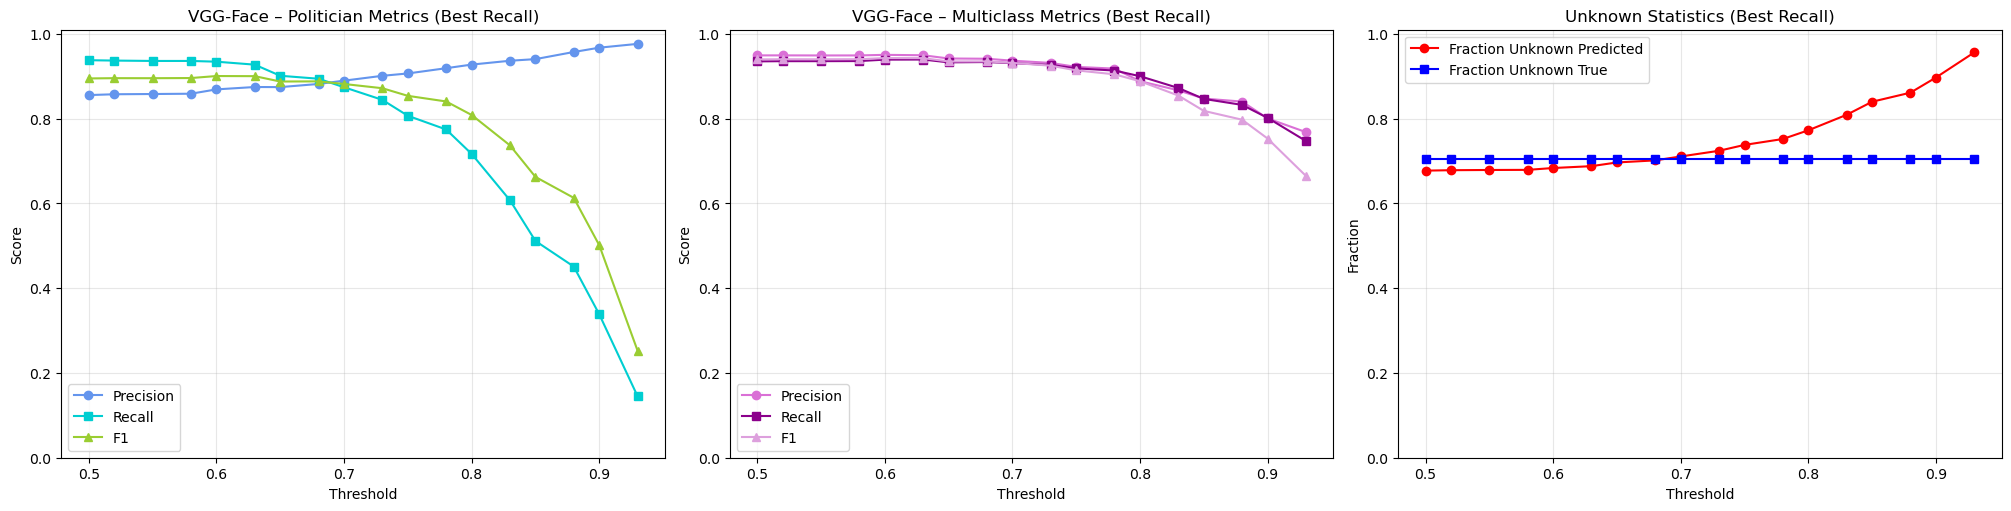

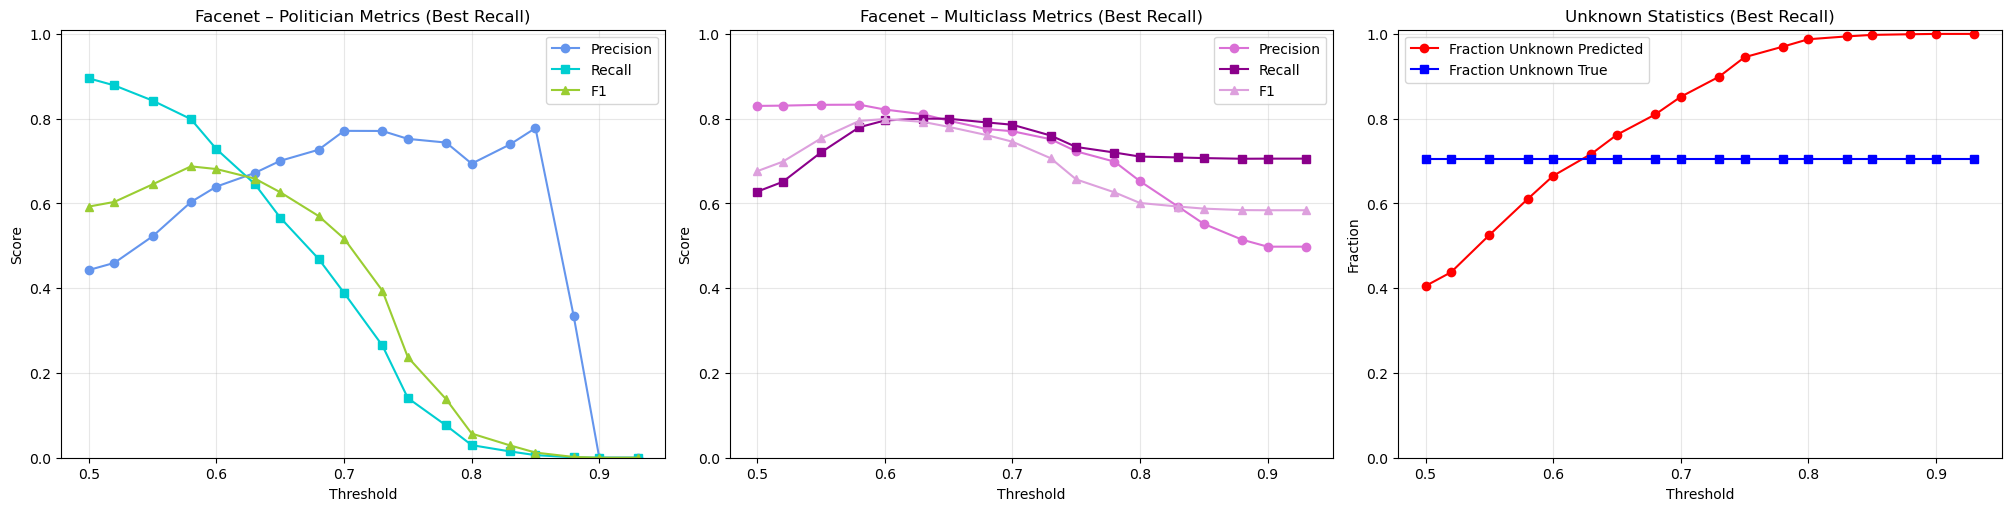

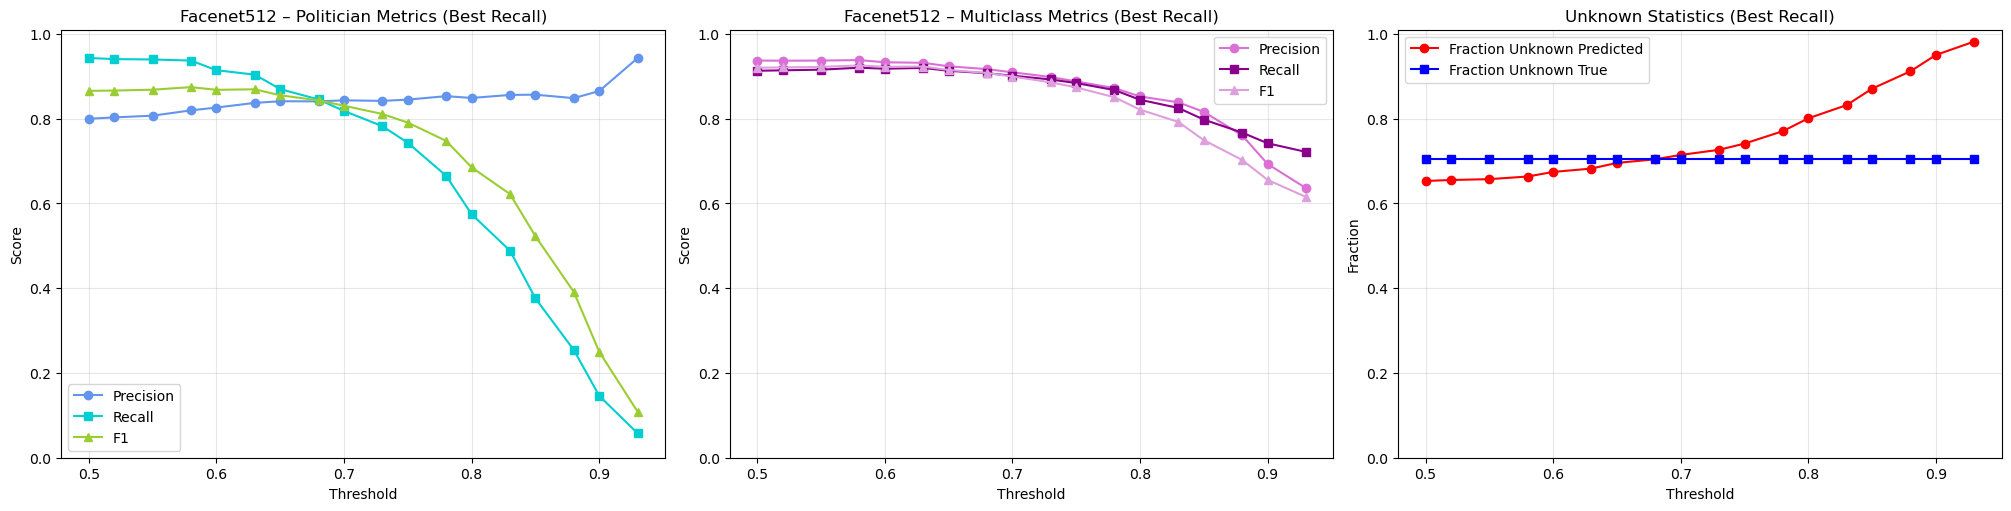

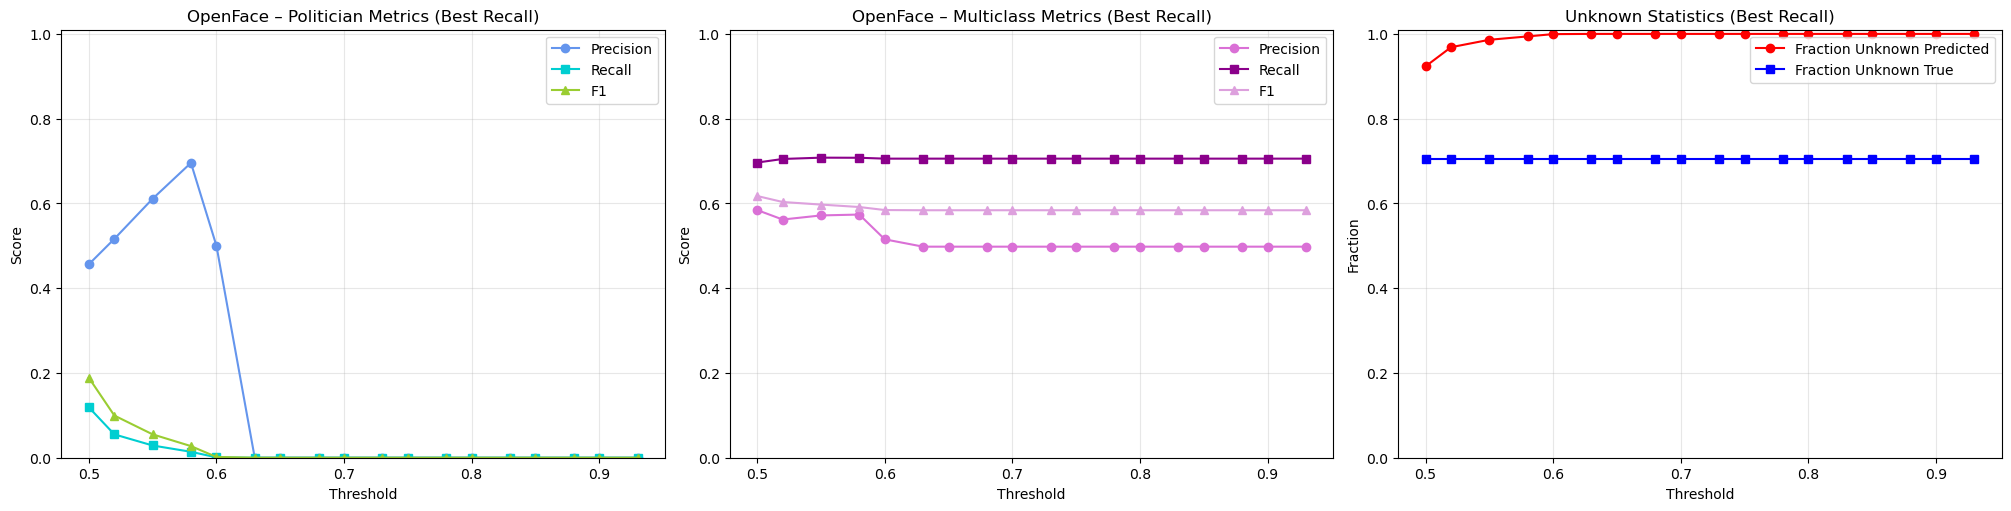

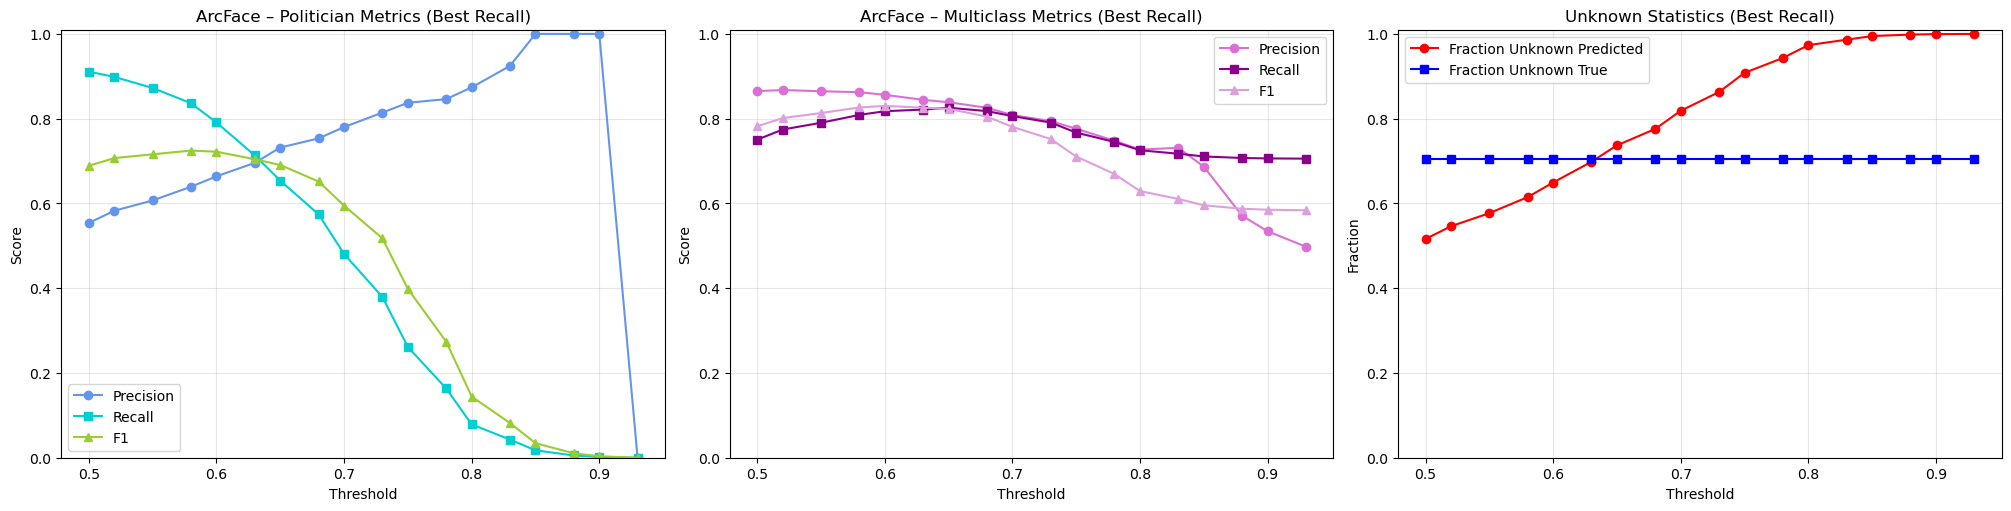

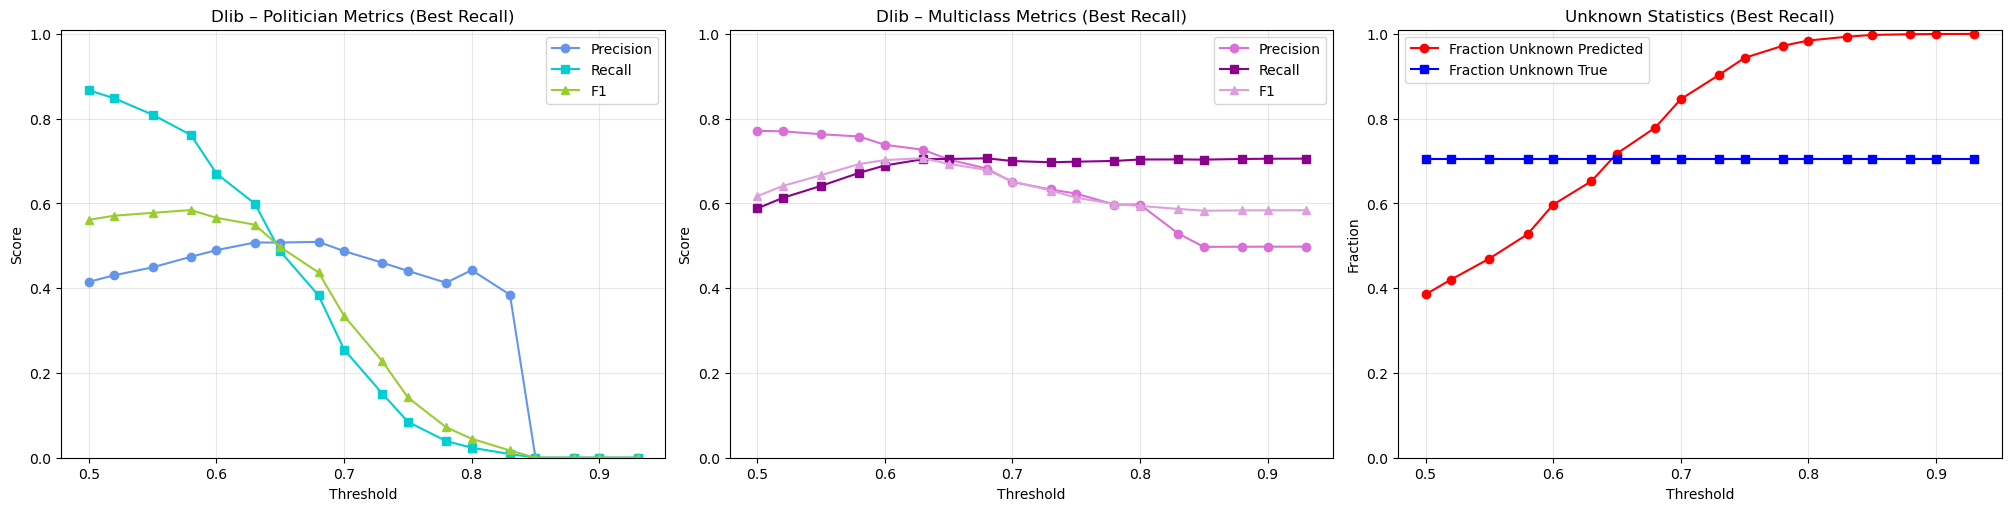

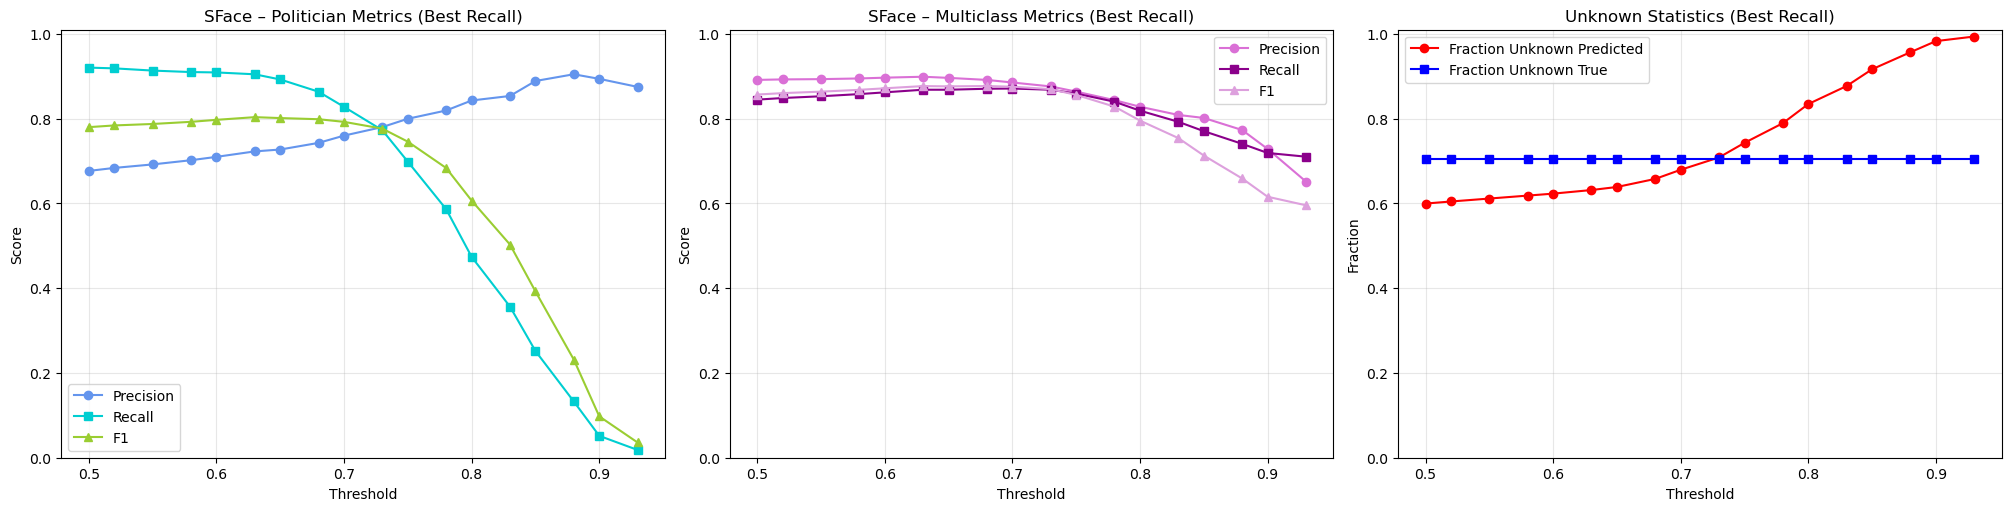

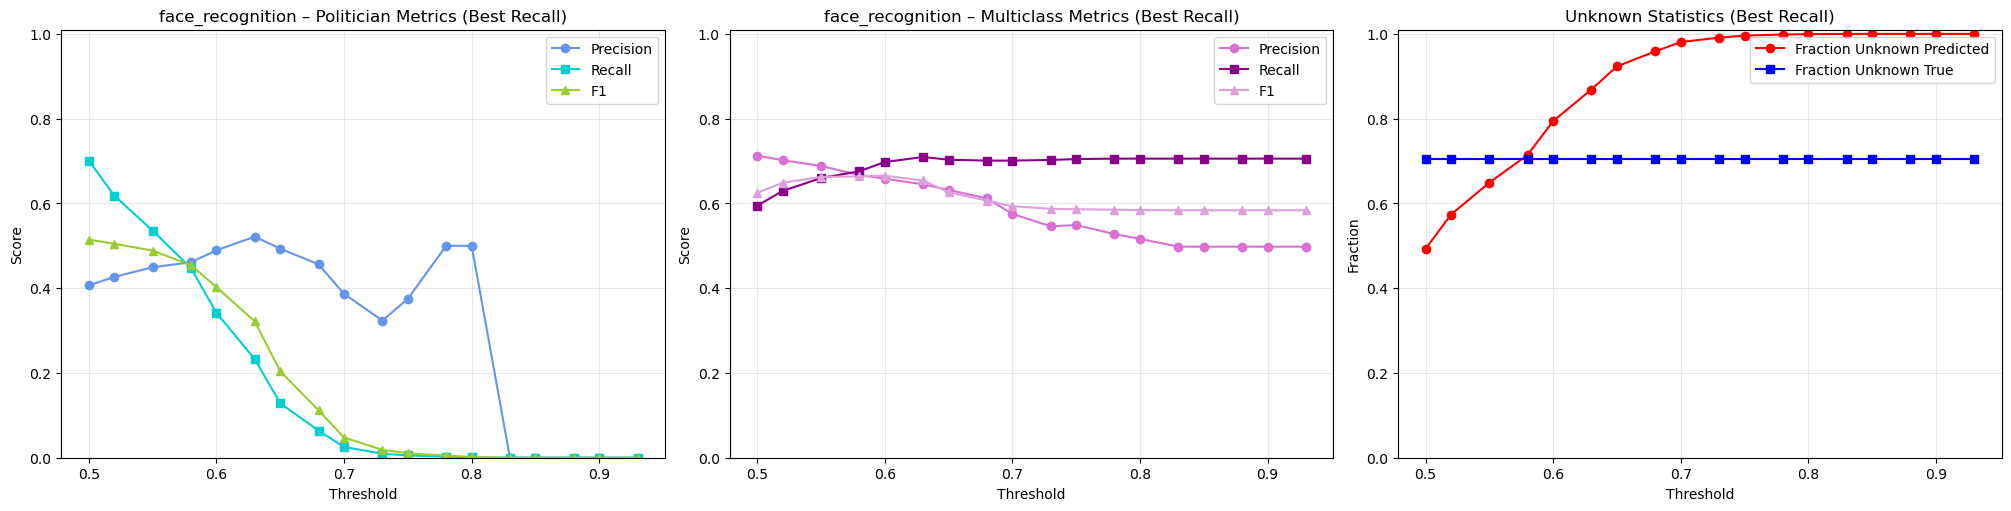

In [172]:
## NL ##
for embedder in nl_results_df['embedder'].unique():
    debug_plot(nl_results_df, embedder)

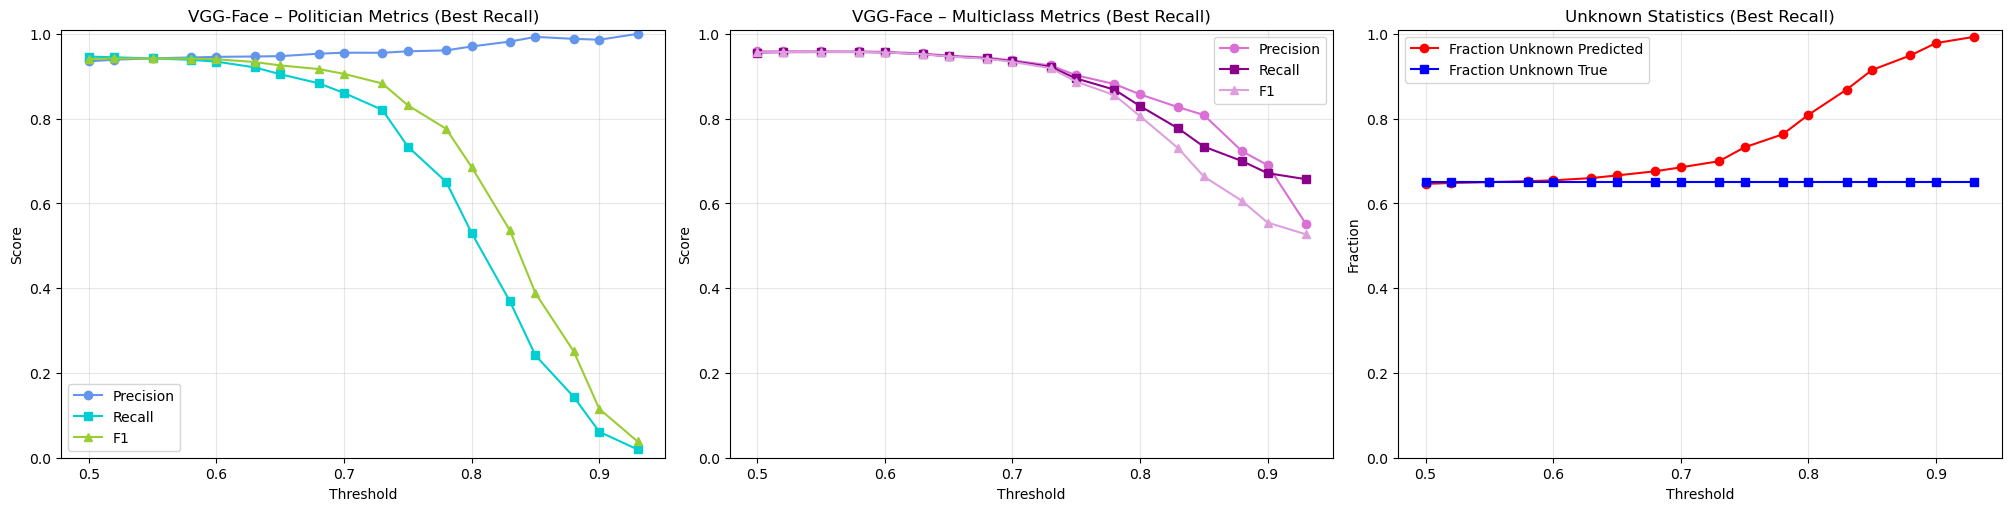

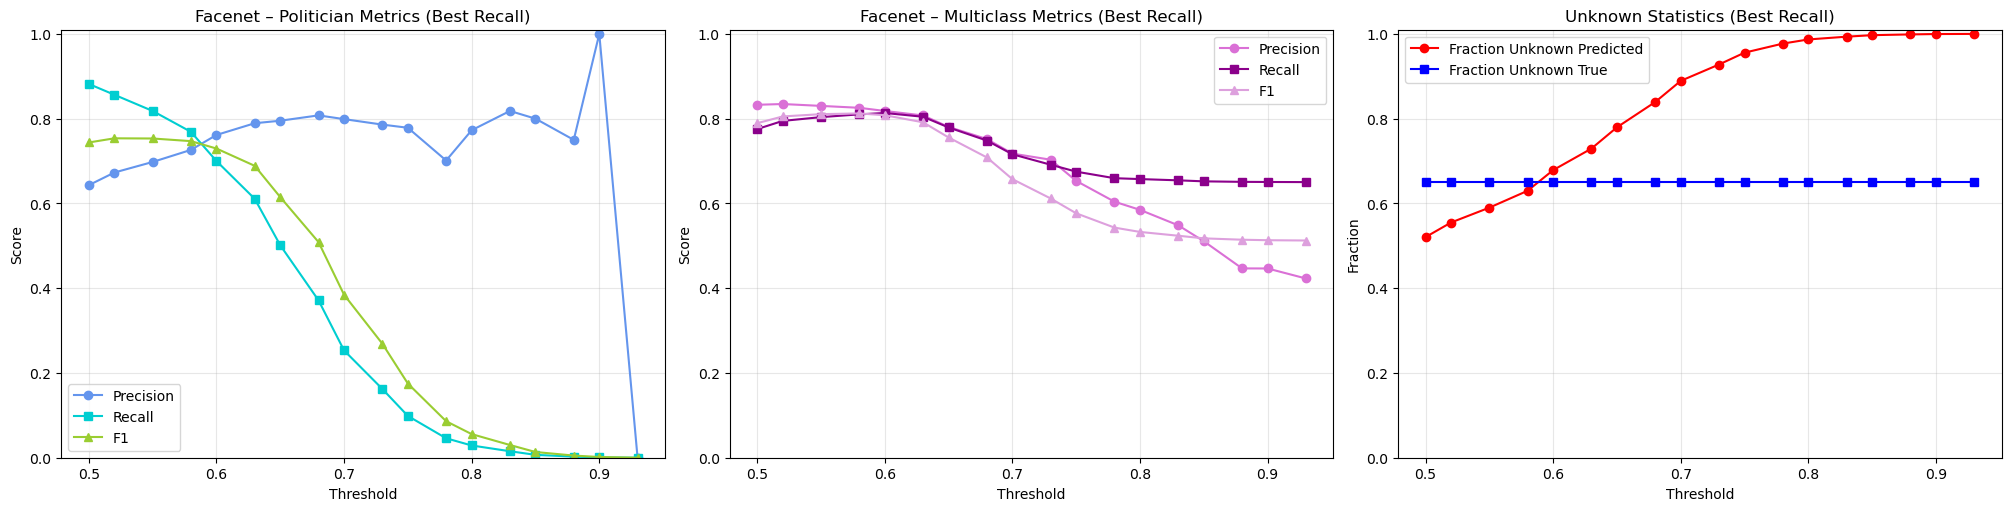

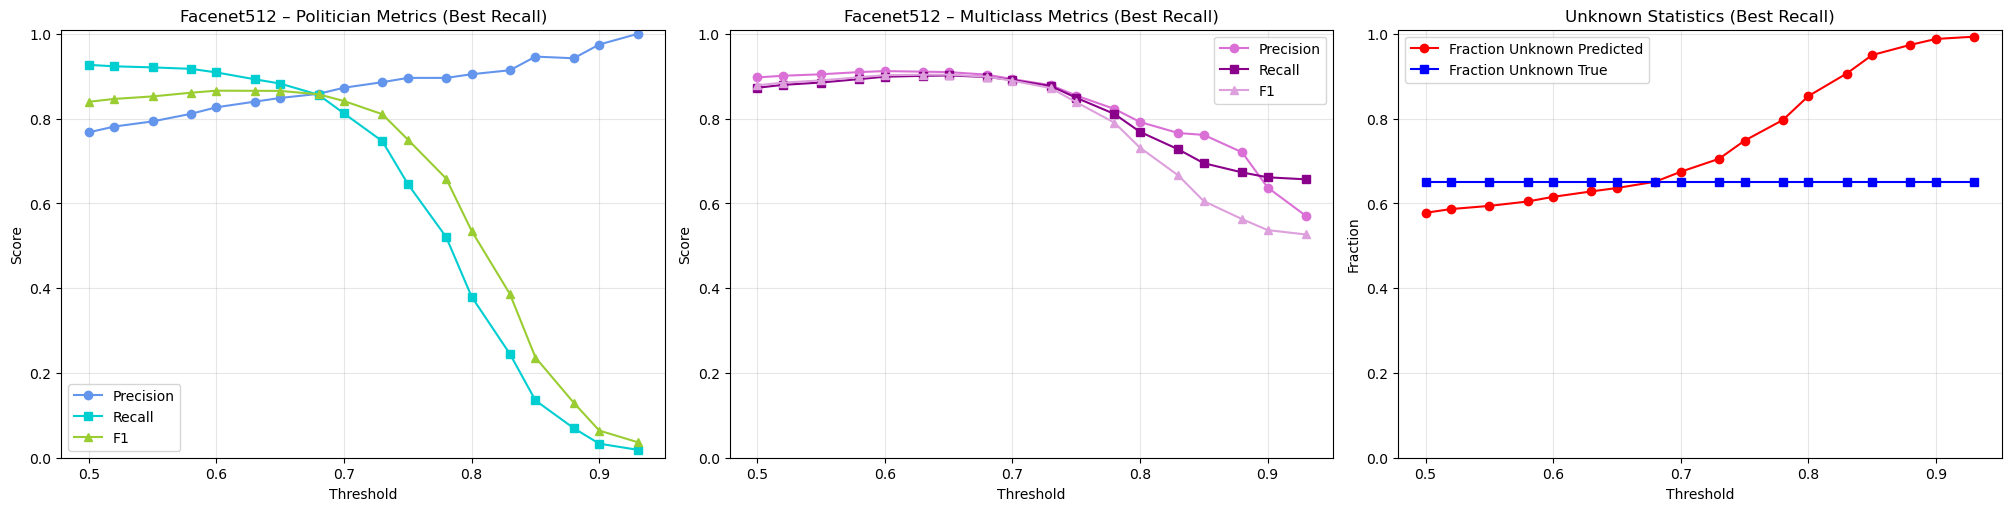

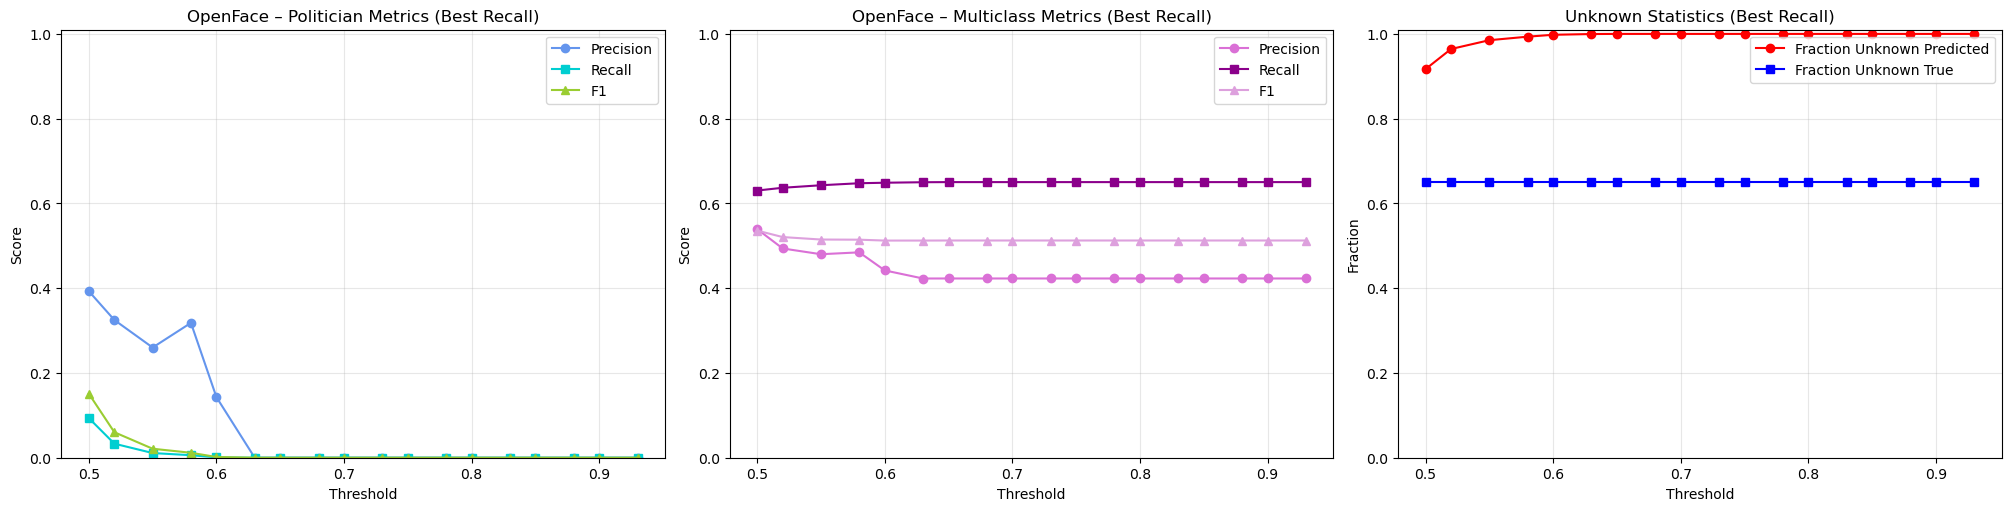

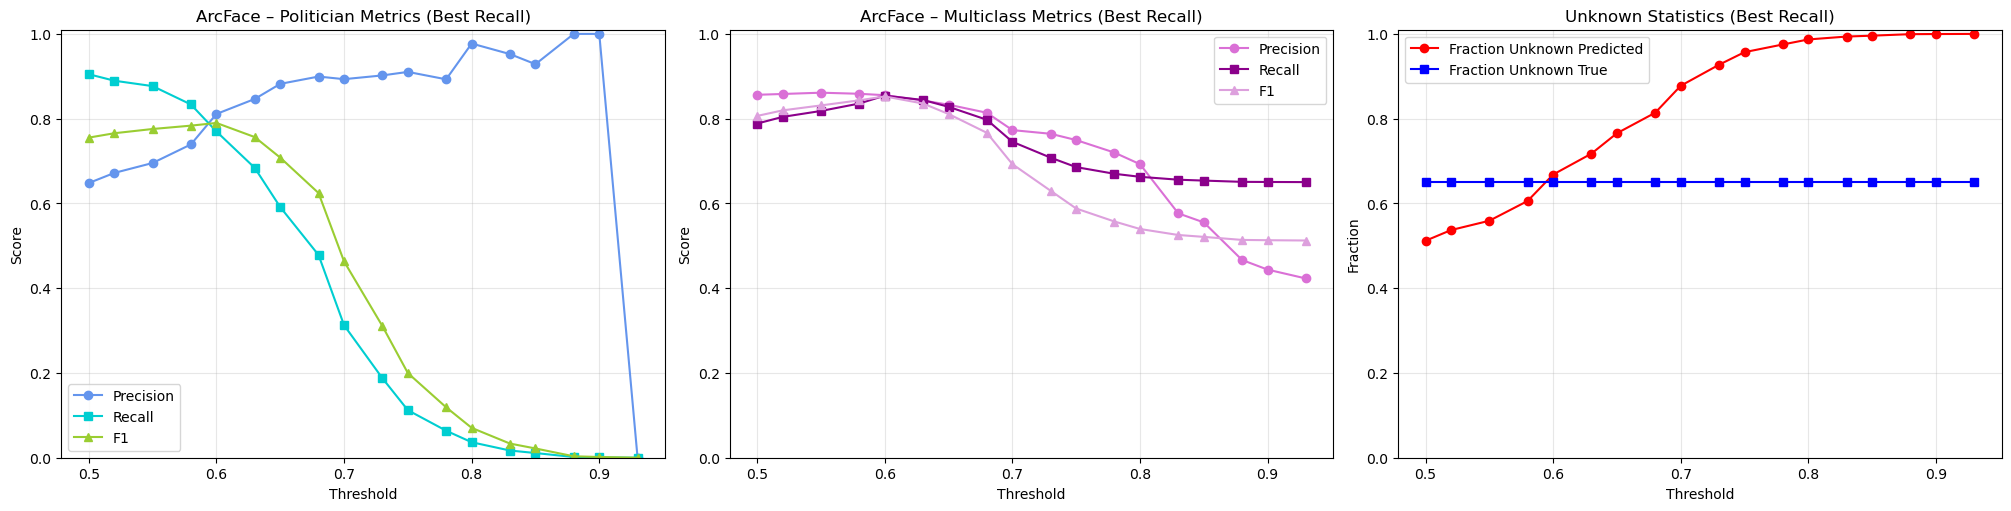

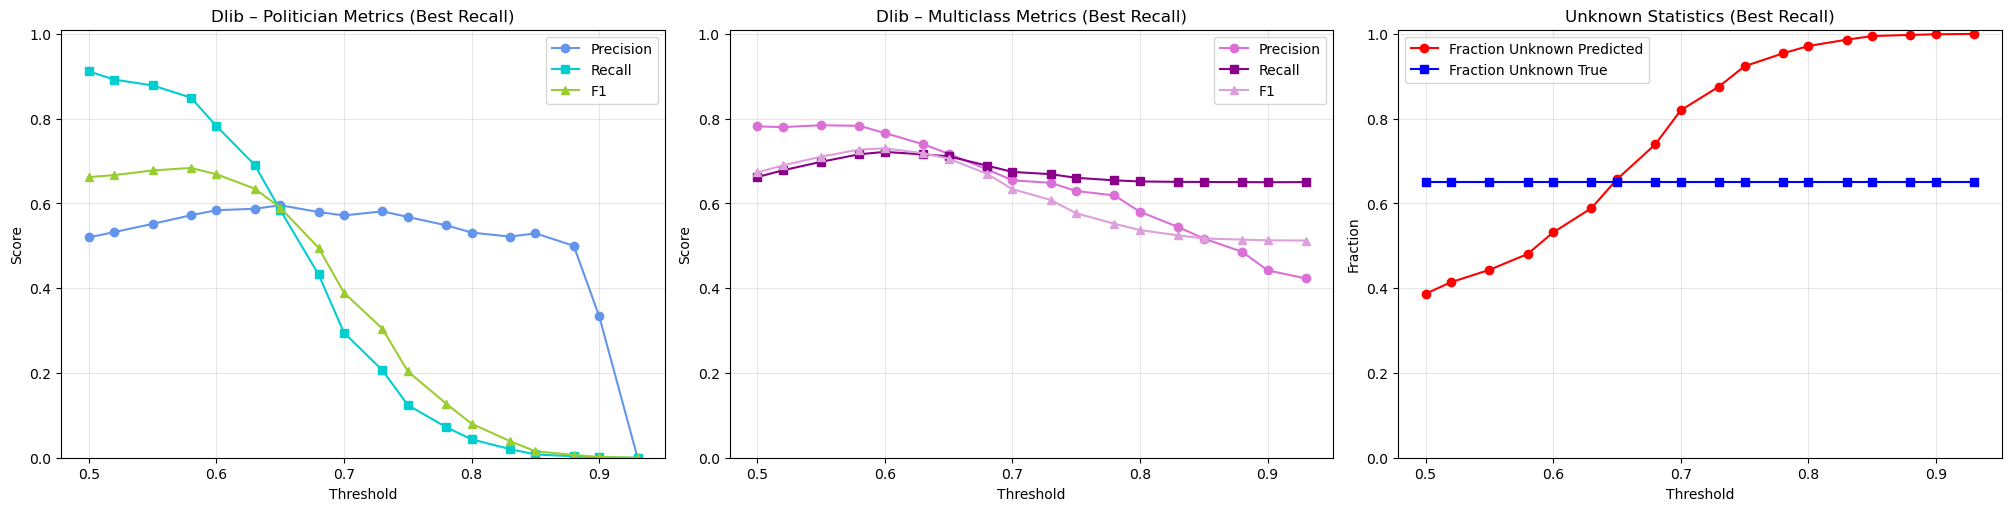

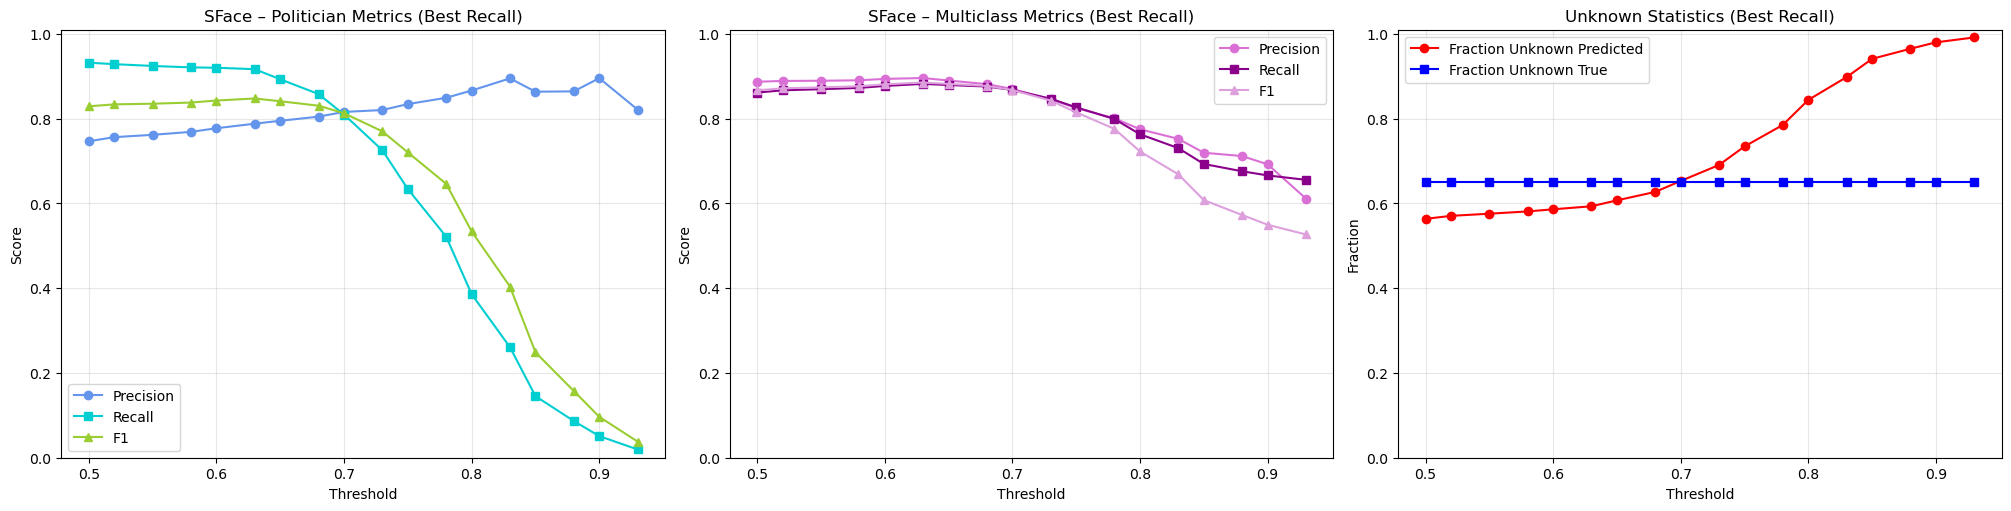

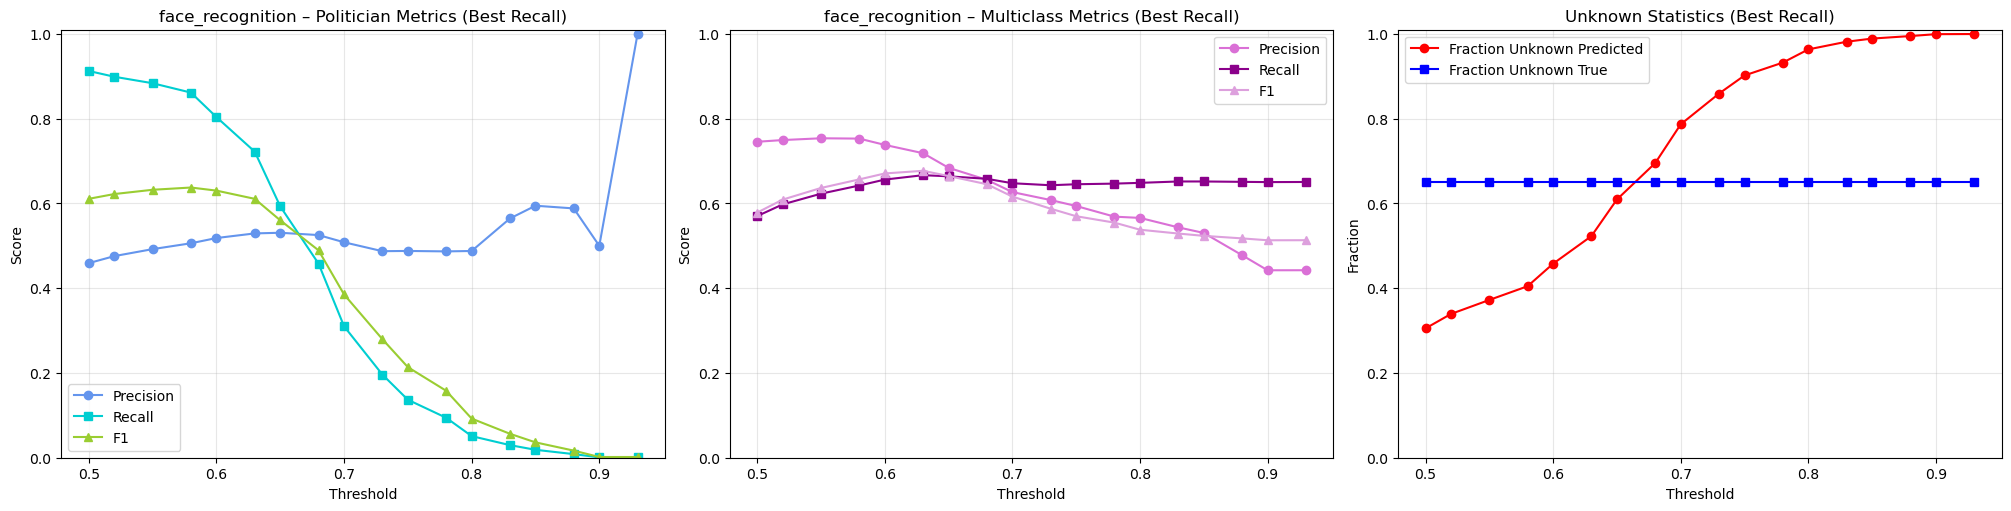

In [173]:
## UK ##
for embedder in uk_results_df['embedder'].unique():
    debug_plot(uk_results_df, embedder)

#### Calibrated probabilities, margin threshold, StandardScaler()

In [181]:
PARAM_GRID = {                            # Exploration of variables for gridsearch
    'C': [0.01, 0.1, 1, 10],                    # Regularization: small C yields a soft margin and a simple model, large C yields a hard margin and a complex model
    'gamma': ['scale', 'auto'],           # Gamma: 
    'class_weight': [None, 'balanced'],   # Unbalanced training data benefits from 'balanced' weights as it adjusts weights inversely proportional to class frequencies
    'kernel': ['rbf']                     # Type of transformation applied to the input data; Gaussian; for non-linear problems
}

PROBA_THRESHOLDS = np.arange(0.50, 0.95, 0.025) # range [0.5 (model is 50% sure) to 0.95 (model is 95% sure)]
UNKNOWN_LABEL = 99

In [188]:
# --- step 1 ---
def find_best_svm_params(X_train, y_train, X_dev, y_dev, param_grid):
    best_score = -1
    best_params = None
    for params in ParameterGrid(param_grid):
        model = SVC(**params, probability=True, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_dev)
        score = f1_score(y_dev, y_pred, average='weighted', zero_division=0)
        if score > best_score:
            best_score = score
            best_params = params
    return best_params

# --- step 2 ---
def compute_margin_thresholds(base_model, X_dev_politicians, percentiles=[1, 2, 5, 10]):
    decision_scores = base_model.decision_function(X_dev_politicians)
    if decision_scores.ndim == 1:  # binary case
        decision_scores = np.vstack([-decision_scores, decision_scores]).T
    max_margins = decision_scores.max(axis=1)
    thresholds = np.percentile(max_margins, percentiles).tolist()
    return thresholds

# --- step 3 ---
def evaluate_thresholds(base_model, calibrated_model, X_test, y_test, margin_thresholds, unknown_label):
    results = []
    
    # Use the scaled data for all predictions
    probas = calibrated_model.predict_proba(X_test)
    max_probas = probas.max(axis=1)
    predicted_classes = calibrated_model.classes_[probas.argmax(axis=1)]
    
    decision_scores = base_model.decision_function(X_test)
    if decision_scores.ndim == 1:  # binary case
        decision_scores = np.vstack([-decision_scores, decision_scores]).T
    max_margins = decision_scores.max(axis=1)
    
    for margin_t in margin_thresholds:
        y_pred = predicted_classes.copy()
        is_unknown = (max_margins < margin_t)
        y_pred[is_unknown] = unknown_label

        # ... [rest of the function remains unchanged] ...
        # Counts
        n_politician_true = np.sum(y_test != unknown_label)
        n_politician_pred = np.sum(y_pred != unknown_label)
        n_unknown_true = np.sum(y_test == unknown_label)
        n_unknown_pred = np.sum(y_pred == unknown_label)
        frac_unknown_pred = n_unknown_pred / len(y_pred)
        frac_unknown_true = n_unknown_true / len(y_test)

        metrics = {
            'margin_threshold': np.round(margin_t, 2),
            'politician_f1': f1_score(y_test != unknown_label, y_pred != unknown_label, zero_division=0),
            'politician_precision': precision_score(y_test != unknown_label, y_pred != unknown_label, zero_division=0),
            'politician_recall': recall_score(y_test != unknown_label, y_pred != unknown_label, zero_division=0),
            'unknown_f1': f1_score(y_test == unknown_label, y_pred == unknown_label, zero_division=0),
            'unknown_precision': precision_score(y_test == unknown_label, y_pred == unknown_label, zero_division=0),
            'unknown_recall': recall_score(y_test == unknown_label, y_pred == unknown_label, zero_division=0),
            'multiclass_f1': f1_score(y_test, y_pred, average='weighted', zero_division=0),
            'multiclass_precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
            'multiclass_recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
            'n_politician_true': n_politician_true,
            'n_politician_pred': n_politician_pred,
            'n_unknown_true': n_unknown_true,
            'n_unknown_pred': n_unknown_pred,
            'frac_unknown_pred': frac_unknown_pred,
            'frac_unknown_true': frac_unknown_true,
            'mean_max_prob': np.mean(max_probas),
            'median_max_prob': np.median(max_probas)
        }
        results.append(metrics)
    return results

# --- step 4 ---
def evaluate_models_two_stage(country_data, countries, param_grid, embedders,unknown_label):
    all_results = []

    for country in countries:
        for embedder_name in embedders:
            print(f'Country {country} - embedder {embedder_name} - compute best parameter configurations')
            if embedder_name not in country_data[country]['embedders']:
                continue
            
            try:
                X_train = np.vstack(country_data[country]['embedders'][embedder_name]['train']['X'])
                y_train = np.array(country_data[country]['embedders'][embedder_name]['train']['y'])
                X_dev = np.vstack(country_data[country]['embedders'][embedder_name]['dev']['X'])
                y_dev = np.array(country_data[country]['embedders'][embedder_name]['dev']['y'])
                X_test = np.vstack(country_data[country]['embedders'][embedder_name]['test']['X'])
                y_test = np.array(country_data[country]['embedders'][embedder_name]['test']['y'])

                dev_politician_mask = (y_dev != unknown_label)
                X_dev_politicians = X_dev[dev_politician_mask]
                y_dev_politicians = y_dev[dev_politician_mask]

                if X_train.shape[0] == 0 or X_dev_politicians.shape[0] == 0:
                    print(f"Skipping {country}-{embedder_name}: not enough politician data")
                    continue

                # Stage 1: Hyperparameter tuning
                best_params = find_best_svm_params(X_train, y_train, X_dev_politicians, y_dev_politicians, param_grid)

                base_model = SVC(**best_params, probability=True, random_state=42)
                base_model.fit(X_train, y_train)

                calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid', cv=3)
                calibrated_model.fit(X_train, y_train)

                # Stage 2: Data-driven margin thresholds
                margin_thresholds = compute_margin_thresholds(base_model, X_dev_politicians)

                # Stage 3: Evaluate thresholds on test set
                threshold_results = evaluate_thresholds(
                    base_model, calibrated_model,
                    X_test, y_test,
                    margin_thresholds,
                    unknown_label
                )

                # Store results
                for r in threshold_results:
                    r.update({
                        'country': country,
                        'embedder': embedder_name,
                        'params': str(best_params),
                        'C': best_params.get('C', None),
                        'gamma': best_params.get('gamma', None),
                        'class_weight': best_params.get('class_weight', None),
                        'kernel': best_params.get('kernel', None)
                    })
                    all_results.append(r)

            except Exception as e:
                print(f"ERROR {country}-{embedder_name}: {e}")
                continue

    if not all_results:
        return pd.DataFrame()

    df = pd.DataFrame(all_results)

    cols_order = ['country','embedder','margin_threshold', 'params','C','gamma','class_weight','kernel',
                  'politician_f1','politician_precision','politician_recall',
                  'unknown_f1','unknown_precision','unknown_recall',
                  'multiclass_f1','multiclass_precision','multiclass_recall',
                  'n_politician_true','n_politician_pred','n_unknown_true','n_unknown_pred',
                  'frac_unknown_pred','frac_unknown_true','mean_max_prob','median_max_prob']
    df = df[cols_order]
    return df

In [190]:
nl_test_results_df = evaluate_models_two_stage(country_data, ['NL'], PARAM_GRID, embedding_models, UNKNOWN_LABEL)
#uk_test_results_df = evaluate_models_two_stage(country_data, ['UK'], PARAM_GRID, embedding_models, PROBA_THRESHOLDS, UNKNOWN_LABEL)

Country NL - embedder VGG-Face - compute best parameter configurations
Country NL - embedder Facenet - compute best parameter configurations
Country NL - embedder Facenet512 - compute best parameter configurations
Country NL - embedder OpenFace - compute best parameter configurations
Country NL - embedder ArcFace - compute best parameter configurations
Country NL - embedder Dlib - compute best parameter configurations
Country NL - embedder SFace - compute best parameter configurations
Country NL - embedder face_recognition - compute best parameter configurations


In [191]:
def debug_plot_margin(df, embedder_name):
    # Filter for the specific embedder
    df_embed = df[df['embedder'] == embedder_name]
    
    # For each prob_threshold, find the row with highest politician_recall
    best_rows = df_embed.loc[df_embed.groupby('margin_threshold')['politician_recall'].idxmax()]
    best_rows = best_rows.sort_values('margin_threshold')
    
    # Create a row of 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)
    
    # --- [0] Politician metrics
    ax = axes[0]
    ax.plot(best_rows['margin_threshold'], best_rows['politician_precision'], 'o-', label='Precision', color='cornflowerblue')
    ax.plot(best_rows['margin_threshold'], best_rows['politician_recall'], 's-', label='Recall', color='darkturquoise')
    ax.plot(best_rows['margin_threshold'], best_rows['politician_f1'], '^-', label='F1', color='yellowgreen')
    ax.set_title(f'{embedder_name} – Politician Metrics (Best Recall)')
    ax.set_ylabel("Score")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # --- [1] Multiclass metrics
    ax = axes[1]
    ax.plot(best_rows['margin_threshold'], best_rows['multiclass_precision'], 'o-', label='Precision', color='orchid')
    ax.plot(best_rows['margin_threshold'], best_rows['multiclass_recall'], 's-', label='Recall', color='darkmagenta')
    ax.plot(best_rows['margin_threshold'], best_rows['multiclass_f1'], '^-', label='F1', color='plum')
    ax.set_title(f'{embedder_name} – Multiclass Metrics (Best Recall)')
    ax.set_ylabel("Score")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # --- [2] Unknown statistics
    ax = axes[2]
    ax.plot(best_rows['margin_threshold'], best_rows['frac_unknown_pred'], 'o-', label='Fraction Unknown Predicted', color='red')
    ax.plot(best_rows['margin_threshold'], best_rows['frac_unknown_true'], 's-', label='Fraction Unknown True', color='blue')
    ax.set_title('Unknown Statistics (Best Recall)')
    ax.set_ylabel("Fraction")
    ax.set_xlabel("Threshold")
    ax.set_ylim(0.0, 1.01)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.show()

In [201]:
nl_test_results_df['margin_threshold'].value_counts()

margin_threshold
16.31    15
16.30     7
15.31     6
16.29     2
15.30     1
15.32     1
Name: count, dtype: int64

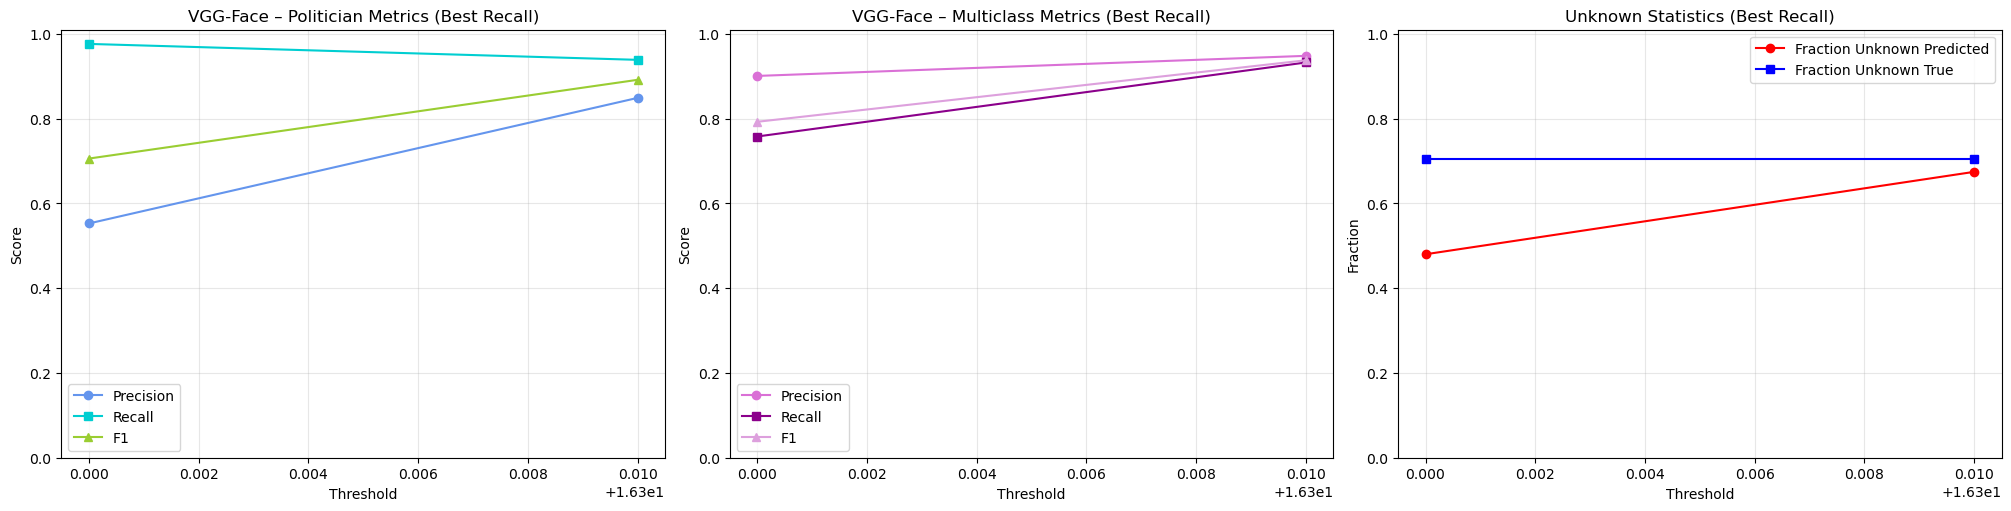

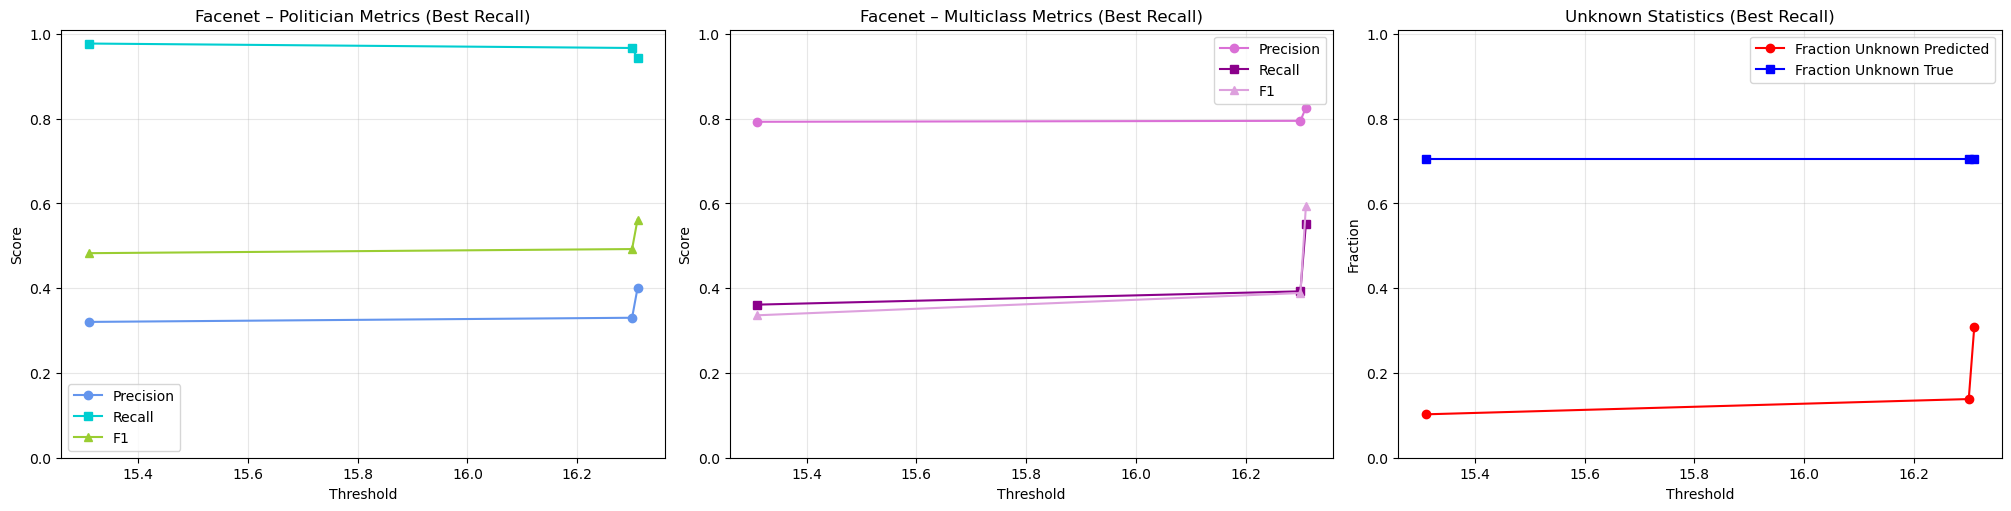

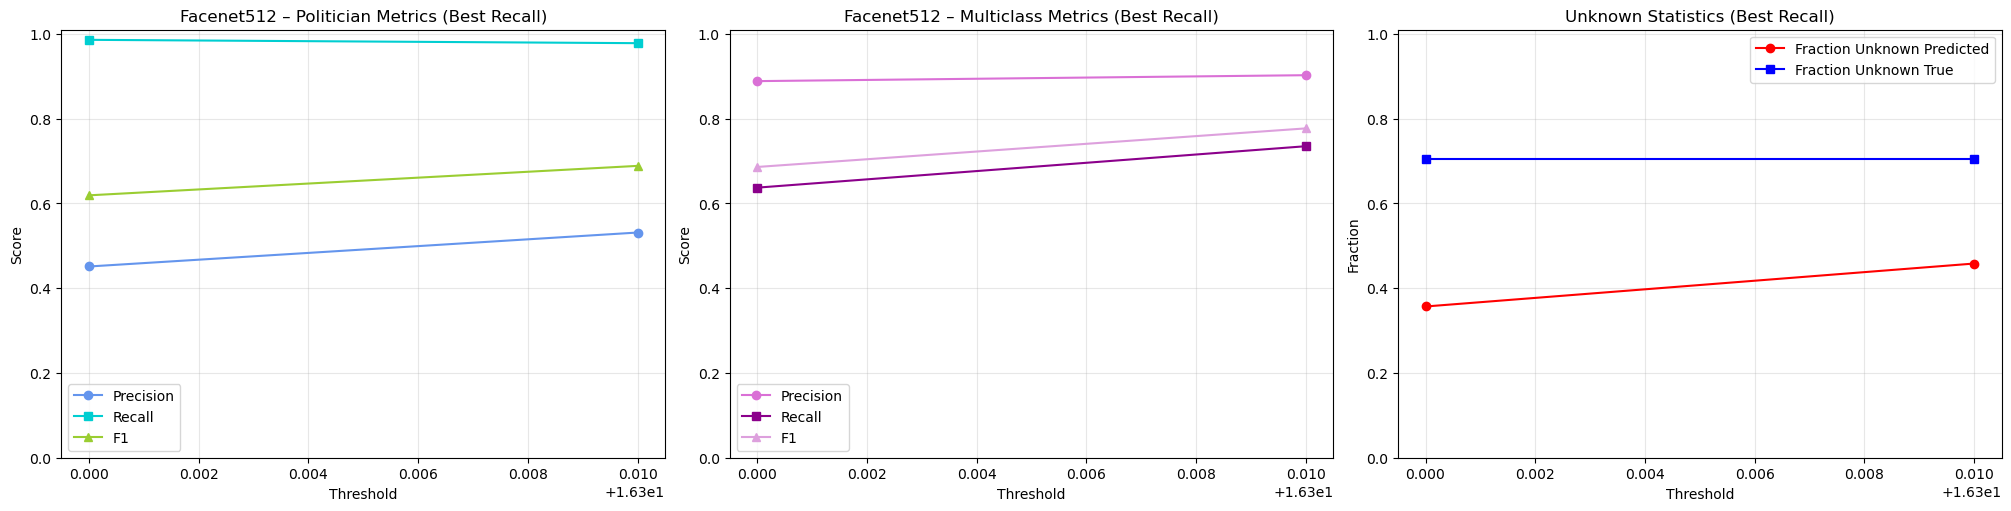

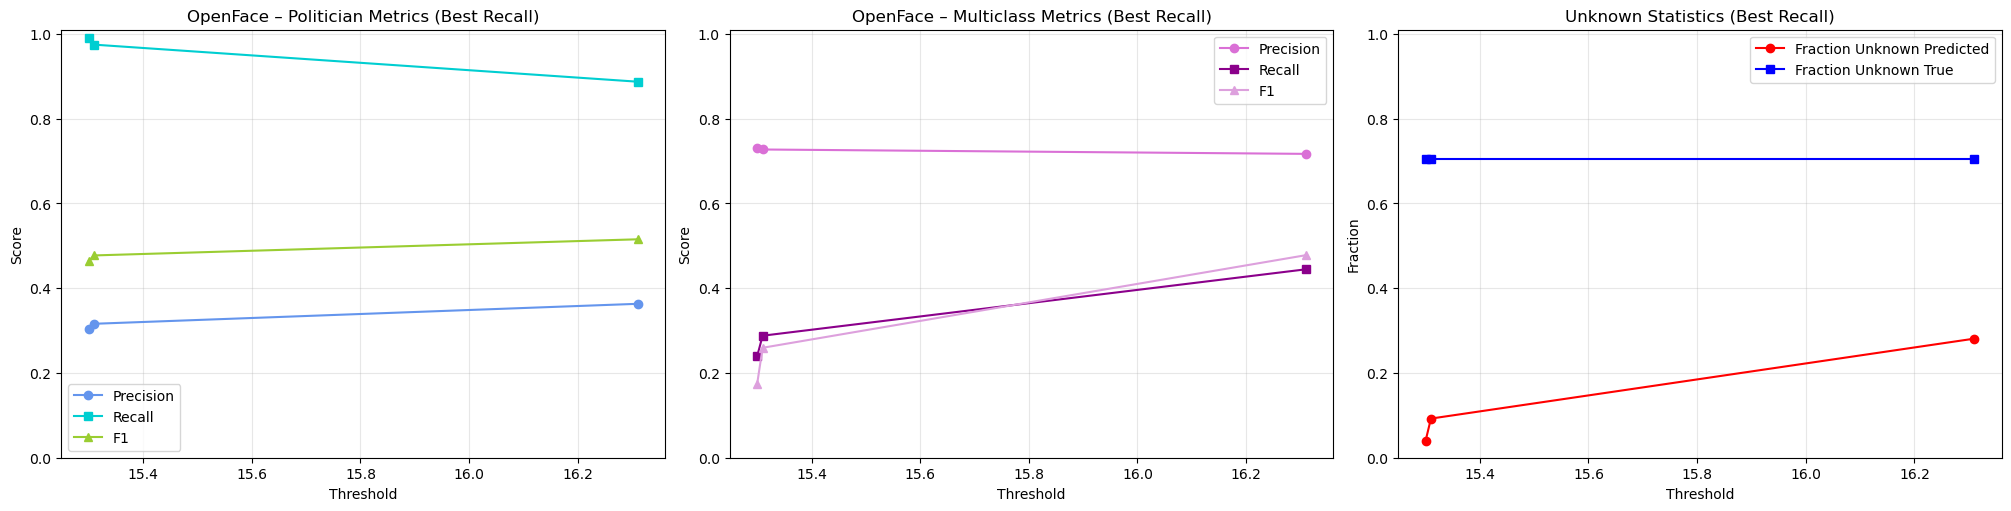

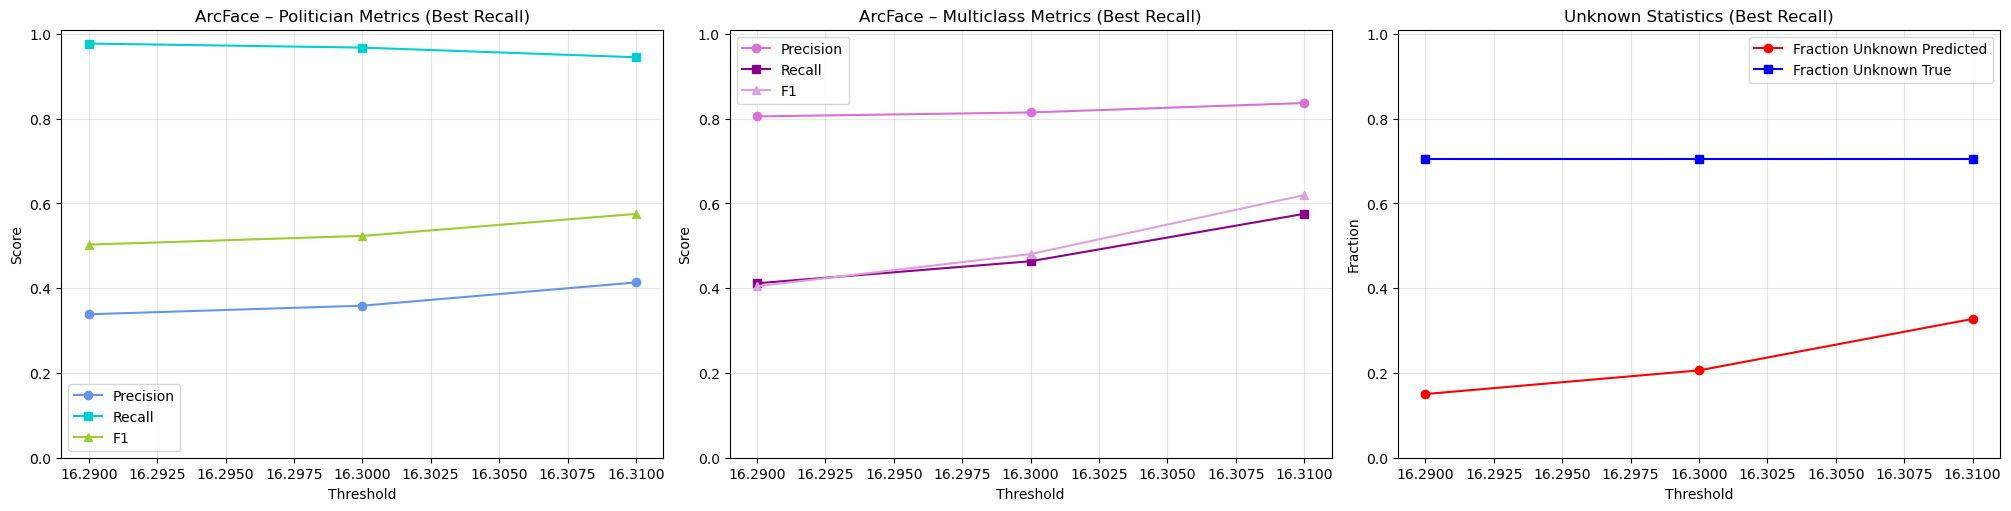

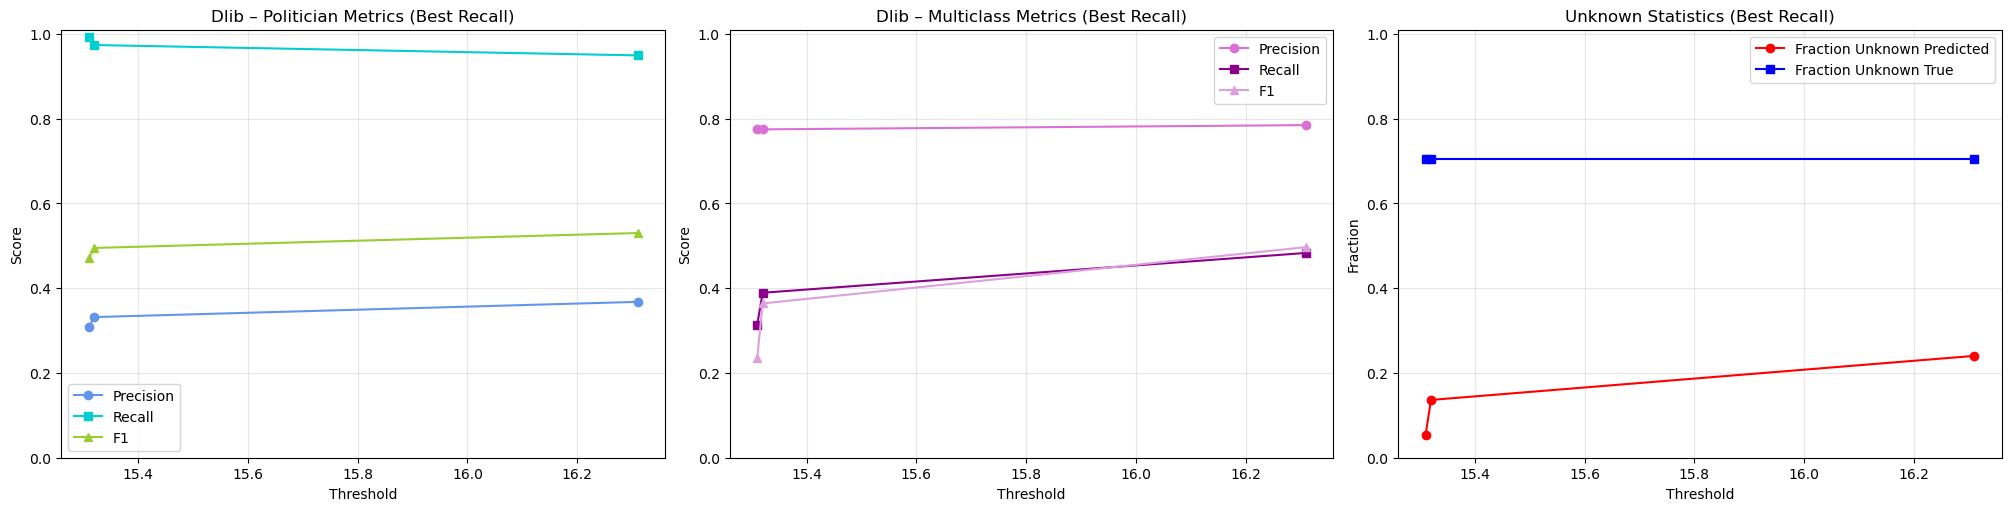

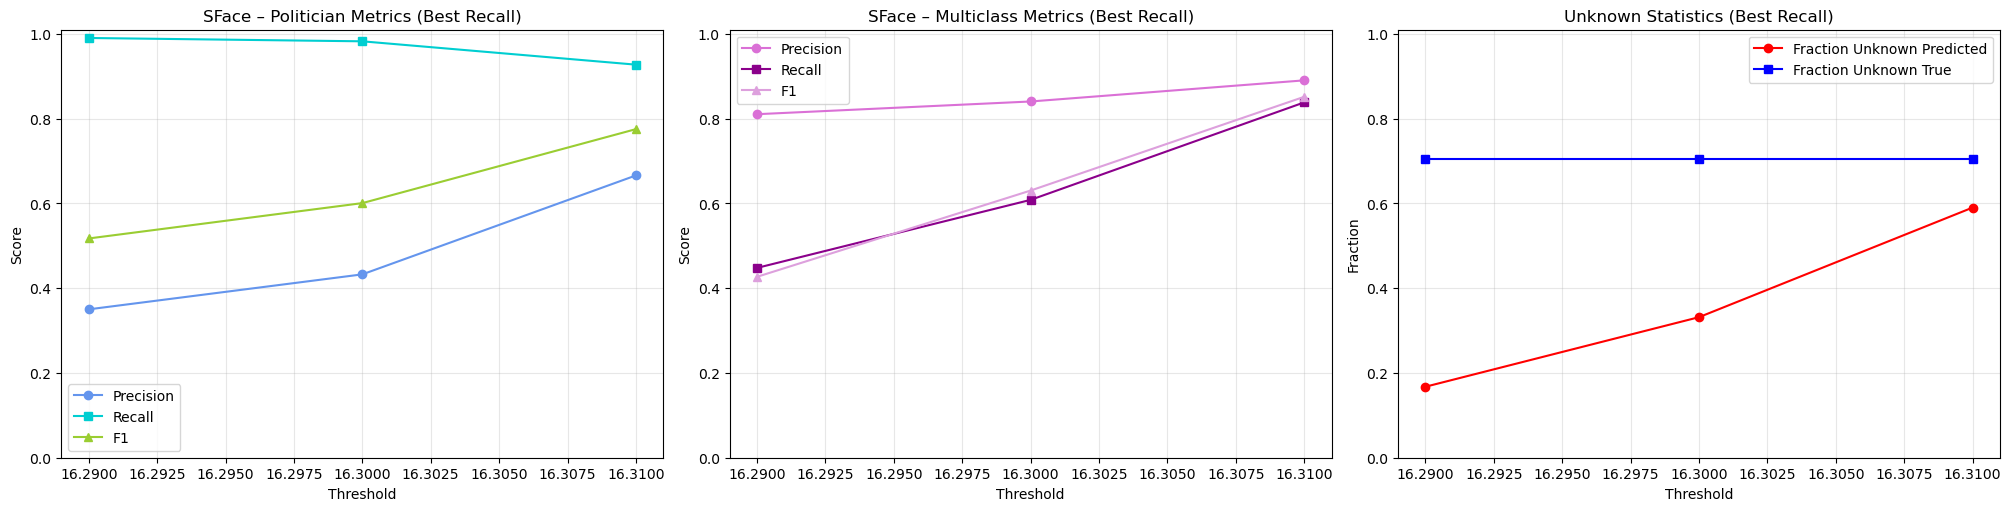

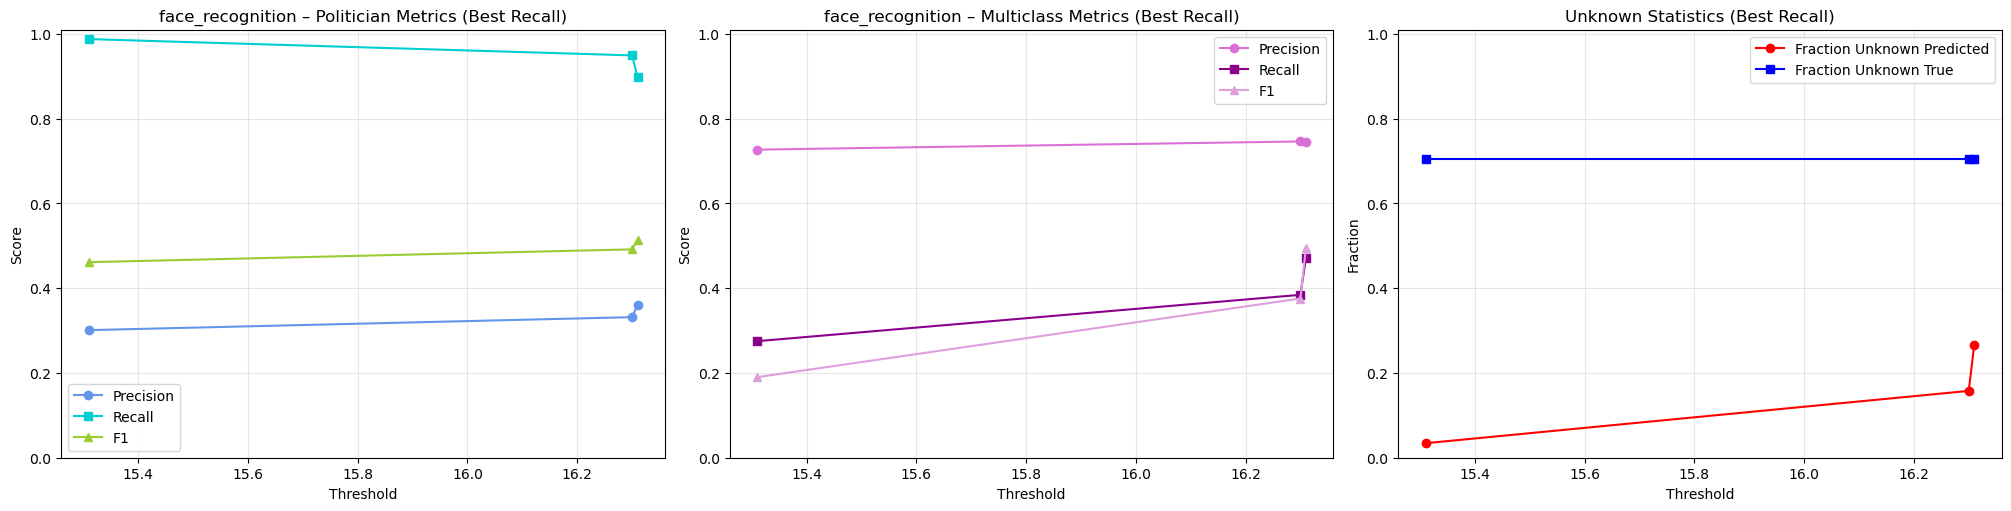

In [194]:
## NL ##
for embedder in nl_test_results_df['embedder'].unique():
    debug_plot_margin(nl_test_results_df, embedder)

In [198]:
pd.options.display.max_columns = None

In [ ]:
nl_test_results_df[margin]

country          embedder  margin_threshold  \
27      NL             SFace             16.31   
3       NL          VGG-Face             16.31   
15      NL          OpenFace             16.31   
23      NL              Dlib             16.31   
19      NL           ArcFace             16.31   
..     ...               ...               ...   
8       NL        Facenet512             16.30   
28      NL  face_recognition             15.31   
24      NL             SFace             16.29   
12      NL          OpenFace             15.30   
20      NL              Dlib             15.31   

                                               params   C  gamma class_weight  \
27  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
3   {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
15  {'C': 10, 'class_weight': 'balanced', 'gamma':...  10  scale     balanced   
23  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
19  {'C': 10, 'class_weight': 'balanced', 'gamma':...  10  scale     balanced   
..                                                ...  ..    ...          ...   
8   {'C': 1, 'class_weight': 'balanced', 'gamma': ...   1  scale     balanced   
28  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
24  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
12  {'C': 10, 'class_weight': 'balanced', 'gamma':...  10  scale     balanced   
20  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   

   kernel  politician_f1  politician_precision  politician_recall  unknown_f1  \
27    rbf       0.825291              0.787302           0.867133    0.921788   
3     rbf       0.917839              0.954674           0.883741    0.967510   
15    rbf       0.515359              0.363148           0.887238    0.502216   
23    rbf       0.586844              0.437984           0.888986    0.667595   
19    rbf       0.676159              0.544243           0.892483    0.794279   
..    ...            ...                   ...                ...         ...   
8     rbf       0.619100              0.451200           0.986014    0.663923   
28    rbf       0.461413              0.301012           0.987762    0.082754   
24    rbf       0.517352              0.350124           0.990385    0.377136   
12    rbf       0.464439              0.303347           0.990385    0.097409   
20    rbf       0.470466              0.308340           0.992133    0.133605   

    unknown_precision  unknown_recall  multiclass_f1  multiclass_precision  \
27           0.942139        0.902297       0.894701              0.904781   
3            0.952970        0.982501       0.952785              0.953969   
15           0.881868        0.351075       0.477901              0.716946   
23           0.918850        0.524244       0.647995              0.793382   
19           0.938836        0.688297       0.776808              0.862242   
..                ...             ...            ...                   ...   
8            0.988464        0.499818       0.686045              0.888582   
28           0.894737        0.043383       0.190056              0.726930   
24           0.983103        0.233321       0.426910              0.810549   
12           0.927632        0.051404       0.174298              0.729719   
20           0.956311        0.071819       0.234675              0.775322   

    multiclass_recall  n_politician_true  n_politician_pred  n_unknown_true  \
27           0.890147               1144               1260            2743   
3            0.953177               1144               1059            2743   
15           0.444559               1144               2795            2743   
23           0.616671               1144               2322            2743   
19           0.740931               1144               1876            2743   
..                ...                ...     

#### Per-class thresholding (no scaling)

In [203]:
def tune_per_class_thresholds(model, X_dev, y_dev, candidate_thresholds, unknown_label):
    """
    Learn a per-class threshold for rejecting low-confidence predictions.
    """
    probas = model.predict_proba(X_dev)
    classes = model.classes_
    thresholds = {}

    for i, c in enumerate(classes):
        best_f1, best_tau = -1, 0.5
        for tau in candidate_thresholds:
            preds = []
            for row in probas:
                if row[i] >= tau and np.argmax(row) == i:
                    preds.append(c)
                else:
                    preds.append(unknown_label)
            # binary evaluation: class c vs rest
            y_true = (y_dev == c).astype(int)
            y_pred = (np.array(preds) == c).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_tau = f1, tau
        thresholds[c] = best_tau

    return thresholds

def predict_with_per_class_thresholds(model, X, thresholds, unknown_label):
    """
    Predict labels using per-class thresholds.
    """
    probas = model.predict_proba(X)
    classes = model.classes_
    preds = []
    for row in probas:
        best_idx = np.argmax(row)
        best_class = classes[best_idx]
        if row[best_idx] >= thresholds.get(best_class, 0.5):
            preds.append(best_class)
        else:
            preds.append(unknown_label)
    return np.array(preds)


def evaluate_predictions(y_true, y_pred, probas, unknown_label, margin_threshold=None):
    """
    Compute evaluation metrics in a consistent dict.
    """
    is_actually_politician = (y_true != unknown_label)
    is_predicted_politician = (y_pred != unknown_label)
    is_actually_unknown = (y_true == unknown_label)
    is_predicted_unknown = (y_pred == unknown_label)

    max_probas = probas.max(axis=1)

    return {
        'margin_threshold': margin_threshold,
        # Politician detection metrics
        'politician_f1': f1_score(is_actually_politician, is_predicted_politician, zero_division=0),
        'politician_precision': precision_score(is_actually_politician, is_predicted_politician, zero_division=0),
        'politician_recall': recall_score(is_actually_politician, is_predicted_politician, zero_division=0),
        # Unknown detection metrics
        'unknown_f1': f1_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        'unknown_precision': precision_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        'unknown_recall': recall_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        # Multiclass metrics
        'multiclass_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'multiclass_precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'multiclass_recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        # Summary statistics
        'n_politician_true': sum(is_actually_politician),
        'n_politician_pred': sum(is_predicted_politician),
        'n_unknown_true': sum(is_actually_unknown),
        'n_unknown_pred': sum(is_predicted_unknown),
        'frac_unknown_pred': sum(is_predicted_unknown) / len(y_true) if len(y_true) > 0 else 0,
        'frac_unknown_true': sum(is_actually_unknown) / len(y_true) if len(y_true) > 0 else 0,
        'mean_max_prob': np.mean(max_probas),
        'median_max_prob': np.median(max_probas)
    }

def evaluate_models_two_stage(country_data, countries, param_grid, embedders, unknown_label,
                              candidate_thresholds=np.linspace(0.3, 0.95, 20)):
    """
    Train + calibrate SVM per embedder, tune per-class thresholds, and evaluate.
    """
    all_results = []

    for country in countries:
        for embedder_name in embedders:
            print(f'Country {country} - embedder {embedder_name}')

            if embedder_name not in country_data[country]['embedders']:
                continue

            try:
                X_train = np.vstack(country_data[country]['embedders'][embedder_name]['train']['X'])
                y_train = np.array(country_data[country]['embedders'][embedder_name]['train']['y'])
                X_dev = np.vstack(country_data[country]['embedders'][embedder_name]['dev']['X'])
                y_dev = np.array(country_data[country]['embedders'][embedder_name]['dev']['y'])
                X_test = np.vstack(country_data[country]['embedders'][embedder_name]['test']['X'])
                y_test = np.array(country_data[country]['embedders'][embedder_name]['test']['y'])

                # filter out unknowns for tuning the classifier
                dev_politician_mask = (y_dev != unknown_label)
                X_dev_politicians = X_dev[dev_politician_mask]
                y_dev_politicians = y_dev[dev_politician_mask]

                if X_train.shape[0] == 0 or X_dev_politicians.shape[0] == 0:
                    print(f"Skipping {country}-{embedder_name}: not enough politician data")
                    continue

                # Stage 1: Hyperparameter tuning
                best_params = find_best_svm_params(
                    X_train, y_train,
                    X_dev_politicians, y_dev_politicians,
                    param_grid
                )
                print(f"Best params: {best_params}")

                # Train calibrated model
                base_model = SVC(**best_params, probability=True, random_state=42)
                base_model.fit(X_train, y_train)
                final_model = CalibratedClassifierCV(base_model, method='sigmoid', cv=3)
                final_model.fit(X_train, y_train)

                # Stage 2: Tune per-class thresholds
                per_class_thresholds = tune_per_class_thresholds(
                    final_model, X_dev, y_dev, candidate_thresholds, unknown_label
                )

                # Predictions on dev
                y_dev_pred = predict_with_per_class_thresholds(final_model, X_dev, per_class_thresholds, unknown_label)
                dev_probas = final_model.predict_proba(X_dev)
                dev_metrics = evaluate_predictions(y_dev, y_dev_pred, dev_probas, unknown_label)
                dev_metrics.update({
                    'country': country,
                    'embedder': embedder_name,
                    'params': str(best_params),
                    'C': best_params.get('C', None),
                    'gamma': best_params.get('gamma', None),
                    'class_weight': best_params.get('class_weight', None),
                    'kernel': best_params.get('kernel', None),
                    'split': 'dev'
                })
                all_results.append(dev_metrics)

                # Predictions on test
                y_test_pred = predict_with_per_class_thresholds(final_model, X_test, per_class_thresholds, unknown_label)
                test_probas = final_model.predict_proba(X_test)
                test_metrics = evaluate_predictions(y_test, y_test_pred, test_probas, unknown_label)
                test_metrics.update({
                    'country': country,
                    'embedder': embedder_name,
                    'params': str(best_params),
                    'C': best_params.get('C', None),
                    'gamma': best_params.get('gamma', None),
                    'class_weight': best_params.get('class_weight', None),
                    'kernel': best_params.get('kernel', None),
                    'split': 'test'
                })
                all_results.append(test_metrics)

            except Exception as e:
                print(f"ERROR {country}-{embedder_name}: {e}")
                continue

    if not all_results:
        return pd.DataFrame()

    df = pd.DataFrame(all_results)

    cols_order = ['country','embedder','split','margin_threshold','params','C','gamma','class_weight','kernel',
                  'politician_f1','politician_precision','politician_recall',
                  'unknown_f1','unknown_precision','unknown_recall',
                  'multiclass_f1','multiclass_precision','multiclass_recall',
                  'n_politician_true','n_politician_pred','n_unknown_true','n_unknown_pred',
                  'frac_unknown_pred','frac_unknown_true','mean_max_prob','median_max_prob']
    existing_cols = [c for c in cols_order if c in df.columns]
    return df[existing_cols]


In [204]:
PARAM_GRID = {                            # Exploration of variables for gridsearch
    'C': [0.1, 1, 10],                    # Regularization: small C yields a soft margin and a simple model, large C yields a hard margin and a complex model
    'gamma': ['scale', 'auto'],           # Gamma: 
    'class_weight': [None, 'balanced'],   # Unbalanced training data benefits from 'balanced' weights as it adjusts weights inversely proportional to class frequencies
    'kernel': ['rbf']                     # Type of transformation applied to the input data; Gaussian; for non-linear problems
}

PROBA_THRESHOLDS = np.arange(0.50, 0.95, 0.025) # range [0.5 (model is 50% sure) to 0.95 (model is 95% sure)]
UNKNOWN_LABEL = 99

In [205]:
per_class_test = evaluate_models_two_stage(
    country_data, 
    ['NL'], 
    PARAM_GRID, 
    ['VGG-Face', 'Facenet512', 'Facenet'], 
    UNKNOWN_LABEL,
    candidate_thresholds=np.linspace(0.3, 0.95, 20))

Country NL - embedder VGG-Face
Best params: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Country NL - embedder Facenet512
Best params: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Country NL - embedder Facenet
Best params: {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}


In [206]:
per_class_test

country    embedder split margin_threshold  \
0      NL    VGG-Face   dev             None   
1      NL    VGG-Face  test             None   
2      NL  Facenet512   dev             None   
3      NL  Facenet512  test             None   
4      NL     Facenet   dev             None   
5      NL     Facenet  test             None   

                                              params   C  gamma class_weight  \
0  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
1  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
2  {'C': 1, 'class_weight': 'balanced', 'gamma': ...   1  scale     balanced   
3  {'C': 1, 'class_weight': 'balanced', 'gamma': ...   1  scale     balanced   
4  {'C': 10, 'class_weight': None, 'gamma': 'auto...  10   auto         None   
5  {'C': 10, 'class_weight': None, 'gamma': 'auto...  10   auto         None   

  kernel  politician_f1  politician_precision  politician_recall  unknown_f1  \
0    rbf       0.694390              0.594758           0.834119    0.850852   
1    rbf       0.685736              0.596253           0.806818    0.833530   
2    rbf       0.690989              0.563690           0.892554    0.831644   
3    rbf       0.677966              0.560962           0.856643    0.809339   
4    rbf       0.722760              0.652736           0.809614    0.877850   
5    rbf       0.713775              0.653818           0.785839    0.862797   

   unknown_precision  unknown_recall  multiclass_f1  multiclass_precision  \
0           0.926606        0.786549       0.811607              0.849572   
1           0.905515        0.772147       0.792511              0.826497   
2           0.948323        0.740531       0.800344              0.858385   
3           0.923364        0.720379       0.776621              0.831055   
4           0.921401        0.838230       0.834823              0.852130   
5           0.902468        0.826467       0.817833              0.833028   

   multiclass_recall  n_politician_true  n_politician_pred  n_unknown_true  \
0           0.798765               1061               1488            2825   
1           0.781837               1144               1548            2743   
2           0.780237               1061               1680            2825   
3           0.759197               1144               1747            2743   
4           0.825528               1061               1316            2825   
5           0.809622               1144               1375            2743   

   n_unknown_pred  frac_unknown_pred  frac_unknown_true  mean_max_prob  \
0            2398           0.617087           0.726969       0.724213   
1            2339           0.601749           0.705686       0.729727   
2            2206           0.567679           0.726969       0.692560   
3            2140           0.550553           0.705686       0.698518   
4            2570           0.661348           0.726969       0.561381   
5            2512           0.646257           0.705686       0.565294   

   median_max_prob  
0         0.753023  
1         0.765064  
2         0.705075  
3         0.716902  
4         0.560045  
5         0.562454

Returning per-class thresholds

In [223]:
def find_best_svm_params(X_train, y_train, X_dev, y_dev, param_grid):
    best_score = -1
    best_params = None
    for params in ParameterGrid(param_grid):
        model = SVC(**params, probability=True, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_dev)
        score = f1_score(y_dev, y_pred, average='weighted', zero_division=0)
        if score > best_score:
            best_score = score
            best_params = params
    return best_params

def tune_per_class_thresholds(model, X_dev, y_dev, candidate_thresholds, unknown_label):
    """
    Learn a per-class threshold for rejecting low-confidence predictions.
    """
    probas = model.predict_proba(X_dev)
    classes = model.classes_
    thresholds = {}

    for i, c in enumerate(classes):
        best_f1, best_tau = -1, 0.5
        for tau in candidate_thresholds:
            preds = []
            for row in probas:
                if row[i] >= tau and np.argmax(row) == i:
                    preds.append(c)
                else:
                    preds.append(unknown_label)
            # binary evaluation: class c vs rest
            y_true = (y_dev == c).astype(int)
            y_pred = (np.array(preds) == c).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_tau = f1, tau
        thresholds[c] = best_tau

    return thresholds

def predict_with_per_class_thresholds(model, X, thresholds, unknown_label):
    """
    Predict labels using per-class thresholds.
    """
    probas = model.predict_proba(X)
    classes = model.classes_
    preds = []
    for row in probas:
        best_idx = np.argmax(row)
        best_class = classes[best_idx]
        if row[best_idx] >= thresholds.get(best_class, 0.5):
            preds.append(best_class)
        else:
            preds.append(unknown_label)
    return np.array(preds)


def evaluate_predictions(y_true, y_pred, probas, unknown_label, margin_threshold=None):
    """
    Compute evaluation metrics in a consistent dict.
    """
    is_actually_politician = (y_true != unknown_label)
    is_predicted_politician = (y_pred != unknown_label)
    is_actually_unknown = (y_true == unknown_label)
    is_predicted_unknown = (y_pred == unknown_label)

    max_probas = probas.max(axis=1)

    return {
        'margin_threshold': margin_threshold,
        # Politician detection metrics
        'politician_f1': f1_score(is_actually_politician, is_predicted_politician, zero_division=0),
        'politician_precision': precision_score(is_actually_politician, is_predicted_politician, zero_division=0),
        'politician_recall': recall_score(is_actually_politician, is_predicted_politician, zero_division=0),
        # Unknown detection metrics
        'unknown_f1': f1_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        'unknown_precision': precision_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        'unknown_recall': recall_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        # Multiclass metrics
        'multiclass_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'multiclass_precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'multiclass_recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        # Summary statistics
        'n_politician_true': sum(is_actually_politician),
        'n_politician_pred': sum(is_predicted_politician),
        'n_unknown_true': sum(is_actually_unknown),
        'n_unknown_pred': sum(is_predicted_unknown),
        'frac_unknown_pred': sum(is_predicted_unknown) / len(y_true) if len(y_true) > 0 else 0,
        'frac_unknown_true': sum(is_actually_unknown) / len(y_true) if len(y_true) > 0 else 0,
        'mean_max_prob': np.mean(max_probas),
        'median_max_prob': np.median(max_probas)
    }

def evaluate_models_two_stage(country_data, countries, param_grid, embedders, unknown_label,
                              candidate_thresholds=np.linspace(0.35, 0.95, 20)):
    """
    Train + calibrate SVM per embedder, tune per-class thresholds, and evaluate.
    Returns:
        df_results: DataFrame with evaluation metrics
        all_thresholds: dict of {country: {embedder: {class: threshold}}}
    """
    all_results = []
    all_thresholds = {} 

    for country in countries:
        all_thresholds[country] = {}

        for embedder_name in embedders:
            print(f'Country {country} - embedder {embedder_name}')

            if embedder_name not in country_data[country]['embedders']:
                continue

            try:
                X_train = np.vstack(country_data[country]['embedders'][embedder_name]['train']['X'])
                y_train = np.array(country_data[country]['embedders'][embedder_name]['train']['y'])
                X_dev = np.vstack(country_data[country]['embedders'][embedder_name]['dev']['X'])
                y_dev = np.array(country_data[country]['embedders'][embedder_name]['dev']['y'])
                X_test = np.vstack(country_data[country]['embedders'][embedder_name]['test']['X'])
                y_test = np.array(country_data[country]['embedders'][embedder_name]['test']['y'])

                # filter out unknowns for tuning the classifier
                dev_politician_mask = (y_dev != unknown_label)
                X_dev_politicians = X_dev[dev_politician_mask]
                y_dev_politicians = y_dev[dev_politician_mask]

                if X_train.shape[0] == 0 or X_dev_politicians.shape[0] == 0:
                    print(f"Skipping {country}-{embedder_name}: not enough politician data")
                    continue

                # Stage 1: Hyperparameter tuning
                best_params = find_best_svm_params(
                    X_train, y_train,
                    X_dev_politicians, y_dev_politicians,
                    param_grid
                )
                print(f"Best params: {best_params}")

                # Train calibrated model
                base_model = SVC(**best_params, probability=True, random_state=42)
                base_model.fit(X_train, y_train)
                final_model = CalibratedClassifierCV(base_model, method='sigmoid', cv=3)
                final_model.fit(X_train, y_train)

                # Stage 2: Tune per-class thresholds
                per_class_thresholds = tune_per_class_thresholds(
                    final_model, X_dev, y_dev, candidate_thresholds, unknown_label
                )
                all_thresholds[country][embedder_name] = per_class_thresholds

                # Predictions on dev
                y_dev_pred = predict_with_per_class_thresholds(final_model, X_dev, per_class_thresholds, unknown_label)
                dev_probas = final_model.predict_proba(X_dev)
                dev_metrics = evaluate_predictions(y_dev, y_dev_pred, dev_probas, unknown_label)
                dev_metrics.update({
                    'country': country,
                    'embedder': embedder_name,
                    'params': str(best_params),
                    'C': best_params.get('C', None),
                    'gamma': best_params.get('gamma', None),
                    'class_weight': best_params.get('class_weight', None),
                    'kernel': best_params.get('kernel', None),
                    'split': 'dev'
                })
                all_results.append(dev_metrics)

                # Predictions on test
                y_test_pred = predict_with_per_class_thresholds(final_model, X_test, per_class_thresholds, unknown_label)
                test_probas = final_model.predict_proba(X_test)
                test_metrics = evaluate_predictions(y_test, y_test_pred, test_probas, unknown_label)
                test_metrics.update({
                    'country': country,
                    'embedder': embedder_name,
                    'params': str(best_params),
                    'C': best_params.get('C', None),
                    'gamma': best_params.get('gamma', None),
                    'class_weight': best_params.get('class_weight', None),
                    'kernel': best_params.get('kernel', None),
                    'split': 'test'
                })
                all_results.append(test_metrics)

            except Exception as e:
                print(f"ERROR {country}-{embedder_name}: {e}")
                continue

    if not all_results:
        return pd.DataFrame(), all_thresholds

    df = pd.DataFrame(all_results)

    cols_order = ['country','embedder','split','margin_threshold','params','C','gamma','class_weight','kernel',
                  'politician_f1','politician_precision','politician_recall',
                  'unknown_f1','unknown_precision','unknown_recall',
                  'multiclass_f1','multiclass_precision','multiclass_recall',
                  'n_politician_true','n_politician_pred','n_unknown_true','n_unknown_pred',
                  'frac_unknown_pred','frac_unknown_true','mean_max_prob','median_max_prob']
    existing_cols = [c for c in cols_order if c in df.columns]

    return df[existing_cols], all_thresholds

In [ ]:
nl_per_class_test, nl_per_class_thresholds = evaluate_models_two_stage(
    country_data, 
    ['NL'], 
    PARAM_GRID, 
    ['VGG-Face', 'Facenet512', 'SFace'], 
    UNKNOWN_LABEL,
    candidate_thresholds=np.linspace(0.3, 0.95, 20))

Country NL - embedder VGG-Face
Best params: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Country NL - embedder Facenet512
Best params: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Country NL - embedder SFace
Best params: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


In [230]:
uk_per_class_test, uk_per_class_thresholds = evaluate_models_two_stage(
    country_data, 
    ['UK'], 
    PARAM_GRID, 
    ['VGG-Face', 'Facenet512', 'SFace'], 
    UNKNOWN_LABEL,
    candidate_thresholds=np.linspace(0.3, 0.95, 20))

Country UK - embedder VGG-Face
Best params: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Country UK - embedder Facenet512
Best params: {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Country UK - embedder SFace
Best params: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


In [232]:
# Uncomment to preview
uk_per_class_test

country    embedder split margin_threshold  \
0      UK    VGG-Face   dev             None   
1      UK    VGG-Face  test             None   
2      UK  Facenet512   dev             None   
3      UK  Facenet512  test             None   
4      UK       SFace   dev             None   
5      UK       SFace  test             None   

                                              params   C  gamma class_weight  \
0  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
1  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
2  {'C': 10, 'class_weight': 'balanced', 'gamma':...  10   auto     balanced   
3  {'C': 10, 'class_weight': 'balanced', 'gamma':...  10   auto     balanced   
4  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
5  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   

  kernel  politician_f1  politician_precision  politician_recall  unknown_f1  \
0    rbf       0.678855              0.540362           0.912801    0.756983   
1    rbf       0.681032              0.553022           0.886151    0.733715   
2    rbf       0.771986              0.675958           0.899814    0.864121   
3    rbf       0.777984              0.691799           0.888700    0.852337   
4    rbf       0.729110              0.627425           0.870130    0.832331   
5    rbf       0.731304              0.655660           0.826678    0.824367   

   unknown_precision  unknown_recall  multiclass_f1  multiclass_precision  \
0           0.939119        0.634018       0.737673              0.825969   
1           0.909459        0.614893       0.718601              0.797783   
2           0.944041        0.796677       0.835647              0.863898   
3           0.929342        0.787117       0.827501              0.851845   
4           0.925134        0.756449       0.799308              0.831768   
5           0.891605        0.766560       0.790340              0.811416   

   multiclass_recall  n_politician_true  n_politician_pred  n_unknown_true  \
0           0.720654               1078               1821            2287   
1           0.706774               1177               1886            2189   
2           0.826746               1078               1435            2287   
3           0.820856               1177               1512            2189   
4           0.791679               1078               1495            2287   
5           0.784908               1177               1484            2189   

   n_unknown_pred  frac_unknown_pred  frac_unknown_true  mean_max_prob  \
0            1544           0.458841           0.679643       0.691604   
1            1480           0.439691           0.650327       0.695733   
2            1930           0.573551           0.679643       0.616649   
3            1854           0.550802           0.650327       0.624867   
4            1870           0.555721           0.679643       0.649850   
5            1882           0.559121           0.650327       0.653782   

   median_max_prob  
0         0.734787  
1         0.738598  
2         0.632858  
3         0.649884  
4         0.678793  
5         0.685365

In [233]:
uk_per_class_thresholds

{'UK': {'VGG-Face': {np.int64(0): np.float64(0.6763157894736842),
   np.int64(1): np.float64(0.8473684210526315),
   np.int64(2): np.float64(0.7447368421052631),
   np.int64(3): np.float64(0.7447368421052631),
   np.int64(4): np.float64(0.6763157894736842),
   np.int64(5): np.float64(0.7105263157894737),
   np.int64(6): np.float64(0.6763157894736842),
   np.int64(7): np.float64(0.6078947368421053),
   np.int64(8): np.float64(0.6421052631578947),
   np.int64(9): np.float64(0.8131578947368421),
   np.int64(10): np.float64(0.6763157894736842),
   np.int64(11): np.float64(0.6421052631578947),
   np.int64(12): np.float64(0.7447368421052631),
   np.int64(13): np.float64(0.6763157894736842),
   np.int64(14): np.float64(0.6763157894736842),
   np.int64(15): np.float64(0.6763157894736842),
   np.int64(16): np.float64(0.7447368421052631)},
  'Facenet512': {np.int64(0): np.float64(0.6078947368421053),
   np.int64(1): np.float64(0.6763157894736842),
   np.int64(2): np.float64(0.7447368421052631),


#### Per class thresholding, with scaler

In [238]:
# Embedders to test
embedding_models = [
    'VGG-Face',
    'Facenet512',
    'SFace',
]

In [239]:
PARAM_GRID = {                            # Exploration of variables for gridsearch
    'C': [0.1, 1, 10],                    # Regularization: small C yields a soft margin and a simple model, large C yields a hard margin and a complex model
    'gamma': ['scale', 'auto'],           # Gamma: 
    'class_weight': [None, 'balanced'],   # Unbalanced training data benefits from 'balanced' weights as it adjusts weights inversely proportional to class frequencies
    'kernel': ['rbf']                     # Type of transformation applied to the input data; Gaussian; for non-linear problems
}

PROBA_THRESHOLDS = np.arange(0.50, 0.95, 0.025) # range [0.5 (model is 50% sure) to 0.95 (model is 95% sure)]
UNKNOWN_LABEL = 99

In [252]:
# --------------------------------------------------
# Stage 1: Hyperparameter search
# --------------------------------------------------
def find_best_svm_params(X_train, y_train, X_dev, y_dev, param_grid):
    best_score = -1
    best_params = None
    for params in ParameterGrid(param_grid):
        model = SVC(**params, probability=False, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_dev)
        score = f1_score(y_dev, y_pred, average='weighted', zero_division=0)
        if score > best_score:
            best_score = score
            best_params = params
    return best_params

# --------------------------------------------------
# Stage 2: Threshold tuning 
# --------------------------------------------------
def tune_per_class_thresholds(model, X_dev, y_dev, candidate_thresholds, unknown_label):
    """
    Learn a per-class threshold for rejecting low-confidence predictions.
    """
    probas = model.predict_proba(X_dev)
    classes = model.classes_
    thresholds = {}

    for i, c in enumerate(classes):
        best_f1, best_tau = -1, 0.5
        for tau in candidate_thresholds:
            preds = []
            for row in probas:
                if row[i] >= tau and np.argmax(row) == i:
                    preds.append(c)
                else:
                    preds.append(unknown_label)
            # binary evaluation: class c vs rest
            y_true = (y_dev == c).astype(int)
            y_pred = (np.array(preds) == c).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_tau = f1, tau
        thresholds[c] = best_tau

    return thresholds


def predict_with_per_class_thresholds(model, X, thresholds, unknown_label):
    """
    Predict labels using per-class thresholds.
    Returns both predicted labels and probability scores.
    """
    probas = model.predict_proba(X)
    classes = model.classes_
    preds = []
    for row in probas:
        best_idx = np.argmax(row)
        best_class = classes[best_idx]
        if row[best_idx] >= thresholds.get(best_class, 0.5):
            preds.append(best_class)
        else:
            preds.append(unknown_label)
    return np.array(preds), probas

# --------------------------------------------------
# Evaluation
# --------------------------------------------------
def evaluate_predictions(y_true, y_pred, scores, unknown_label, margin_threshold=None):
    is_actually_known = (y_true != unknown_label)
    is_predicted_known = (y_pred != unknown_label)
    is_actually_unknown = (y_true == unknown_label)
    is_predicted_unknown = (y_pred == unknown_label)

    max_scores = scores.max(axis=1)
    margins = np.sort(scores, axis=1)[:, -1] - np.sort(scores, axis=1)[:, -2] if scores.shape[1] > 1 else max_scores

    return {
        'margin_threshold': margin_threshold,
        # Known detection metrics
        'known_f1': f1_score(is_actually_known, is_predicted_known, zero_division=0),
        'known_precision': precision_score(is_actually_known, is_predicted_known, zero_division=0),
        'known_recall': recall_score(is_actually_known, is_predicted_known, zero_division=0),
        # Unknown detection metrics
        'unknown_f1': f1_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        'unknown_precision': precision_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        'unknown_recall': recall_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        # Multiclass metrics
        'multiclass_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'multiclass_precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'multiclass_recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        # Summary statistics
        'n_known_true': sum(is_actually_known),
        'n_known_pred': sum(is_predicted_known),
        'n_unknown_true': sum(is_actually_unknown),
        'n_unknown_pred': sum(is_predicted_unknown),
        'frac_unknown_pred': sum(is_predicted_unknown) / len(y_true) if len(y_true) > 0 else 0,
        'frac_unknown_true': sum(is_actually_unknown) / len(y_true) if len(y_true) > 0 else 0,
        'mean_max_score': np.mean(max_scores),
        'median_max_score': np.median(max_scores),
        'mean_margin': np.mean(margins),
        'median_margin': np.median(margins)
    }

# --------------------------------------------------
# Full pipeline: training, threshold tuning, evaluation
# --------------------------------------------------
def evaluate_models_two_stage(country_data, countries, param_grid, embedders, unknown_label,
                              candidate_thresholds):
    all_results = []
    all_thresholds = {}

    for country in countries:
        all_thresholds[country] = {}

        for embedder_name in embedders:
            print(f'Country {country} - embedder {embedder_name}')

            if embedder_name not in country_data[country]['embedders']:
                continue

            try:
                X_train = np.vstack(country_data[country]['embedders'][embedder_name]['train']['X'])
                y_train = np.array(country_data[country]['embedders'][embedder_name]['train']['y'])
                X_dev = np.vstack(country_data[country]['embedders'][embedder_name]['dev']['X'])
                y_dev = np.array(country_data[country]['embedders'][embedder_name]['dev']['y'])
                X_test = np.vstack(country_data[country]['embedders'][embedder_name]['test']['X'])
                y_test = np.array(country_data[country]['embedders'][embedder_name]['test']['y'])

                # filter out unknowns for tuning
                dev_mask = (y_dev != unknown_label)
                X_dev_known = X_dev[dev_mask]
                y_dev_known = y_dev[dev_mask]

                if X_train.shape[0] == 0 or X_dev_known.shape[0] == 0:
                    print(f"Skipping {country}-{embedder_name}: not enough known data")
                    continue

                # Preprocess: normalize embeddings
                scaler = Normalizer(norm='l2')
                X_train = scaler.fit_transform(X_train)
                X_dev = scaler.transform(X_dev)
                X_test = scaler.transform(X_test)

                # Stage 1: hyperparameter tuning
                best_params = find_best_svm_params(X_train, y_train, X_dev_known, y_dev_known, param_grid)
                print(f"Best params: {best_params}")

                # Train final model
                final_model = SVC(**best_params, probability=True, random_state=42)
                final_model.fit(X_train, y_train)

                # Stage 2: tune thresholds
                per_class_thresholds = tune_per_class_thresholds(
                    final_model, X_dev, y_dev, candidate_thresholds, unknown_label
                )
                all_thresholds[country][embedder_name] = per_class_thresholds

                # Dev evaluation
                y_dev_pred, dev_scores = predict_with_per_class_thresholds(
                    final_model, X_dev, per_class_thresholds, unknown_label
                )
                dev_metrics = evaluate_predictions(y_dev, y_dev_pred, dev_scores, unknown_label)
                dev_metrics.update({
                    'country': country,
                    'embedder': embedder_name,
                    'params': str(best_params),
                    'C': best_params.get('C', None),
                    'gamma': best_params.get('gamma', None),
                    'class_weight': best_params.get('class_weight', None),
                    'kernel': best_params.get('kernel', None),
                    'split': 'dev'
                })
                all_results.append(dev_metrics)

                # Test evaluation
                y_test_pred, test_scores = predict_with_per_class_thresholds(
                    final_model, X_test, per_class_thresholds, unknown_label
                )
                test_metrics = evaluate_predictions(y_test, y_test_pred, test_scores, unknown_label)
                test_metrics.update({
                    'country': country,
                    'embedder': embedder_name,
                    'params': str(best_params),
                    'C': best_params.get('C', None),
                    'gamma': best_params.get('gamma', None),
                    'class_weight': best_params.get('class_weight', None),
                    'kernel': best_params.get('kernel', None),
                    'split': 'test'
                })
                all_results.append(test_metrics)

            except Exception as e:
                print(f"ERROR {country}-{embedder_name}: {e}")
                continue

    if not all_results:
        return pd.DataFrame(), all_thresholds

    df = pd.DataFrame(all_results)

    cols_order = ['country','embedder','split','margin_threshold','params','C','gamma','class_weight','kernel',
                  'known_f1','known_precision','known_recall',
                  'unknown_f1','unknown_precision','unknown_recall',
                  'multiclass_f1','multiclass_precision','multiclass_recall',
                  'n_known_true','n_known_pred','n_unknown_true','n_unknown_pred',
                  'frac_unknown_pred','frac_unknown_true','mean_max_score','median_max_score',
                  'mean_margin','median_margin']
    existing_cols = [c for c in cols_order if c in df.columns]

    return df[existing_cols], all_thresholds

In [253]:
scale_results, scales_thresholds = evaluate_models_two_stage(
    country_data=country_data, 
    countries=['NL'], 
    param_grid=PARAM_GRID, 
    embedders=embedding_models, 
    unknown_label=99,
    candidate_thresholds=np.linspace(0.4, 0.95, 20))

Country NL - embedder VGG-Face
Best params: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Country NL - embedder Facenet512
Best params: {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
Country NL - embedder SFace
Best params: {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}


In [254]:
scales_thresholds.items()

dict_items([('NL', {'VGG-Face': {np.int64(0): np.float64(0.5736842105263158), np.int64(1): np.float64(0.7763157894736842), np.int64(2): np.float64(0.6605263157894736), np.int64(3): np.float64(0.7763157894736842), np.int64(4): np.float64(0.8921052631578947), np.int64(5): np.float64(0.631578947368421), np.int64(6): np.float64(0.7473684210526316), np.int64(7): np.float64(0.6605263157894736), np.int64(8): np.float64(0.8342105263157895), np.int64(9): np.float64(0.7473684210526316), np.int64(10): np.float64(0.4), np.int64(11): np.float64(0.8052631578947368), np.int64(12): np.float64(0.9210526315789473), np.int64(13): np.float64(0.5736842105263158), np.int64(14): np.float64(0.7763157894736842), np.int64(15): np.float64(0.631578947368421), np.int64(16): np.float64(0.7763157894736842)}, 'Facenet512': {np.int64(0): np.float64(0.6894736842105262), np.int64(1): np.float64(0.8052631578947368), np.int64(2): np.float64(0.7473684210526316), np.int64(3): np.float64(0.7473684210526316), np.int64(4): np.

In [255]:
uk_scale_results, uk_scales_thresholds = evaluate_models_two_stage(
    country_data=country_data, 
    countries=['UK'], 
    param_grid=PARAM_GRID, 
    embedders=embedding_models, 
    unknown_label=99,
    candidate_thresholds=np.linspace(0.4, 0.95, 20))

Country UK - embedder VGG-Face
Best params: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Country UK - embedder Facenet512
Best params: {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Country UK - embedder SFace
Best params: {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}


In [256]:
uk_scales_thresholds.items()

dict_items([('UK', {'VGG-Face': {np.int64(0): np.float64(0.5447368421052632), np.int64(1): np.float64(0.8342105263157895), np.int64(2): np.float64(0.8052631578947368), np.int64(3): np.float64(0.631578947368421), np.int64(4): np.float64(0.6026315789473684), np.int64(5): np.float64(0.5447368421052632), np.int64(6): np.float64(0.5736842105263158), np.int64(7): np.float64(0.9210526315789473), np.int64(8): np.float64(0.5157894736842106), np.int64(9): np.float64(0.6026315789473684), np.int64(10): np.float64(0.5736842105263158), np.int64(11): np.float64(0.4868421052631579), np.int64(12): np.float64(0.6026315789473684), np.int64(13): np.float64(0.5447368421052632), np.int64(14): np.float64(0.7473684210526316), np.int64(15): np.float64(0.4578947368421053), np.int64(16): np.float64(0.7763157894736842)}, 'Facenet512': {np.int64(0): np.float64(0.631578947368421), np.int64(1): np.float64(0.6026315789473684), np.int64(2): np.float64(0.7473684210526316), np.int64(3): np.float64(0.6605263157894736), n

In [257]:
uk_scale_results

country    embedder split margin_threshold  \
0      UK    VGG-Face   dev             None   
1      UK    VGG-Face  test             None   
2      UK  Facenet512   dev             None   
3      UK  Facenet512  test             None   
4      UK       SFace   dev             None   
5      UK       SFace  test             None   

                                              params   C  gamma class_weight  \
0  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
1  {'C': 10, 'class_weight': None, 'gamma': 'scal...  10  scale         None   
2  {'C': 10, 'class_weight': 'balanced', 'gamma':...  10   auto     balanced   
3  {'C': 10, 'class_weight': 'balanced', 'gamma':...  10   auto     balanced   
4  {'C': 10, 'class_weight': None, 'gamma': 'auto...  10   auto         None   
5  {'C': 10, 'class_weight': None, 'gamma': 'auto...  10   auto         None   

  kernel  known_f1  known_precision  known_recall  unknown_f1  \
0    rbf  0.959327         0.967012      0.951763    0.981050   
1    rbf  0.946154         0.951849      0.940527    0.971311   
2    rbf  0.934866         0.966337      0.905380    0.970702   
3    rbf  0.922532         0.963031      0.885302    0.960876   
4    rbf  0.917031         0.961343      0.876623    0.963375   
5    rbf  0.901246         0.945845      0.860663    0.950491   

   unknown_precision  unknown_recall  multiclass_f1  multiclass_precision  \
0           0.977431        0.984696       0.973712              0.974093   
1           0.968225        0.974418       0.961724              0.962958   
2           0.956688        0.985133       0.958258              0.959165   
3           0.940893        0.981727       0.946933              0.948724   
4           0.944165        0.983384       0.947748              0.949266   
5           0.928540        0.973504       0.931337              0.933829   

   multiclass_recall  n_known_true  n_known_pred  n_unknown_true  \
0           0.973848          1078          1061            2287   
1           0.961676          1177          1163            2189   
2           0.958990          1078          1010            2287   
3           0.947712          1177          1082            2189   
4           0.948588          1078           983            2287   
5           0.932561          1177          1071            2189   

   n_unknown_pred  frac_unknown_pred  frac_unknown_true  mean_max_score  \
0            2304           0.684695           0.679643        0.486616   
1            2203           0.654486           0.650327        0.509474   
2            2355           0.699851           0.679643        0.525697   
3            2284           0.678550           0.650327        0.538095   
4            2382           0.707875           0.679643        0.498223   
5            2295           0.681818           0.650327        0.509766   

   median_max_score  mean_margin  median_margin  
0          0.335079     0.381169       0.177614  
1          0.364700     0.407690       0.208077  
2          0.412331     0.407657       0.258500  
3          0.417808     0.422047       0.266045  
4          0.364597     0.379552       0.200345  
5          0.373761     0.394100       0.211681